In [92]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import sys
import re
import datetime
import time
import glob
import json
from tqdm import tqdm_notebook
from colorama import Fore, Style

from dotenv import load_dotenv
load_dotenv('../../.env')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    plt.savefig(f'../../results/figures/{name}.png', bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.16.3
Mon Jun 10 16:23:49 2019 PDT

# Page Paths
Alex's development notebook for onsite search.

## Load Data

### Tests - Load from the GA API v4

In [2]:
load_dotenv('../../.env')

True

In [11]:
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from oauth2client.client import OAuth2WebServerFlow

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = os.environ.get('GOOGLE_SERVICE_ACCOUNT_CREDENTIALS_1')
VIEW_ID = os.environ.get('GOOGLE_ANALYTICS_VIEW_ID_1')

In [7]:
KEY_FILE_LOCATION = '../../ga-api-240120-d7d392f57597.json'

In [8]:
def initialize_api():
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
        KEY_FILE_LOCATION, SCOPES
    )
    api = build('analyticsreporting', 'v4', credentials=credentials)
    return api

def get_report(api, body):
    """
    Run a request through the API.
    
    api : apiclient.discovery.build
        Returned from initialize_api function.
        
    body : dict
        Request body.
        
        e.g.
        body={
          'reportRequests': [
          {
            'viewId': VIEW_ID,
            'dateRanges': [{'startDate': '7daysAgo', 'endDate': 'today'}],
            'metrics': [{'expression': 'ga:sessions'}],
            'dimensions': [{'name': 'ga:country'}]
          }]
        }
    """
    return api.reports().batchGet(body=body).execute()

In [9]:
api = initialize_api()

In [10]:
body = {
  "reportRequests": [
    {
      "viewId": "17785508",
      "dateRanges": [
        {
          "startDate": "2daysAgo",
          "endDate": "yesterday"
        }
      ],
      "metrics": [
        {
          "expression": "ga:searchUniques"
        }
      ],
      "dimensions": [
        {
          "name": "ga:searchKeyword"
        }
      ]
    }
  ]
}

d = get_report(api, body=body)

HttpError: <HttpError 403 when requesting https://analyticsreporting.googleapis.com/v4/reports:batchGet?alt=json returned "User does not have any Google Analytics account.">

This is not working as I would need to add the API user to the account (see [here](https://stackoverflow.com/questions/12837748/analytics-google-api-error-403-user-does-not-have-any-google-analytics-account) for more info)

I was able to get it working with oath2 authentication via manual action at runtime

In [11]:
from apiclient.discovery import build
from oauth2client.client import OAuth2WebServerFlow

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = os.environ.get('GOOGLE_SERVICE_ACCOUNT_CREDENTIALS_1')
VIEW_ID = os.environ.get('GOOGLE_ANALYTICS_VIEW_ID_1')

In [12]:
OAuth2WebServerFlow?

In [7]:
KEY_FILE_LOCATION = '../../ga-api-240120-d7d392f57597.json'

In [19]:
def initialize_api():
    flow = OAuth2WebServerFlow('1057949313358-doha6r9cl0d5utu5goa3d2advgqjcglo.apps.googleusercontent.com',
                               '25CUJ__eFe7TzZxs8N6avEea', 'https://www.googleapis.com/auth/analytics.readonly',
                              redirect_uri='urn:ietf:wg:oauth:2.0:oob')
    authorize_url = flow.step1_get_authorize_url()
    print('Receive code from:\n%s\n' % authorize_url)
    code = input('Enter code here:').strip()
    credentials = flow.step2_exchange(code)
    
    api = build('analyticsreporting', 'v4', credentials=credentials)
    return api

def get_report(api, body):
    """
    Run a request through the API.
    
    api : apiclient.discovery.build
        Returned from initialize_api function.
        
    body : dict
        Request body.
        
        e.g.
        body={
          'reportRequests': [
          {
            'viewId': '273664',
            'dateRanges': [{'startDate': '7daysAgo', 'endDate': 'today'}],
            'metrics': [{'expression': 'ga:sessions'}],
            'dimensions': [{'name': 'ga:country'}]
          }]
        }
    """
    return api.reports().batchGet(body=body).execute()

In [79]:
api = initialize_api()

Receive code from:
https://accounts.google.com/o/oauth2/v2/auth?client_id=1057949313358-doha6r9cl0d5utu5goa3d2advgqjcglo.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly&access_type=offline&response_type=code

Enter code here:4/TAFIkDqUzK_jJt_ulEByu5gKp0rqWzVoL5xqgPMPuyH5_j0A1FY_HxY


In [30]:
body = {
    "reportRequests": [{
        "viewId": VIEW_ID,
        "dateRanges": [{
          "startDate": "5daysAgo",
          "endDate": "yesterday",
        }],
        "metrics": [{
            "expression": "ga:searchUniques",
        }],
        "dimensions": [{
            "name": "ga:searchKeyword",
            "name": "ga:date",
        }]
    }]
}

d = get_report(api, body=body)

In [29]:
d

{'reports': [{'columnHeader': {'dimensions': ['ga:date'],
    'metricHeader': {'metricHeaderEntries': [{'name': 'ga:searchUniques',
       'type': 'INTEGER'}]}},
   'data': {'rows': [{'dimensions': ['20190509'],
      'metrics': [{'values': ['1485']}]},
     {'dimensions': ['20190510'], 'metrics': [{'values': ['1597']}]},
     {'dimensions': ['20190511'], 'metrics': [{'values': ['1253']}]},
     {'dimensions': ['20190512'], 'metrics': [{'values': ['1357']}]},
     {'dimensions': ['20190513'], 'metrics': [{'values': ['1373']}]}],
    'totals': [{'values': ['7065']}],
    'rowCount': 5,
    'minimums': [{'values': ['1253']}],
    'maximums': [{'values': ['1597']}]}}]}

In [28]:
print(json.dumps(d, indent=2)[:1000])

{
  "reports": [
    {
      "columnHeader": {
        "dimensions": [
          "ga:date"
        ],
        "metricHeader": {
          "metricHeaderEntries": [
            {
              "name": "ga:searchUniques",
              "type": "INTEGER"
            }
          ]
        }
      },
      "data": {
        "rows": [
          {
            "dimensions": [
              "20190509"
            ],
            "metrics": [
              {
                "values": [
                  "1485"
                ]
              }
            ]
          },
          {
            "dimensions": [
              "20190510"
            ],
            "metrics": [
              {
                "values": [
                  "1597"
                ]
              }
            ]
          },
          {
            "dimensions": [
              "20190511"
            ],
            "metrics": [
              {
                "values": [
                  "1253"
                ]
        

In [80]:
body = {
    "reportRequests": [{
        "viewId": VIEW_ID,
        "dateRanges": [{
          "startDate": "5daysAgo",
          "endDate": "yesterday",
        }],
        "metrics": [{
            "expression": "ga:searchUniques",
        }],
        "dimensions": [{
            "name": "ga:searchKeyword",
        },
        {
            "name": "ga:date",
        }]
    }]
}

d = get_report(api, body=body)

In [81]:
print(json.dumps(d, indent=2)[:1000])

{
  "reports": [
    {
      "columnHeader": {
        "dimensions": [
          "ga:searchKeyword",
          "ga:date"
        ],
        "metricHeader": {
          "metricHeaderEntries": [
            {
              "name": "ga:searchUniques",
              "type": "INTEGER"
            }
          ]
        }
      },
      "data": {
        "rows": [
          {
            "dimensions": [
              "000031",
              "20190515"
            ],
            "metrics": [
              {
                "values": [
                  "1"
                ]
              }
            ]
          },
          {
            "dimensions": [
              "00046",
              "20190515"
            ],
            "metrics": [
              {
                "values": [
                  "1"
                ]
              }
            ]
          },
          {
            "dimensions": [
              "000947",
              "20190515"
            ],
            "metrics": [


In [46]:
rows = d.get('reports', [{}])[0].get('data', {}).get('rows', [])

In [51]:
data = []
for i, row in enumerate(rows):
    d = []
    
    dims = row.get('dimensions', [])
    if len(dims) == 2:
        d += [dims[1], dims[0]]
    else:
        raise Exception('Warning, response parse failed as len(dim) != 2 for row {}'.format(i))
        
    vals = row.get('metrics', [{}])[0].get('values', [])
    if len(vals) == 1:
        d += vals
    else:
        raise Exception('Warning, response parse failed as len(vals) != 1 for row {}'.format(i))
        
    data.append(d)
        
df = pd.DataFrame(data, columns=['date', 'search_term', 'num_searches'])
df.date = pd.to_datetime(df.date)
df.count = df.num_searches.astype(int)
df.head()

date                search_term num_searches
0 2019-05-10                       0021            1
1 2019-05-09  1. Peppermint halo refill            1
2 2019-05-09             1. Zen cleanse            1
3 2019-05-11                     106502            1
4 2019-05-12                       10ml            1

In [82]:
d['reports'][0].keys()

dict_keys(['columnHeader', 'data', 'nextPageToken'])

In [83]:
d['reports'][0]['nextPageToken']

'1000'

In [96]:
body = {
    "reportRequests": [{
        "viewId": VIEW_ID,
        "pageToken": "1000",
        "pageSize": "1000",
        "dateRanges": [{
          "startDate": "5daysAgo",
          "endDate": "yesterday",
        }],
        "metrics": [{
            "expression": "ga:searchUniques",
        }],
        "dimensions": [{
            "name": "ga:searchKeyword",
        },
        {
            "name": "ga:date",
        }]
    }]
}

d = get_report(api, body=body)

In [97]:
d['reports'][0]

{'columnHeader': {'dimensions': ['ga:searchKeyword', 'ga:date'],
  'metricHeader': {'metricHeaderEntries': [{'name': 'ga:searchUniques',
     'type': 'INTEGER'}]}},
 'data': {'rows': [{'dimensions': ['diffuser oils', '20190513'],
    'metrics': [{'values': ['1']}]},
   {'dimensions': ['Diffuser sale', '20190514'],
    'metrics': [{'values': ['1']}]},
   {'dimensions': ['Diffuser settings', '20190513'],
    'metrics': [{'values': ['1']}]},
   {'dimensions': ['diffuser troubleshooting', '20190514'],
    'metrics': [{'values': ['1']}]},
   {'dimensions': ['Diffuser with sound', '20190512'],
    'metrics': [{'values': ['1']}]},
   {'dimensions': ['Diffusera', '20190511'], 'metrics': [{'values': ['1']}]},
   {'dimensions': ['diffusers', '20190511'], 'metrics': [{'values': ['1']}]},
   {'dimensions': ['diffusers', '20190513'], 'metrics': [{'values': ['2']}]},
   {'dimensions': ['diffusers', '20190515'], 'metrics': [{'values': ['5']}]},
   {'dimensions': ['Diffusers', '20190511'], 'metrics': 

In [98]:
len(d['reports'])

1

In [99]:
d_1000 = d.copy()

In [87]:
body = {
    "reportRequests": [{
        "viewId": VIEW_ID,
        "pageToken": "2",
        "pageSize": "10000",
        "dateRanges": [{
          "startDate": "5daysAgo",
          "endDate": "yesterday",
        }],
        "metrics": [{
            "expression": "ga:searchUniques",
        }],
        "dimensions": [{
            "name": "ga:searchKeyword",
        },
        {
            "name": "ga:date",
        }]
    }]
}

d = get_report(api, body=body)

In [88]:
data = []
for i, row in enumerate(rows):
    d = []
    
    dims = row.get('dimensions', [])
    if len(dims) == 2:
        d += [dims[1], dims[0]]
    else:
        raise Exception('Warning, response parse failed as len(dim) != 2 for row {}'.format(i))
        
    vals = row.get('metrics', [{}])[0].get('values', [])
    if len(vals) == 1:
        d += vals
    else:
        raise Exception('Warning, response parse failed as len(vals) != 1 for row {}'.format(i))
        
    data.append(d)
        
df = pd.DataFrame(data, columns=['date', 'search_term', 'num_searches'])
df.date = pd.to_datetime(df.date)
df.count = df.num_searches.astype(int)
df.head()

date                search_term num_searches
0 2019-05-10                       0021            1
1 2019-05-09  1. Peppermint halo refill            1
2 2019-05-09             1. Zen cleanse            1
3 2019-05-11                     106502            1
4 2019-05-12                       10ml            1

In [90]:
len(df)

1000

This looks the same as not passing pageToken... hmm

### Load from the GA API v4

In [2]:
from apiclient.discovery import build
from oauth2client.client import OAuth2WebServerFlow

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = os.environ.get('GOOGLE_SERVICE_ACCOUNT_CREDENTIALS_2')
VIEW_ID = os.environ.get('GOOGLE_ANALYTICS_VIEW_ID_2')

In [64]:
from typing import Tuple

class GoogleAnalyticsApi:
    def __init__(self, raise_errors=False):
        self.raise_errors = raise_errors
        self.api = self.initialize_api()

    def initialize_api(self):
        flow = OAuth2WebServerFlow(
            client_id=self.client_id,
            client_secret=self.client_secret,
            scope='https://www.googleapis.com/auth/analytics.readonly',
            redirect_uri='urn:ietf:wg:oauth:2.0:oob'
        )
        authorize_url = flow.step1_get_authorize_url()
        print('Receive code from:\n{}\n'.format(authorize_url))
        code = input('Enter code here: ').strip()
        credentials = flow.step2_exchange(code)
        
        api = build('analyticsreporting', 'v4', credentials=credentials)
        return api

    @property
    def client_id(self):
        try:
            with open(KEY_FILE_LOCATION, 'r') as f:
                return json.load(f)['client_id']
        except:
            sys.exit('Unable to load client_id from file {}'
                      .format(KEY_FILE_LOCATION))
            return ''
        
    @property
    def client_secret(self):
        try:
            with open(KEY_FILE_LOCATION, 'r') as f:
                return json.load(f)['client_secret']
        except:
            sys.exit('Unable to load client_secret from file {}'
                      .format(KEY_FILE_LOCATION))
            return ''

    def query_onsite_search(
        self,
        start_date,
        end_date, 
        api_delay=3,
        verbose=False,
        test=False,
        raise_errors=False,
    ) -> pd.DataFrame:
        """
        Make API request for on-site search data, grouped by day.
        
        start_date : str
            ISO formatted start date.
            
        end_date : str
            ISO formatted end date.
            
        api_delay : int
            Delay in between requests in seconds. Multiple requests
            will be made due to pagination.
        """
        dfs = []
        page_token = None
        while True:
            print('Making API request with page_token = {}'.format(page_token))
            df_, page_token = self.query_onsite_search_page(
                start_date,
                end_date,
                page_token,
                verbose,
                raise_errors,
            )
            dfs.append(df_)
            if ((len(df_) == 0) or (page_token is None)):
                break
            if verbose:
                print('Waiting for {} seconds'.format(api_delay))
            time.sleep(api_delay)
            
            if test:
                print('Testing mode - exiting API call loop')
                break
        
        return pd.concat(dfs, sort=False, ignore_index=True)

        
    def query_onsite_search_page(
        self,
        start_date,
        end_date,
        page_token,
        verbose,
        raise_errors,
    ) -> Tuple[pd.DataFrame, int]: 
        body = {
            "reportRequests": [{
                "viewId": VIEW_ID,
                "pageSize": "1000",                
                "dateRanges": [{
                  "startDate": start_date,
                  "endDate": end_date,
                }],
                "metrics": [{
                    "expression": "ga:searchUniques",
                }],
                "dimensions": [
                {
                    "name": "ga:date",
                },
                {
                    "name": "ga:searchKeyword",
                }]
            }]
        }
        if page_token is not None:
            body['reportRequests'][0]['pageToken'] = page_token
        
        try:
            if verbose:
                print('Making api request:\n{}'.format(json.dumps(body, indent=2)))
            response = self.api.reports().batchGet(body=body).execute()
        except Exception as e:
            print('Unable to execute API call. See debug info below.')
            print('date_start = {}'.format(start_date))
            print('date_end = {}'.format(end_date))
            print('error = {}'.format(e))
            if self.raise_errors:
                raise e
            else:
                return pd.DataFrame(), None

        try:
            print('Parsing response')
            df = self.parse_onsite_search_resp(response)
            next_page_token = self.parse_next_page_token(response)
        except Exception as e:
            print('Unable to parse API response. See debug info below.')
            print('date_start = {}'.format(start_date))
            print('date_end = {}'.format(end_date))
            print('response = {}'.format(response))
            print('error = {}'.format(e))
            if self.raise_errors or raise_errors:
                raise e
            else:
                return pd.DataFrame(), None
            
        return df, next_page_token

    @staticmethod
    def parse_next_page_token(response) -> pd.DataFrame:
        return response.get('reports', [{}])[0].get('nextPageToken', None)
    
    @staticmethod
    def parse_onsite_search_resp(response) -> pd.DataFrame:
        cols = ['date', 'search_term', 'num_searches']
        
        rows = response.get('reports', [{}])[0].get('data', {}).get('rows', [])
        data = []
        for i, row in enumerate(rows):
            d = []

            dims = row.get('dimensions', [])
            if len(dims) == 2:
                d += dims
            else:
                raise Exception('Warning, response parse failed as len(dim) != 2 for row = {} (#{})'.format(row, i))

            vals = row.get('metrics', [{}])[0].get('values', [])
            if len(vals) == 1:
                d += vals
            else:
                raise Exception('Warning, response parse failed as len(vals) != 1 for row = {} (#{})'.format(row, i))

            data.append(d)

        if len(data) == 0:
            print('Parsed 0 rows from API response')
            return pd.DataFrame(columns=cols)
        
        df = pd.DataFrame(data, columns=cols)
        try:
            df.date = pd.to_datetime(df.date)
        except:
            print('Warning, unable to parse date.\ndf.head() =\n{}'.format(df.head()))
            print('Attempting to parse with method `coerce` and dropping NaTs')
            len_0 = len(df)
            df.date = pd.to_datetime(df.date, errors='coerce')
            m_drop = df.date.isnull()
            df = df.loc[~m_drop]
            num_dropped = len_0 - len(df)
            print('Dropped {:,.0f} rows ({:.1f}%)'.format(num_dropped, num_dropped / len(df) * 100))

        df.num_searches = df.num_searches.astype(int)
        print('Parsed {} rows from API response'.format(len(df)))
        
        return df

In [65]:
api = GoogleAnalyticsApi()

Receive code from:
https://accounts.google.com/o/oauth2/v2/auth?client_id=528333030623-gab607bh07ej6vlhirtb9spr9nrt9mm0.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly&access_type=offline&response_type=code

Enter code here: 4/ZQGR4oyA-einPPUeMsv8T28bEqurAzZIJn0MWeNEp5nMg5qczFLgL5g


In [5]:
month_date_pairs = [('{}-01'.format(x.strftime('%Y-%m')), x.strftime('%Y-%m-%d'))
 for x in pd.date_range(start='2017-10-01', periods=20, freq='M').tolist()]
month_date_pairs

[('2017-10-01', '2017-10-31'),
 ('2017-11-01', '2017-11-30'),
 ('2017-12-01', '2017-12-31'),
 ('2018-01-01', '2018-01-31'),
 ('2018-02-01', '2018-02-28'),
 ('2018-03-01', '2018-03-31'),
 ('2018-04-01', '2018-04-30'),
 ('2018-05-01', '2018-05-31'),
 ('2018-06-01', '2018-06-30'),
 ('2018-07-01', '2018-07-31'),
 ('2018-08-01', '2018-08-31'),
 ('2018-09-01', '2018-09-30'),
 ('2018-10-01', '2018-10-31'),
 ('2018-11-01', '2018-11-30'),
 ('2018-12-01', '2018-12-31'),
 ('2019-01-01', '2019-01-31'),
 ('2019-02-01', '2019-02-28'),
 ('2019-03-01', '2019-03-31'),
 ('2019-04-01', '2019-04-30'),
 ('2019-05-01', '2019-05-31')]

Let's test it out...

In [6]:
dfs = []
i = 0
for start_date, end_date in month_date_pairs:
    i += 1
    dfs.append(api.query_onsite_search(start_date, end_date, api_delay=0, verbose=True, test=True))
    if i ==2:
        break

df_search_terms = pd.concat(dfs)

Making API request with page_token = None
Making api request:
{
  "reportRequests": [
    {
      "viewId": "150523169",
      "pageSize": "1000",
      "dateRanges": [
        {
          "startDate": "2017-10-01",
          "endDate": "2017-10-31"
        }
      ],
      "metrics": [
        {
          "expression": "ga:searchUniques"
        }
      ],
      "dimensions": [
        {
          "name": "ga:date"
        },
        {
          "name": "ga:searchKeyword"
        }
      ]
    }
  ]
}
Parsing response
Parsed 1000 rows from API response
Waiting for 0 seconds
Testing mode - exiting API call loop
Making API request with page_token = None
Making api request:
{
  "reportRequests": [
    {
      "viewId": "150523169",
      "pageSize": "1000",
      "dateRanges": [
        {
          "startDate": "2017-11-01",
          "endDate": "2017-11-30"
        }
      ],
      "metrics": [
        {
          "expression": "ga:searchUniques"
        }
      ],
      "dimensions": [

In [7]:
df_search_terms

date                                        search_term  \
0   2017-10-01                                         ,axi dress   
1   2017-10-01                                               ;ace   
2   2017-10-01                                   ;eather trousers   
3   2017-10-01                                         ：05a43mwht   
4   2017-10-01                   .short sleeve jungle print shirt   
5   2017-10-01                               '1990' motif t-shirt   
6   2017-10-01                                        'c'est moi'   
7   2017-10-01                        'c'est moi' lettuce t-shirt   
8   2017-10-01                          'have a nice day' t-shirt   
9   2017-10-01                                       'k' necjlace   
10  2017-10-01                                       'k' necklace   
11  2017-10-01                                             'merci   
12  2017-10-01                                            'merci'   
13  2017-10-01                 'no romance' slogan stripe t-shirt   
14  2017-10-01                    'not your honey' slogan t-shirt   
15  2017-10-01                   'romantic' slogan stripe t-shirt   
16  2017-10-01                         'sweet talk' motif t-shirt   
17  2017-10-01                            'topshop' logo seamless   
18  2017-10-01                        'you me oui' slogan t-shirt   
19  2017-10-01                                                  "   
20  2017-10-01                                                  [   
21  2017-10-01                                                  ]   
22  2017-10-01                                                 ][   
23  2017-10-01                                                 **   
24  2017-10-01                                        ** textured   
25  2017-10-01                                                ***   
26  2017-10-01                     **anora cross over top by tfnc   
27  2017-10-01                                         **big dial   
28  2017-10-01                               **bustier midi dress   
29  2017-10-01  **cactus embroidery striped t-shirt dress by g...   
..         ...                                                ...   
970 2017-11-01                                          26h30mivr   
971 2017-11-01                                          26i02mdir   
972 2017-11-01                                          26i08kble   
973 2017-11-01                                          26i22lblc   
974 2017-11-01                                          26i36lblk   
975 2017-11-01                                          26i58lblk   
976 2017-11-01                                          26j01mgry   
977 2017-11-01                                          26j04mmul   
978 2017-11-01                                          26j06mple   
979 2017-11-01                                          26j11lnav   
980 2017-11-01                                          26j12mmul   
981 2017-11-01                                          26j15lble   
982 2017-11-01                                          26j15mblk   
983 2017-11-01                                          26j17mblk   
984 2017-11-01                                          26j18mblk   
985 2017-11-01                                          26j25mblk   
986 2017-11-01                                          26k03mblk   
987 2017-11-01                                          26k16mwbk   
988 2017-11-01                                          26k17mind   
989 2017-11-01                                         26k19m_brg   
990 2017-11-01                                          26k19mbrg   
991 2017-11-01                                          26k26kblk   
992 2017-11-01                                          26k27mwbk   
993 2017-11-01                                          26l09mcrm   
994 2017-11-01                                          26l14mnud   
995 2017-11-01                                          26l16mblk   
996 2017

Went back and added verbose flag, and sleep in between calls

Now pulling the data we want

In [58]:
from tqdm import tqdm_notebook

In [ ]:
dfs = []
for start_date, end_date in tqdm_notebook(month_date_pairs):
    dfs.append(api.query_onsite_search(start_date, end_date, api_delay=1))

df_search_terms = pd.concat(dfs)

## TODO: delete below

In [66]:
temp_date_pairs = [
    ('2018-06-11', '2018-07-30'),
#     ('2018-10-29', '2018-11-05'),
#     ('2018-12-17', '2019-01-07'),
#     ('2019-04-22', '2019-05-06'),
]

In [67]:
'''
Pull data from the time frame we missed out on last time....


DELETE THIS CELL!
'''

dfs = []
for start_date, end_date in tqdm_notebook(temp_date_pairs):
    dfs.append(api.query_onsite_search(start_date, end_date, api_delay=1, raise_errors=True))

df_search_terms_new_2 = pd.concat(dfs)

Making API request with page_token = None
Parsing response
Warning, unable to parse date.
df.head() =
       date search_term num_searches
0   (other)     (other)       737019
1  20180611  _02y01mblk            1
2  20180611    -7478704            1
3  20180611   ,axiskirt            1
4  20180611        ;ace            1
Attempting to parse with method `coerce` and dropping NaTs
Dropped 1 rows (0.1%)
Parsed 999 rows from API response
Making API request with page_token = 1000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 2000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 3000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 4000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 5000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 6000
Parsing response
Parsed 1000 rows from API respon

Making API request with page_token = 83000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 84000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 85000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 86000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 87000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 88000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 89000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 90000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 91000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 92000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 93000
Parsing

Making API request with page_token = 169000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 170000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 171000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 172000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 173000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 174000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 175000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 176000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 177000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 178000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 179

Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 255000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 256000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 257000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 258000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 259000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 260000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 261000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 262000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 263000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 264000
Parsing response
Parsed 1000 rows from A

Making API request with page_token = 340000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 341000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 342000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 343000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 344000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 345000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 346000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 347000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 348000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 349000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 350

Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 426000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 427000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 428000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 429000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 430000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 431000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 432000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 433000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 434000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 435000
Parsing response
Parsed 1000 rows from A

Making API request with page_token = 511000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 512000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 513000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 514000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 515000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 516000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 517000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 518000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 519000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 520000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 521

Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 597000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 598000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 599000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 600000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 601000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 602000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 603000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 604000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 605000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 606000
Parsing response
Parsed 1000 rows from A

Making API request with page_token = 682000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 683000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 684000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 685000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 686000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 687000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 688000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 689000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 690000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 691000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 692

Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 768000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 769000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 770000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 771000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 772000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 773000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 774000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 775000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 776000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 777000
Parsing response
Parsed 1000 rows from A

Making API request with page_token = 853000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 854000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 855000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 856000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 857000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 858000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 859000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 860000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 861000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 862000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 863

Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 939000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 940000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 941000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 942000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 943000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 944000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 945000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 946000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 947000
Parsing response
Parsed 1000 rows from API response
Making API request with page_token = 948000
Parsing response
Parsed 1000 rows from A

In [68]:
df_search_terms_new_2.to_csv('/Users/alex/Downloads/df_search_terms_new_2.temp.csv', index=False)

In [12]:
df_search_terms_new.to_csv('/Users/alex/Downloads/df_search_terms_new.temp.csv', index=False)

In [69]:
df_search_terms_new_2.head()

date search_term  num_searches
0 2018-06-11  _02y01mblk             1
1 2018-06-11    -7478704             1
2 2018-06-11   ,axiskirt             1
3 2018-06-11        ;ace             1
4 2018-06-11           ¿             1

In [ ]:
## DELETE CELLS BELOW

In [80]:
df_search_terms_new_2.date.unique()

array(['2018-06-11T00:00:00.000000000', '2018-06-12T00:00:00.000000000',
       '2018-06-13T00:00:00.000000000', '2018-06-14T00:00:00.000000000',
       '2018-06-17T00:00:00.000000000', '2018-06-16T00:00:00.000000000',
       '2018-06-15T00:00:00.000000000', '2018-06-18T00:00:00.000000000',
       '2018-06-19T00:00:00.000000000', '2018-06-22T00:00:00.000000000',
       '2018-06-20T00:00:00.000000000', '2018-06-21T00:00:00.000000000',
       '2018-06-23T00:00:00.000000000', '2018-06-25T00:00:00.000000000',
       '2018-06-26T00:00:00.000000000', '2018-06-24T00:00:00.000000000',
       '2018-06-29T00:00:00.000000000', '2018-06-30T00:00:00.000000000',
       '2018-06-27T00:00:00.000000000', '2018-06-28T00:00:00.000000000',
       '2018-07-02T00:00:00.000000000', '2018-07-03T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-07-04T00:00:00.000000000',
       '2018-07-06T00:00:00.000000000', '2018-07-05T00:00:00.000000000',
       '2018-07-08T00:00:00.000000000', '2018-07-09

In [ ]:
# Merge this with other data, then overwrite raw
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_raw')
df_search_terms = pd.read_pickle('{}.pkl'.format(f_path))

In [70]:
dates = df_search_terms.date.apply(lambda x: x.strftime('%Y-%m-%d'))
date_blacklist = df_search_terms_new_2.date.drop_duplicates().apply(lambda x: x.strftime('%Y-%m-%d')).tolist()
assert dates.isin(date_blacklist).sum() == 0

AssertionError: 

In [72]:
mask = dates.isin(date_blacklist)

In [73]:
mask.sum()

99054

In [74]:
(~mask).sum()

9707498

In [75]:
df_search_terms = df_search_terms.loc[~mask]

In [76]:
df_search_terms = pd.concat((df_search_terms, df_search_terms_new_2), ignore_index=True, sort=False).sort_values('date', ascending=True)

In [79]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower  
0                       ,axi dress  
14310             ´boyfriend jeans  
14309  'you me oui' slogan t-shirt  
14308                         ;ace  
14307             ;eather trousers

## TODO: end delete

Dump raw result data

In [82]:
os.getenv('DATA_PATH')

'/Volumes/GoogleDrive/My Drive/ga-data-mining/data'

In [87]:
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_raw')
if os.path.isfile('{}.csv'.format(f_path)) or os.path.isfile('{}.pkl'.format(f_path)):
    raise Exception('File at {} already exists. Will not overwrite.'.format(f_path))

df_search_terms.to_csv('{}.csv'.format(f_path), index=False)
df_search_terms.to_pickle('{}.pkl'.format(f_path))

### Load data from file

In [88]:
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_raw')
df_search_terms = pd.read_pickle('{}.pkl'.format(f_path))
df_search_terms['search_term_lower'] = df_search_terms.search_term.str.strip().str.lower()

In [89]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower  
0                       ,axi dress  
14310             ´boyfriend jeans  
14309  'you me oui' slogan t-shirt  
14308                         ;ace  
14307             ;eather trousers

In [90]:
len(df_search_terms)

10707497

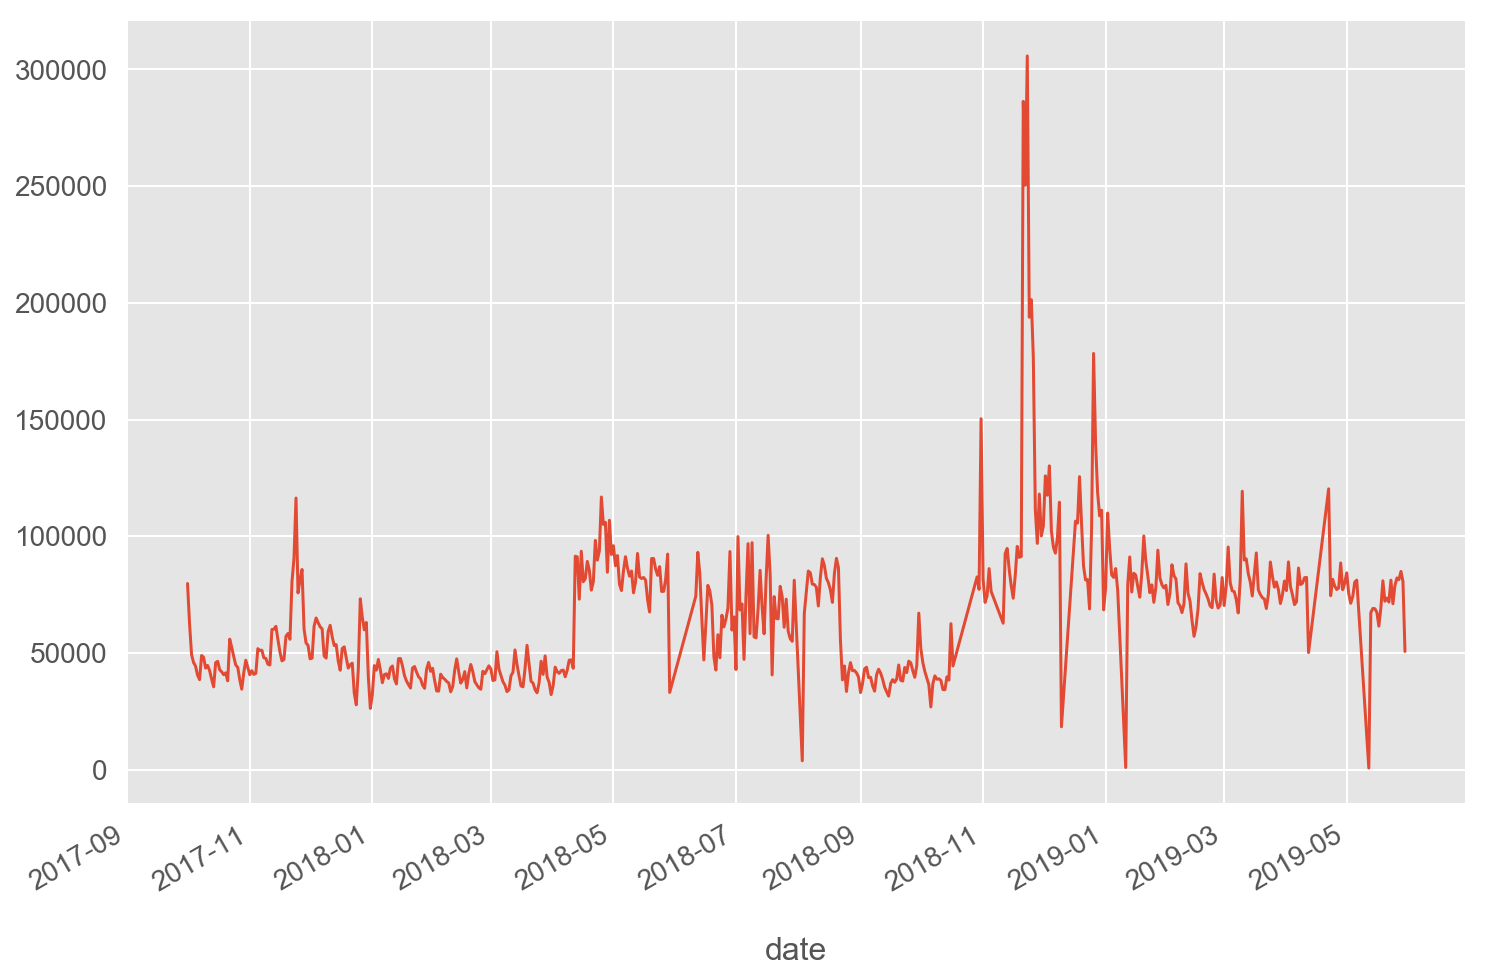

In [93]:
df_search_terms.groupby('date').num_searches.sum().plot()

We were able to pull over 10M onsite searches!

## Data Modeling

### Wordclouds

In [16]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [17]:
WordCloud?

In [20]:
def make_wordcloud(data, title=None, colormap='cividis'):
    """
    Generate a wordcloud.
    
    data : dict
        Term frequencies.
    """
    wordcloud = WordCloud(
        background_color='white',
        colormap=colormap,
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=80,
        scale=10,
        width=800,
        height=400,
        random_state=19, # just used to set color I think
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title is not None:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    return fig

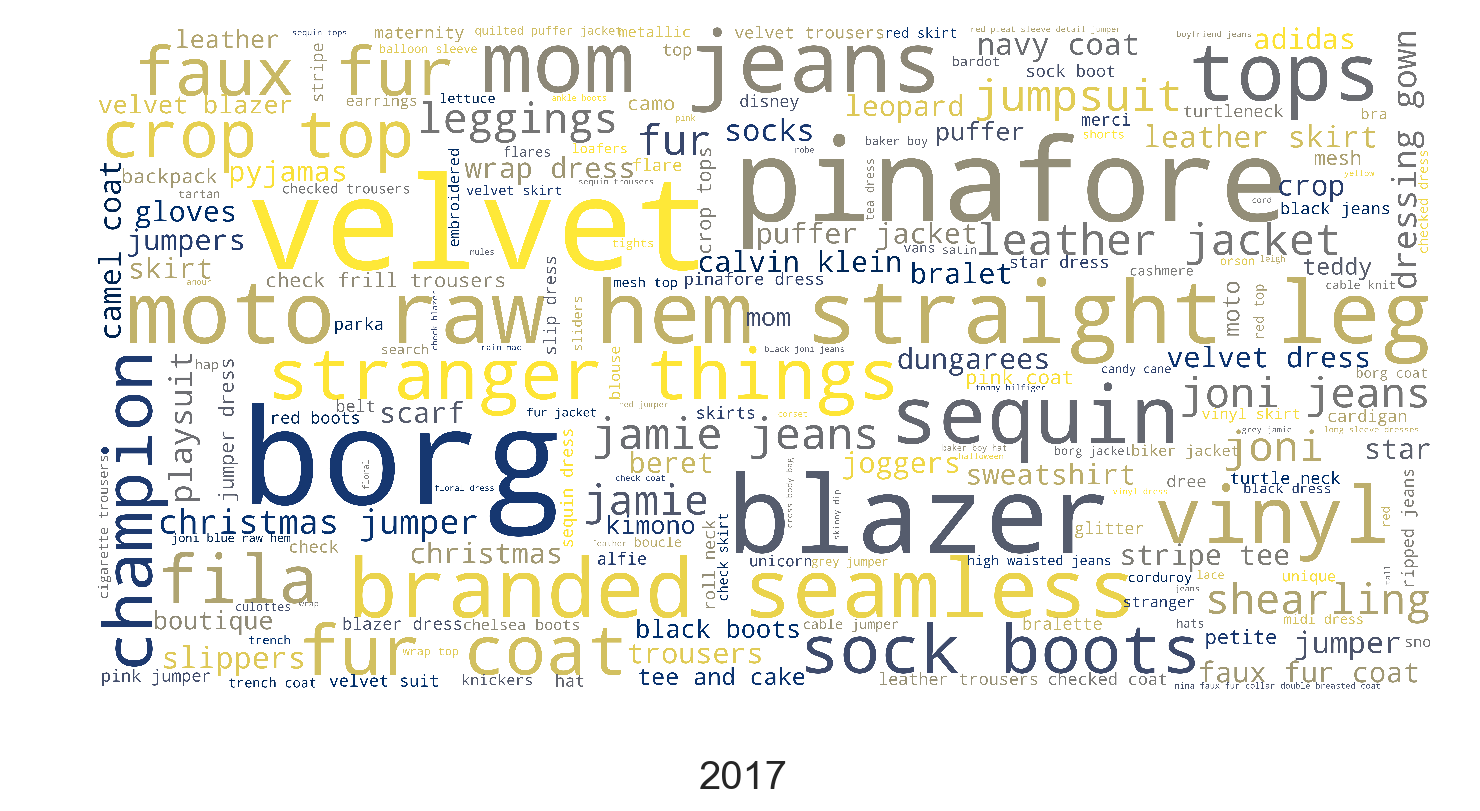

In [21]:
m = df_search_terms.date.apply(lambda x: x.strftime('%Y')) == '2017'
term_counts = df_search_terms[m].groupby('search_term_lower').num_searches.sum()
fig = make_wordcloud(term_counts.to_dict(), '2017')
savefig('onsite_search_tag_cloud_2017')
plt.show()

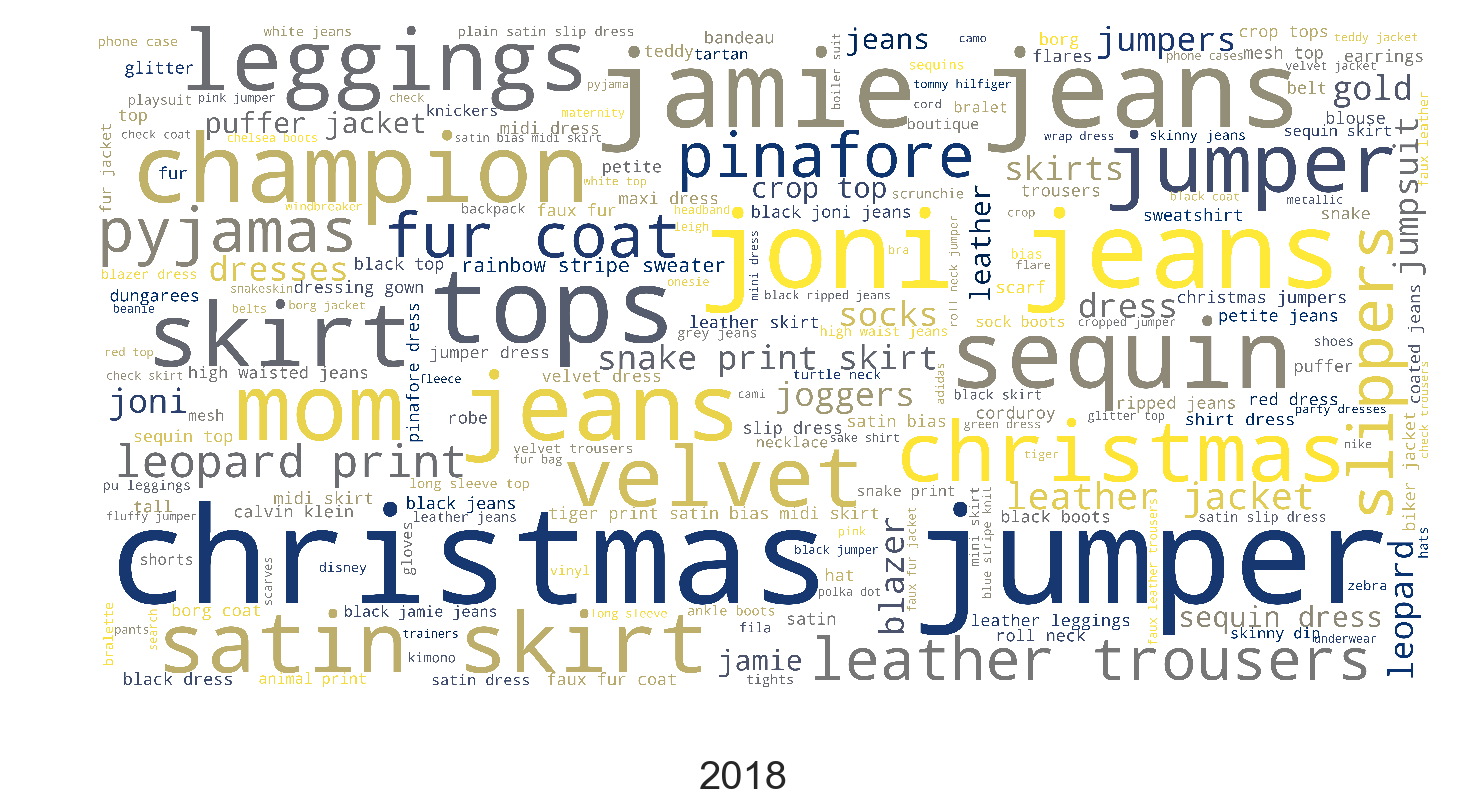

In [22]:
m = df_search_terms.date.apply(lambda x: x.strftime('%Y')) == '2018'
term_counts = df_search_terms[m].set_index('search_term').num_searches
fig = make_wordcloud(term_counts.to_dict(), '2018')
savefig('onsite_search_tag_cloud_2018')
plt.show()

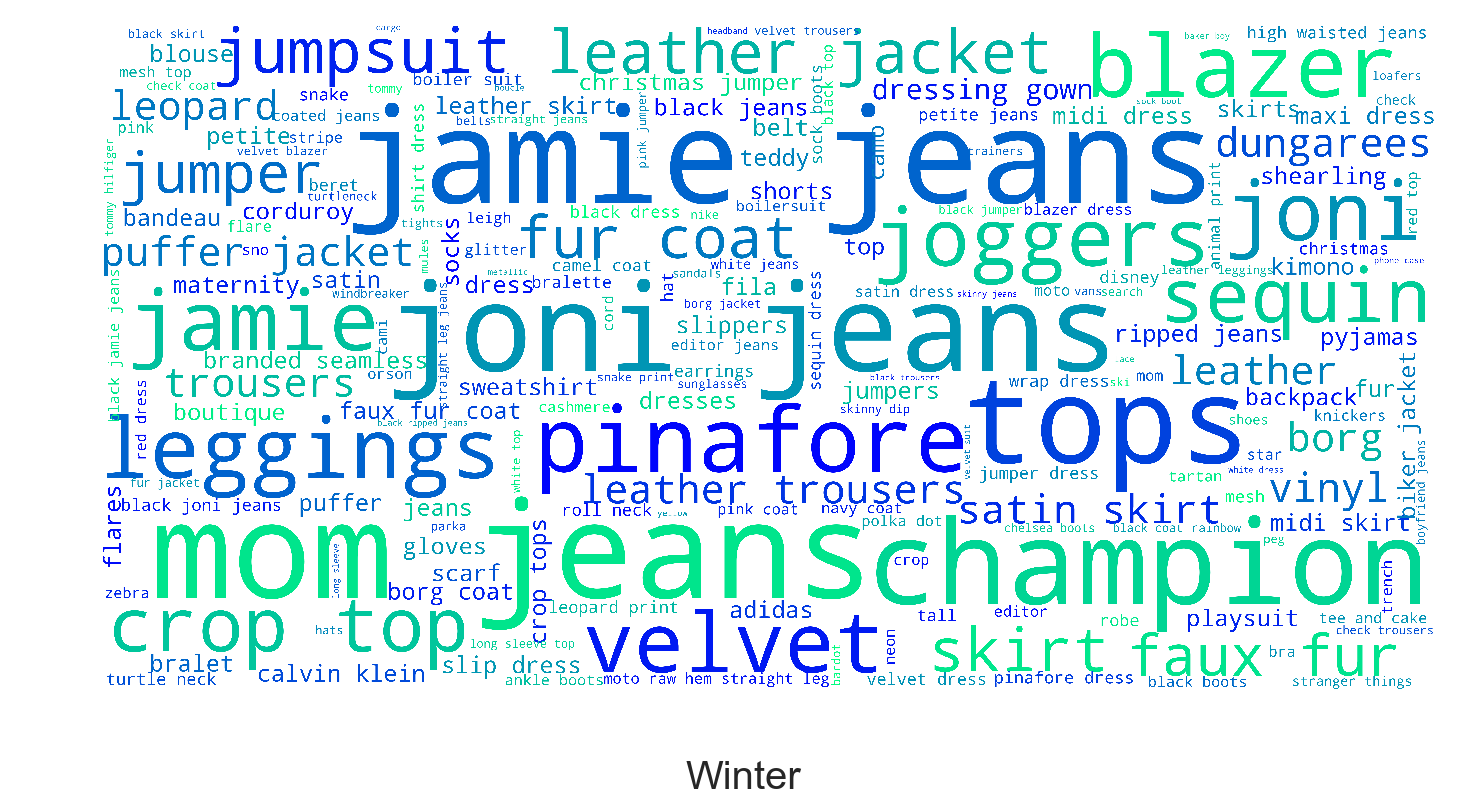

In [23]:
s = df_search_terms.date.apply(lambda x: x.month)
# Filter on Nov - Feb
m = ((s >= 11) & (s <= 12)) | ((s >= 1) & (s <= 2))
winter_term_counts = df_search_terms[m].groupby('search_term_lower').num_searches.sum()
fig = make_wordcloud(winter_term_counts.to_dict(), 'Winter', colormap='winter')
savefig('onsite_search_tag_cloud_winter')

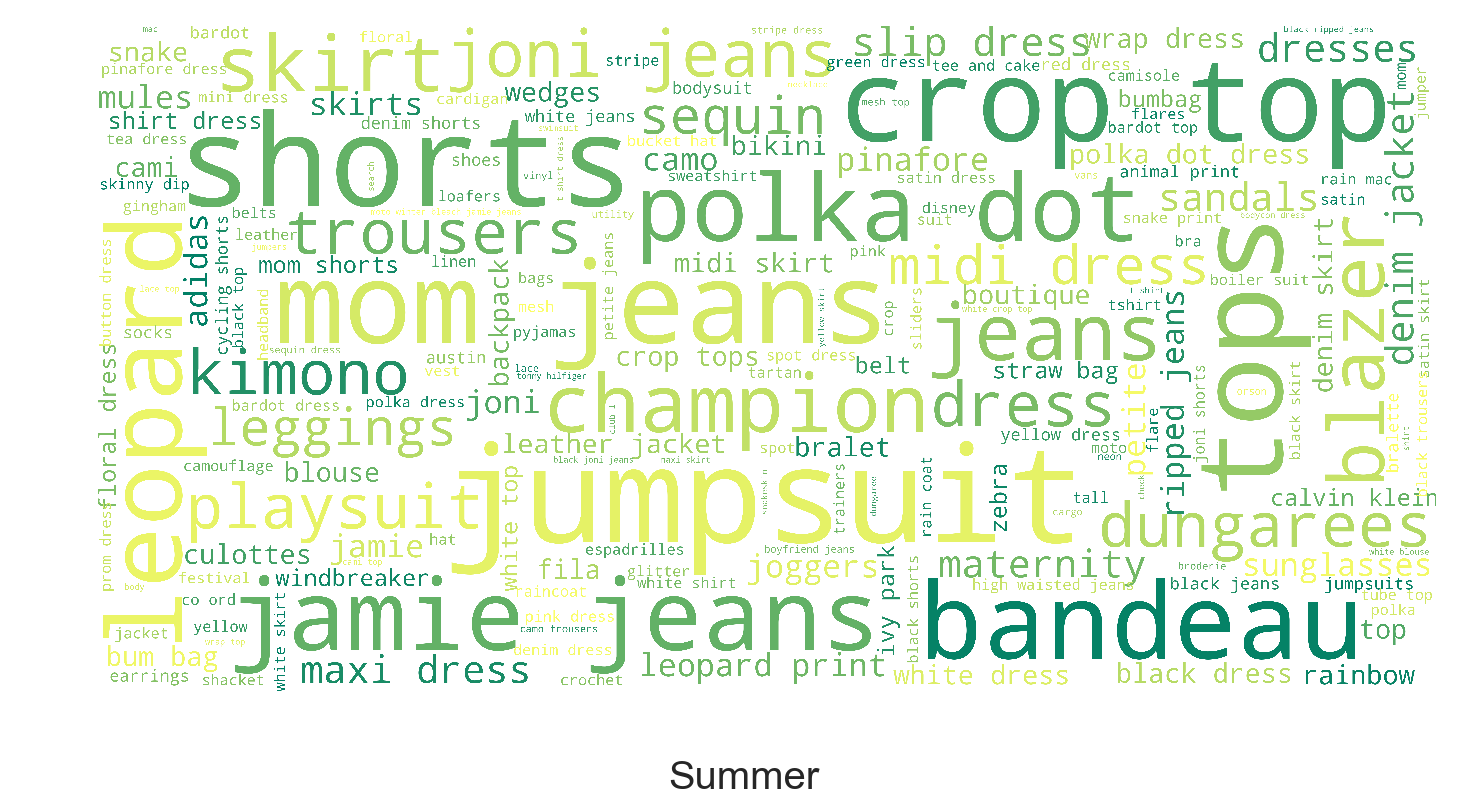

In [24]:
s = df_search_terms.date.apply(lambda x: x.month)
# Filter on May - Aug
m = ((s >= 5) & (s <= 8))
summer_term_counts = df_search_terms[m].groupby('search_term_lower').num_searches.sum()
fig = make_wordcloud(summer_term_counts.to_dict(), 'Summer', colormap='summer')
savefig('onsite_search_tag_cloud_summer')

Top 10 winter searches

In [43]:
winter_term_counts.sort_values(ascending=False).head(25)

search_term_lower
mom jeans         81627
jamie jeans       79588
joni jeans        69403
tops              68229
champion          64709
pinafore          62244
blazer            58224
leggings          52662
velvet            52568
jamie             52512
joni              50368
joggers           49130
crop top          45751
sequin            45744
jumpsuit          45253
leather jacket    43002
skirt             42739
fur coat          39293
jumper            37527
faux fur          36849
puffer jacket     35525
borg              34152
leopard           33978
trousers          33787
dungarees         32854
Name: num_searches, dtype: int64

Top 10 summer searches

In [44]:
summer_term_counts.sort_values(ascending=False).head(25)

search_term_lower
jumpsuit        47376
shorts          42992
tops            36790
crop top        34439
mom jeans       33929
bandeau         29404
leopard         28346
jamie jeans     27138
polka dot       25893
champion        25343
jeans           24301
skirt           23475
blazer          23425
joni jeans      22012
kimono          19605
dungarees       19481
playsuit        19237
dress           18844
trousers        18790
midi dress      18702
sequin          17771
leggings        17724
slip dress      17633
sandals         16852
denim jacket    16816
Name: num_searches, dtype: int64

In [45]:
summer_terms = (
    set(summer_term_counts.sort_values(ascending=False).head(25).index)
    - set(winter_term_counts.sort_values(ascending=False).head(25).index)
)
top_summer_terms = summer_term_counts[summer_term_counts.index.isin(list(summer_terms))]
top_summer_terms.sort_values(ascending=False)

search_term_lower
shorts          42992
bandeau         29404
polka dot       25893
jeans           24301
kimono          19605
playsuit        19237
dress           18844
midi dress      18702
slip dress      17633
sandals         16852
denim jacket    16816
Name: num_searches, dtype: int64

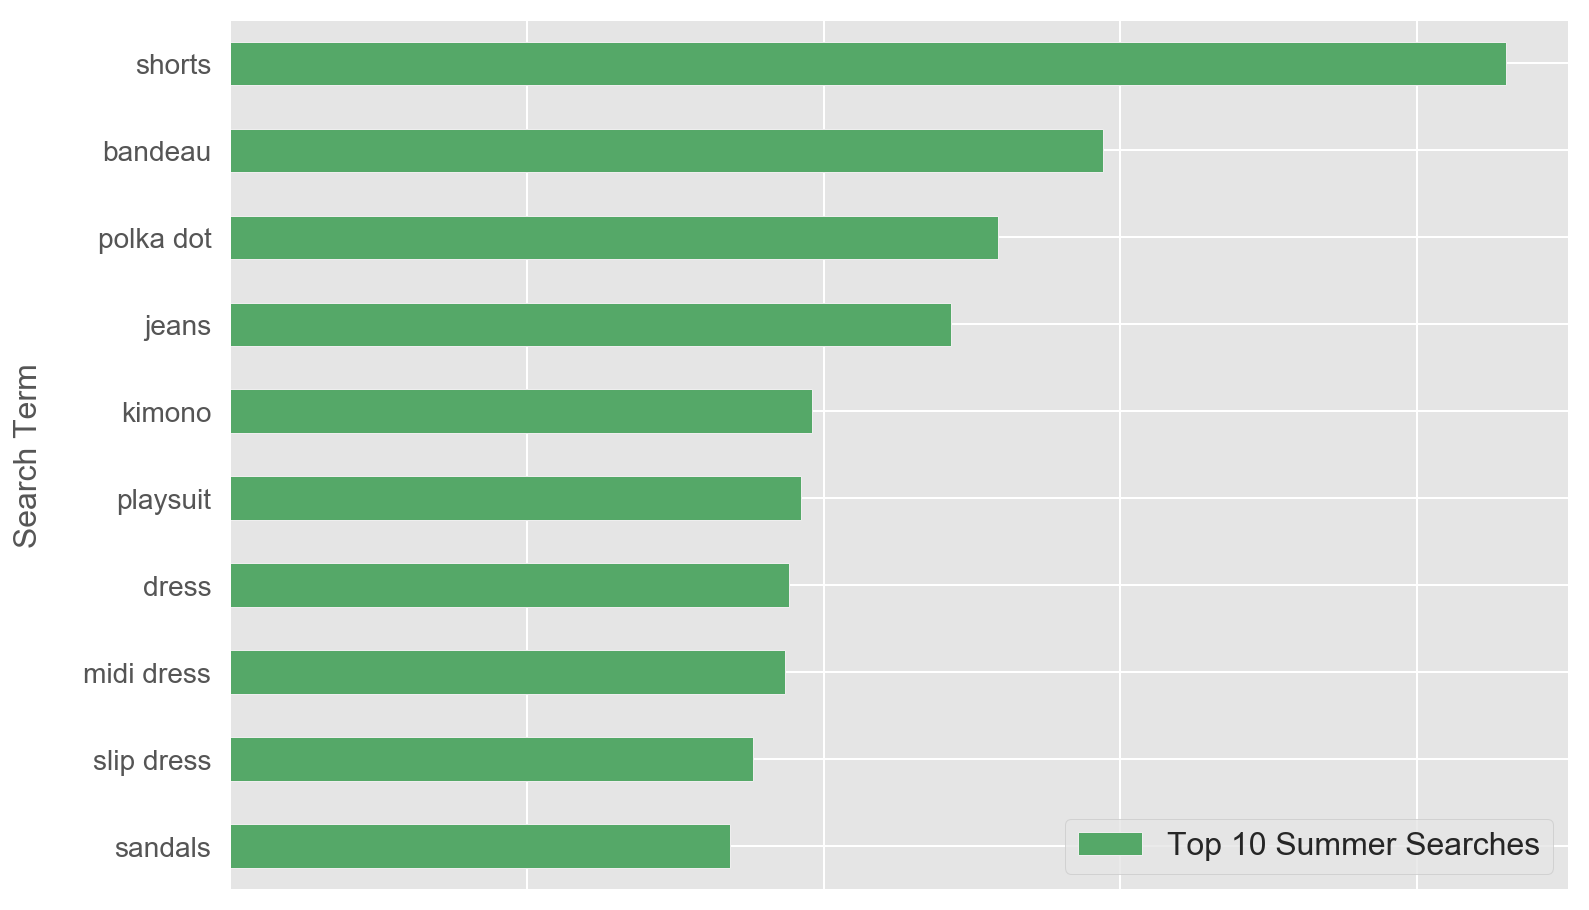

In [49]:
top_summer_terms.sort_values(ascending=False).head(10).iloc[::-1].plot.barh(color='g', label='Top 10 Summer Searches')
plt.legend()
plt.ylabel('Search Term')
ax = plt.gca()
ax.set_xticklabels([])
savefig('onsite_search_top_summer')

In [47]:
winter_terms = (
    set(winter_term_counts.sort_values(ascending=False).head(25).index)
    - set(summer_term_counts.sort_values(ascending=False).head(25).index)
)
top_winter_terms = winter_term_counts[winter_term_counts.index.isin(list(winter_terms))]
top_winter_terms.sort_values(ascending=False)

search_term_lower
pinafore          62244
velvet            52568
jamie             52512
joni              50368
joggers           49130
leather jacket    43002
fur coat          39293
jumper            37527
faux fur          36849
puffer jacket     35525
borg              34152
Name: num_searches, dtype: int64

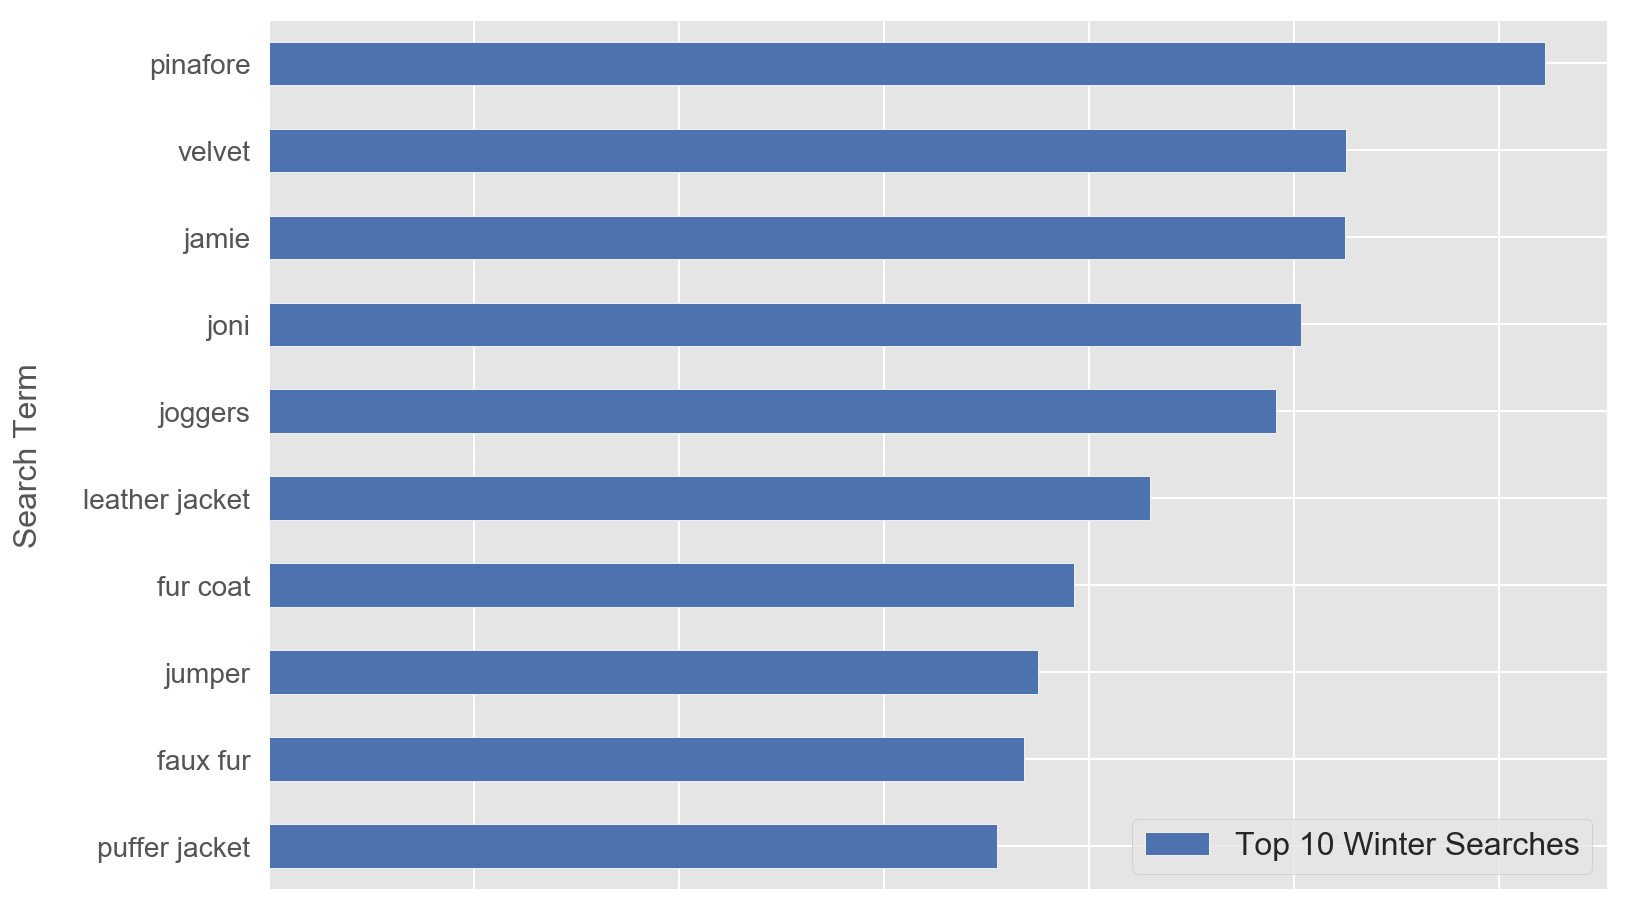

In [50]:
top_winter_terms.sort_values(ascending=False).head(10).iloc[::-1].plot.barh(color='b', label='Top 10 Winter Searches')
plt.legend()
plt.ylabel('Search Term')
ax = plt.gca()
ax.set_xticklabels([])
savefig('onsite_search_top_winter')

### Topic Modeling

In [96]:
import spacy
# Use spaCy instead of NLTK
# To run below, first do: python -m spacy download en

nlp = spacy.load('en')

my_stop_words = ['i', 'a', 'about', 'an', 'are', 'as', 'at', 'be', 'by',
                 'for', 'from', 'how', 'in', 'is', 'it', 'of', 'on', 'or',
                 'that', 'the', 'this', 'to', 'was', 'what', 'when', 'where',
                 'who', 'will', 'with', 'the']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [97]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower  
0                       ,axi dress  
14310             ´boyfriend jeans  
14309  'you me oui' slogan t-shirt  
14308                         ;ace  
14307             ;eather trousers

In [98]:
from tqdm import tqdm

In [99]:
def make_lemmas(text):
    nlp_text = nlp(text)
    lemmas = [w.lemma_ for w in nlp_text
              if not any((w.is_stop, w.is_punct, w.like_num))]
    return lemmas

tqdm.pandas()
search_terms = df_search_terms['search_term_lower'].drop_duplicates()
search_term_lemmas = search_terms.progress_apply(make_lemmas)
search_term_lemmas.name = 'lemmas'
s = pd.concat((search_terms, search_term_lemmas), axis=1).set_index('search_term_lower')['lemmas']

m = pd.Series(True, index=df_search_terms.index)
df_search_terms['lemmas'] = float('nan')
df_search_terms.loc[m, 'lemmas'] \
    = df_search_terms.loc[m, 'search_term_lower'].map(s)

100%|██████████| 2155446/2155446 [4:45:53<00:00, 125.66it/s]  


For a larger dataset, would want to run cell above externally

In [100]:
# Dump terms to file
# f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_lower_terms_dedupe.csv')
# df_search_terms.search_term_lower.drop_duplicates().to_csv(f_path, index=False)

# Run script externally....

# Load results from file

In [103]:
import gensim

In [104]:
m_not_empty = df_search_terms.lemmas.apply(lambda x: len(x) > 0)

# Extract bigrams
tqdm.pandas()
bigram = gensim.models.Phrases(
    df_search_terms.loc[m_not_empty, 'lemmas'].tolist()
)
df_search_terms['bigrams'] = float('nan')
df_search_terms.loc[m_not_empty, 'bigrams'] = (
    df_search_terms.loc[m_not_empty, 'lemmas']
    .progress_apply(lambda x: bigram[x])
)

100%|██████████| 10553370/10553370 [03:25<00:00, 51243.20it/s]


In [105]:
# Create integer corpus for learning algorithms
dictionary = gensim.corpora.Dictionary(df_search_terms.bigrams.dropna().tolist())
df_search_terms['corpus'] = float('nan')
df_search_terms.loc[m_not_empty, 'corpus'] = (
    df_search_terms.loc[m_not_empty, 'bigrams']
    .progress_apply(lambda x: dictionary.doc2bow(x))
)

100%|██████████| 10553370/10553370 [01:17<00:00, 136811.50it/s]


In [106]:
# Dump results of long computation

import pickle

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_nlp_gensim_dictionary.pkl')
# if os.path.isfile(f_path):
#     raise Exception(
#         'File exists! ({}) Run line below in separate cell to overwrite it. '
#         'Otherwise just run cell below to load file.'.format(f_path))

with open(f_path, 'wb') as f:
    pickle.dump(dictionary, f)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_nlp')
# if os.path.isfile('{}.csv'.format(f_path)):
#     raise Exception(
#         'File exists! ({}) Run line below in separate cell to overwrite it. '
#         'Otherwise just run cell below to load file.'.format(f_path))
    
df_search_terms.to_csv('{}.csv'.format(f_path), index=False)
df_search_terms.to_pickle('{}.pkl'.format(f_path))

In [107]:
# Ignore this cell

# tmp = df_search_terms.copy()
# tmp_dict = {**dictionary}

# del tmp
# del tmp_dict

In [108]:
# Load data

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_nlp_gensim_dictionary.pkl')
import pickle
with open(f_path, 'rb') as f:
    dictionary = pickle.load(f)
    
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_nlp.pkl')
df_search_terms = pd.read_pickle(f_path)

In [109]:
dictionary

In [110]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower                   lemmas  \
0                       ,axi dress             [axi, dress]   
14310             ´boyfriend jeans     [´, boyfriend, jean]   
14309  'you me oui' slogan t-shirt  [oui, slogan, t, shirt]   
14308                         ;ace                    [ace]   
14307             ;eather trousers        [eather, trouser]   

                       bigrams                            corpus  
0                 [axi, dress]                  [(0, 1), (1, 1)]  
14310     [´, boyfriend, jean]          [(2, 1), (3, 1), (4, 1)]  
14309  [oui, slogan, t, shirt]  [(5, 1), (6, 1), (7, 1), (8, 1)]  
14308                    [ace]                          [(9, 1)]  
14307        [eather, trouser]                [(10, 1), (11, 1)]

In [ ]:
# Latent Semantic Indexing (LSI) 

# from gensim.models import LsiModel
# lsimodel = LsiModel(
#     corpus=df_search_terms.corpus.dropna().tolist(),
#     num_topics=10,
#     id2word=dictionary,
# )

In [ ]:
# HDP Model

# from gensim.models import HdpModel
# hdpmodel = HdpModel(
#     corpus=df_search_terms.corpus.dropna().tolist(),
#     id2word=dictionary,
# )

Note: default behaviour for Gensim e.g.
> 2019-06-05 15:31:34,007 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 8585316 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000

In [8]:
# Log to file (you'll probably want to delete this after)

import logging
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_gensim.log')
logging.basicConfig(filename=f_path, format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Running a test first...

In [9]:
# Latent Dirichlet Allocation (LDA) model

from gensim.models import LdaModel
ldamodel = LdaModel(
    corpus=df_search_terms.corpus.dropna().tolist()[:10],
    num_topics=5,
    id2word=dictionary,
)

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [10]:
f_path

'/Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/onsite_search_gensim.log'

In [11]:
cat '/Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/onsite_search_gensim.log'

2019-06-05 16:10:48,353 : INFO : using symmetric alpha at 0.2
2019-06-05 16:10:48,358 : INFO : using symmetric eta at 0.2
2019-06-05 16:10:48,425 : INFO : using serial LDA version on this node
2019-06-05 16:10:48,641 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 10 documents, updating model once every 10 documents, evaluating perplexity every 10 documents, iterating 50x with a convergence threshold of 0.001000
2019-06-05 16:10:48,642 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-06-05 16:10:48,823 : INFO : -60130.732 per-word bound, inf perplexity estimate based on a held-out corpus of 10 documents with 24 words
2019-06-05 16:10:48,823 : INFO : PROGRESS: pass 0, at document #10/10
2019-06-05 16:10:49,221 : INFO : topic #0 (0.200): 0.000*"k" + 0.000*"necjlace" + 0.000*"05a43mwht" + 0.000*"c'_moi" + 0.000*"shirt" + 0.000*"ace" + 0.000*"t" + 0.00

Training on the full dataset (running externally `onsite_search_gensim_lda.py`)

In [ ]:
# Latent Dirichlet Allocation (LDA) model

# from gensim.models import LdaModel
# ldamodel = LdaModel(
#     corpus=df_search_terms.corpus.dropna().tolist(),
#     num_topics=5,
#     id2word=dictionary,
# )

In [20]:
# Save the model

# f_path = '../../models/onsite_search_terms_lda_2017_2019_5_topic.model'
# if os.path.isfile(f_path):
#     raise Exception(
#         'File exists! ({}) Run line below in separate cell to overwrite it. '
#         'Otherwise just run cell below to load file.'.format(f_path))

# ldamodel.save(f_path)

In [127]:
# Load the model

f_path = '../../models/onsite_search_terms_lda_2017_2019_5_topic.model'
ldamodel = gensim.models.LdaModel.load(f_path)

In [128]:
ldamodel.show_topics()

[(0,
  '0.149*"jean" + 0.073*"shirt" + 0.039*"t" + 0.035*"high" + 0.034*"blue" + 0.033*"jamie" + 0.032*"pink" + 0.029*"rip" + 0.023*"’s" + 0.021*"mom"'),
 (1,
  '0.072*"denim" + 0.067*"jacket" + 0.056*"bag" + 0.030*"shoe" + 0.027*"green" + 0.026*"heel" + 0.025*"pant" + 0.014*"snake" + 0.012*"mesh" + 0.012*"body"'),
 (2,
  '0.104*"black" + 0.073*"skirt" + 0.044*"petite" + 0.038*"print" + 0.026*"top" + 0.026*"sleeve" + 0.023*"red" + 0.023*"long" + 0.023*"mini" + 0.019*"stripe"'),
 (3,
  '0.079*"short" + 0.046*"woman" + 0.039*"sandal" + 0.039*"trouser" + 0.037*"bikini" + 0.029*"belt" + 0.023*"tall" + 0.019*"boot" + 0.017*"blazer" + 0.015*"moto"'),
 (4,
  '0.191*"dress" + 0.085*"white" + 0.036*"midi" + 0.035*"crop" + 0.030*"satin" + 0.029*"joni" + 0.021*"floral" + 0.019*"button" + 0.016*"slip" + 0.015*"vest"')]

In [129]:
# Model visualization

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(
    ldamodel,
    df_search_terms.corpus.dropna().tolist(),
    dictionary
)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.284444 -0.256064       1        1  22.291634
2      0.253128 -0.038233       2        1  22.201988
4      0.087908 -0.185078       3        1  19.932503
1     -0.227908  0.323159       4        1  18.117653
3      0.171316  0.156215       5        1  17.456221, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
1     Default  841329.000000         dress  841329.000000  30.0000  30.0000
3     Default  736163.000000          jean  736163.000000  29.0000  29.0000
1476  Default  509465.000000         black  509465.000000  28.0000  28.0000
1966  Default  375917.000000         white  375917.000000  27.0000  27.0000
1482  Default  360442.000000         skirt  360442.000000  26.0000  26.0000
6     Default  357550.000000         shirt  357550.000000  25.0000  25.0000
1208  Default  303555.000000         short  303555.000000  24.0000  24.0000
2229  Default  287059.000000         denim  287059.000000  23.0000  23.0000
1546  Default  268884.000000        jacket  268884.000000  22.0000  22.0000
1663  Default  225213.000000           bag  225213.000000  21.0000  21.0000
66    Default  217714.000000        petite  217714.000000  20.0000  20.0000
1899  Default  176686.000000         woman  176686.000000  19.0000  19.0000
8     Default  192374.000000             t  192374.000000  18.0000  18.0000
15    Default  187256.000000         print  187256.000000  17.0000  17.0000
1598  Default  152331.000000        sandal  152331.000000  16.0000  16.0000
1792  Default  174413.000000          high  174413.000000  15.0000  15.0000
38    Default  158711.000000          midi  158711.000000  14.0000  14.0000
11    Default  234512.000000       trouser  234512.000000  13.0000  13.0000
1840  Default  165131.000000          blue  165131.000000  12.0000  12.0000
45    Default  141966.000000        bikini  141966.000000  11.0000  11.0000
1700  Default  160447.000000         jamie  160447.000000  10.0000  10.0000
1874  Default  157335.000000          pink  157335.000000   9.0000   9.0000
42    Default  247467.000000          crop  247467.000000   8.0000   8.0000
1774  Default  144380.000000           rip  144380.000000   7.0000   7.0000
1872  Default  132068.000000         satin  132068.000000   6.0000   6.0000
1842  Default  129341.000000          joni  129341.000000   5.0000   5.0000
1549  Default  119257.000000          shoe  119257.000000   4.0000   4.0000
1588  Default  129515.000000           top  129515.000000   3.0000   3.0000
1965  Default  111213.000000          belt  111213.000000   2.0000   2.0000
16    Default  127439.000000        sleeve  127439.000000   1.0000   1.0000
...       ...            ...           ...            ...      ...      ...
1899   Topic5  176685.906250         woman  176686.734375   1.7455  -3.0837
1598   Topic5  152330.593750        sandal  152331.421875   1.7455  -3.2320
45     Topic5  141965.718750        bikini  141966.546875   1.7455  -3.3025
1965   Topic5  111212.640625          belt  111213.468750   1.7455  -3.5466
1813   Topic5   86907.914062          tall   86908.742188   1.7455  -3.7932
1495   Topic5   72889.257812          boot   72890.085938   1.7455  -3.9691
1808   Topic5   66121.617188        blazer   66122.445312   1.7455  -4.0665
1716   Topic5   59568.527344          moto   59569.359375   1.7455  -4.1709
1206   Topic5   49967.898438       legging   49968.726562   1.7455  -4.3467
2305   Topic5   47527.476562           mid   47528.312500   1.7455  -4.3967
1759   Topic5   46511.347656       earring   46512.175781   1.7455  -4.4183
1614   Topic5   45941.015625      bodysuit   45941.843750   1.7455  -4.4307
1959   Topic5   42900.976562       bandeau   42901.804688   1.7455  -4.4991
1507   Topic5   42704.054688        bleach   42704.886719   1.7455  -4.5037
1617   

In [ ]:
topic_name_map = {
    1: ''
}

In [130]:
# Export as web app

pyLDAvis.disable_notebook()
p = pyLDAvis.gensim.prepare(
    ldamodel,
    df_search_terms.corpus.dropna().tolist(),
    dictionary
)
pyLDAvis.save_html(p, '../../results/reports/onsite_search_terms_lda_2017_2019_5_topic.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


The size of the bubble measures the importance of the topics, relative to the data.

The terms are ordered by saliency (how much the term tells you about the topic).

The relevance slider can be used to adjust saliency scores.

In [131]:
ldamodel_topic_words = {i: list(re.findall(r'\*"([^"]+)"', v)) for i, v in ldamodel.show_topics()}
ldamodel_topic_words

{0: ['jean',
  'shirt',
  't',
  'high',
  'blue',
  'jamie',
  'pink',
  'rip',
  '’s',
  'mom'],
 1: ['denim',
  'jacket',
  'bag',
  'shoe',
  'green',
  'heel',
  'pant',
  'snake',
  'mesh',
  'body'],
 2: ['black',
  'skirt',
  'petite',
  'print',
  'top',
  'sleeve',
  'red',
  'long',
  'mini',
  'stripe'],
 3: ['short',
  'woman',
  'sandal',
  'trouser',
  'bikini',
  'belt',
  'tall',
  'boot',
  'blazer',
  'moto'],
 4: ['dress',
  'white',
  'midi',
  'crop',
  'satin',
  'joni',
  'floral',
  'button',
  'slip',
  'vest']}

### Tracking trends over time

Given a gensim model, label a corpus by topic and plot them over time. How do they change relative to one another?

Top topics may follow similar trends to global search patterns. Instead, look at "% of searches that are topic".

First, we need to label the training data

In [132]:
from tqdm import tqdm

In [133]:
tqdm.pandas()

m = ~(df_search_terms.corpus.isnull())
df_search_terms['lda_5_topic_scores'] = float('nan')
df_search_terms.loc[m, 'lda_5_topic_scores'] = (
    df_search_terms.loc[m, 'corpus']
    .progress_apply(lambda x: ldamodel[x])
)



  0%|          | 0/10553370 [00:00<?, ?it/s]

  0%|          | 1/10553370 [00:00<918:29:28,  3.19it/s]

  0%|          | 427/10553370 [00:00<643:07:28,  4.56it/s]

  0%|          | 1038/10553370 [00:00<450:18:21,  6.51it/s]

  0%|          | 1575/10553370 [00:00<315:21:43,  9.29it/s]

  0%|          | 2083/10553370 [00:00<220:54:57, 13.27it/s]

  0%|          | 2582/10553370 [00:00<154:48:40, 18.93it/s]

  0%|          | 3080/10553370 [00:00<108:32:21, 27.00it/s]

  0%|          | 3593/10553370 [00:01<76:08:43, 38.49it/s] 

  0%|          | 4061/10553370 [00:01<53:29:42, 54.78it/s]

  0%|          | 4549/10553370 [00:01<37:37:31, 77.88it/s]

  0%|          | 5104/10553370 [00:01<26:29:41, 110.59it/s]

  0%|          | 5638/10553370 [00:01<18:42:37, 156.59it/s]

  0%|          | 6202/10553370 [00:01<13:15:08, 221.07it/s]

  0%|          | 6780/10553370 [00:01<9:25:42, 310.72it/s] 

  0%|          | 7344/10553370 [00:01<6:45:19, 433.64it/s]

  0%|          | 7939/10553370 [00:01<4:52:3

  1%|          | 75030/10553370 [00:13<27:28, 6355.87it/s]

  1%|          | 75695/10553370 [00:13<27:26, 6362.43it/s]

  1%|          | 76414/10553370 [00:13<26:30, 6588.86it/s]

  1%|          | 77089/10553370 [00:13<26:26, 6602.70it/s]

  1%|          | 77792/10553370 [00:13<25:57, 6723.86it/s]

  1%|          | 78489/10553370 [00:13<25:41, 6795.50it/s]

  1%|          | 79175/10553370 [00:14<26:17, 6638.51it/s]

  1%|          | 79844/10553370 [00:14<26:46, 6518.19it/s]

  1%|          | 80500/10553370 [00:14<26:46, 6519.85it/s]

  1%|          | 81155/10553370 [00:14<27:03, 6452.25it/s]

  1%|          | 81803/10553370 [00:14<27:28, 6350.91it/s]

  1%|          | 82440/10553370 [00:14<28:27, 6133.29it/s]

  1%|          | 83064/10553370 [00:14<28:18, 6164.17it/s]

  1%|          | 83683/10553370 [00:14<28:23, 6147.26it/s]

  1%|          | 84328/10553370 [00:14<27:59, 6233.34it/s]

  1%|          | 84967/10553370 [00:15<27:47, 6279.32it/s]

  1%|          | 85596/10553370 [00:15<2

  1%|▏         | 155846/10553370 [00:26<28:58, 5979.90it/s]

  1%|▏         | 156521/10553370 [00:26<27:59, 6190.12it/s]

  1%|▏         | 157204/10553370 [00:26<27:12, 6368.60it/s]

  1%|▏         | 157879/10553370 [00:26<26:45, 6476.57it/s]

  2%|▏         | 158593/10553370 [00:26<26:00, 6661.63it/s]

  2%|▏         | 159297/10553370 [00:26<25:35, 6770.27it/s]

  2%|▏         | 159988/10553370 [00:26<25:26, 6810.41it/s]

  2%|▏         | 160692/10553370 [00:26<25:11, 6876.79it/s]

  2%|▏         | 161384/10553370 [00:26<25:11, 6873.23it/s]

  2%|▏         | 162075/10553370 [00:27<25:39, 6748.38it/s]

  2%|▏         | 162753/10553370 [00:27<25:53, 6686.77it/s]

  2%|▏         | 163424/10553370 [00:27<26:33, 6520.73it/s]

  2%|▏         | 164079/10553370 [00:27<26:44, 6473.68it/s]

  2%|▏         | 164728/10553370 [00:27<28:49, 6005.51it/s]

  2%|▏         | 165337/10553370 [00:27<29:19, 5903.64it/s]

  2%|▏         | 165988/10553370 [00:27<28:31, 6070.44it/s]

  2%|▏         | 166656/

  2%|▏         | 238020/10553370 [00:38<25:28, 6747.65it/s]

  2%|▏         | 238726/10553370 [00:39<25:08, 6836.37it/s]

  2%|▏         | 239412/10553370 [00:39<25:19, 6788.83it/s]

  2%|▏         | 240180/10553370 [00:39<24:26, 7033.12it/s]

  2%|▏         | 240887/10553370 [00:39<24:25, 7039.15it/s]

  2%|▏         | 241594/10553370 [00:39<24:44, 6944.43it/s]

  2%|▏         | 242324/10553370 [00:39<24:23, 7045.61it/s]

  2%|▏         | 243031/10553370 [00:39<24:28, 7023.15it/s]

  2%|▏         | 243750/10553370 [00:39<24:18, 7070.24it/s]

  2%|▏         | 244458/10553370 [00:39<27:13, 6310.41it/s]

  2%|▏         | 245177/10553370 [00:40<26:14, 6548.82it/s]

  2%|▏         | 245846/10553370 [00:40<26:51, 6396.84it/s]

  2%|▏         | 246503/10553370 [00:40<26:38, 6446.57it/s]

  2%|▏         | 247237/10553370 [00:40<25:40, 6689.09it/s]

  2%|▏         | 247914/10553370 [00:40<26:15, 6542.00it/s]

  2%|▏         | 248664/10553370 [00:40<25:14, 6801.99it/s]

  2%|▏         | 249351/

  3%|▎         | 317137/10553370 [00:51<31:24, 5433.22it/s]

  3%|▎         | 317739/10553370 [00:52<30:29, 5595.37it/s]

  3%|▎         | 318395/10553370 [00:52<29:08, 5852.15it/s]

  3%|▎         | 319019/10553370 [00:52<28:36, 5963.06it/s]

  3%|▎         | 319624/10553370 [00:52<29:45, 5730.42it/s]

  3%|▎         | 320205/10553370 [00:52<34:22, 4961.56it/s]

  3%|▎         | 320804/10553370 [00:52<32:36, 5230.64it/s]

  3%|▎         | 321348/10553370 [00:52<37:48, 4511.08it/s]

  3%|▎         | 321831/10553370 [00:52<46:50, 3640.64it/s]

  3%|▎         | 322245/10553370 [00:53<45:12, 3771.88it/s]

  3%|▎         | 322658/10553370 [00:53<46:35, 3659.48it/s]

  3%|▎         | 323050/10553370 [00:53<50:19, 3388.33it/s]

  3%|▎         | 323411/10553370 [00:53<52:45, 3231.49it/s]

  3%|▎         | 324074/10553370 [00:53<44:39, 3818.22it/s]

  3%|▎         | 324819/10553370 [00:53<38:10, 4466.57it/s]

  3%|▎         | 325491/10553370 [00:53<34:19, 4966.00it/s]

  3%|▎         | 326204/

  4%|▎         | 395474/10553370 [01:04<28:31, 5934.37it/s]

  4%|▍         | 396099/10553370 [01:05<28:06, 6023.70it/s]

  4%|▍         | 396714/10553370 [01:05<27:57, 6055.53it/s]

  4%|▍         | 397407/10553370 [01:05<26:53, 6293.39it/s]

  4%|▍         | 398063/10553370 [01:05<26:34, 6370.31it/s]

  4%|▍         | 398720/10553370 [01:05<26:19, 6427.93it/s]

  4%|▍         | 399410/10553370 [01:05<25:47, 6560.47it/s]

  4%|▍         | 400069/10553370 [01:05<26:34, 6365.87it/s]

  4%|▍         | 400709/10553370 [01:05<27:13, 6215.76it/s]

  4%|▍         | 401400/10553370 [01:05<26:24, 6407.41it/s]

  4%|▍         | 402045/10553370 [01:05<27:38, 6119.96it/s]

  4%|▍         | 402756/10553370 [01:06<26:29, 6386.14it/s]

  4%|▍         | 403435/10553370 [01:06<26:01, 6501.08it/s]

  4%|▍         | 404193/10553370 [01:06<24:55, 6787.89it/s]

  4%|▍         | 404946/10553370 [01:06<24:11, 6993.08it/s]

  4%|▍         | 405678/10553370 [01:06<23:51, 7087.80it/s]

  4%|▍         | 406431/

  4%|▍         | 474753/10553370 [01:18<29:17, 5734.32it/s]

  5%|▍         | 475473/10553370 [01:18<27:30, 6105.89it/s]

  5%|▍         | 476219/10553370 [01:18<26:00, 6457.25it/s]

  5%|▍         | 476972/10553370 [01:18<24:54, 6744.17it/s]

  5%|▍         | 477680/10553370 [01:18<25:06, 6688.48it/s]

  5%|▍         | 478407/10553370 [01:18<24:30, 6851.48it/s]

  5%|▍         | 479110/10553370 [01:19<27:54, 6015.18it/s]

  5%|▍         | 479743/10553370 [01:19<35:57, 4669.00it/s]

  5%|▍         | 480349/10553370 [01:19<33:33, 5003.12it/s]

  5%|▍         | 480904/10553370 [01:19<46:53, 3580.59it/s]

  5%|▍         | 481357/10553370 [01:19<54:46, 3064.65it/s]

  5%|▍         | 481743/10553370 [01:20<1:02:01, 2706.37it/s]

  5%|▍         | 482077/10553370 [01:20<1:11:16, 2355.03it/s]

  5%|▍         | 482365/10553370 [01:20<1:43:00, 1629.50it/s]

  5%|▍         | 482595/10553370 [01:20<1:35:58, 1748.93it/s]

  5%|▍         | 482941/10553370 [01:20<1:21:43, 2053.53it/s]

  5%|▍        

  5%|▌         | 537697/10553370 [01:32<30:16, 5513.69it/s]

  5%|▌         | 538252/10553370 [01:32<31:30, 5298.27it/s]

  5%|▌         | 538912/10553370 [01:33<29:38, 5629.91it/s]

  5%|▌         | 539586/10553370 [01:33<28:11, 5921.74it/s]

  5%|▌         | 540287/10553370 [01:33<26:52, 6210.89it/s]

  5%|▌         | 540995/10553370 [01:33<25:53, 6446.02it/s]

  5%|▌         | 541650/10553370 [01:33<27:57, 5969.64it/s]

  5%|▌         | 542288/10553370 [01:33<27:56, 5972.10it/s]

  5%|▌         | 543006/10553370 [01:33<26:31, 6289.30it/s]

  5%|▌         | 543702/10553370 [01:33<25:45, 6475.36it/s]

  5%|▌         | 544367/10553370 [01:33<25:33, 6526.53it/s]

  5%|▌         | 545047/10553370 [01:33<25:15, 6605.15it/s]

  5%|▌         | 545725/10553370 [01:34<25:03, 6655.32it/s]

  5%|▌         | 546428/10553370 [01:34<24:39, 6763.00it/s]

  5%|▌         | 547108/10553370 [01:34<25:06, 6641.70it/s]

  5%|▌         | 547775/10553370 [01:34<25:33, 6522.76it/s]

  5%|▌         | 548430/

  6%|▌         | 618110/10553370 [01:45<26:38, 6216.67it/s]

  6%|▌         | 618749/10553370 [01:45<26:25, 6265.92it/s]

  6%|▌         | 619379/10553370 [01:45<26:37, 6217.91it/s]

  6%|▌         | 620004/10553370 [01:45<27:06, 6105.99it/s]

  6%|▌         | 620617/10553370 [01:46<31:19, 5283.95it/s]

  6%|▌         | 621167/10553370 [01:46<34:45, 4763.47it/s]

  6%|▌         | 621668/10553370 [01:46<44:53, 3687.79it/s]

  6%|▌         | 622092/10553370 [01:46<1:09:50, 2369.80it/s]

  6%|▌         | 622427/10553370 [01:46<1:11:09, 2325.91it/s]

  6%|▌         | 622837/10553370 [01:46<1:01:59, 2669.68it/s]

  6%|▌         | 623239/10553370 [01:47<55:45, 2968.64it/s]  

  6%|▌         | 623832/10553370 [01:47<47:24, 3491.15it/s]

  6%|▌         | 624464/10553370 [01:47<41:02, 4032.37it/s]

  6%|▌         | 625106/10553370 [01:47<36:27, 4537.94it/s]

  6%|▌         | 625640/10553370 [01:47<36:34, 4523.36it/s]

  6%|▌         | 626149/10553370 [01:47<43:28, 3806.19it/s]

  6%|▌         |

  7%|▋         | 689695/10553370 [01:59<44:26, 3699.31it/s]

  7%|▋         | 690234/10553370 [01:59<40:15, 4083.34it/s]

  7%|▋         | 690669/10553370 [01:59<40:15, 4083.85it/s]

  7%|▋         | 691117/10553370 [01:59<39:11, 4194.74it/s]

  7%|▋         | 691566/10553370 [01:59<38:25, 4277.89it/s]

  7%|▋         | 692026/10553370 [01:59<37:40, 4362.99it/s]

  7%|▋         | 692553/10553370 [02:00<35:43, 4600.00it/s]

  7%|▋         | 693072/10553370 [02:00<34:33, 4754.60it/s]

  7%|▋         | 693555/10553370 [02:00<35:26, 4637.38it/s]

  7%|▋         | 694025/10553370 [02:00<36:19, 4524.19it/s]

  7%|▋         | 694483/10553370 [02:00<36:35, 4490.63it/s]

  7%|▋         | 694936/10553370 [02:00<36:35, 4489.63it/s]

  7%|▋         | 695388/10553370 [02:00<36:45, 4468.91it/s]

  7%|▋         | 695849/10553370 [02:00<36:25, 4509.58it/s]

  7%|▋         | 696446/10553370 [02:00<33:45, 4866.30it/s]

  7%|▋         | 696942/10553370 [02:01<41:15, 3982.23it/s]

  7%|▋         | 697513/

  7%|▋         | 753436/10553370 [02:12<33:01, 4944.51it/s]

  7%|▋         | 753938/10553370 [02:13<37:38, 4339.43it/s]

  7%|▋         | 754391/10553370 [02:13<42:43, 3822.95it/s]

  7%|▋         | 754924/10553370 [02:13<39:06, 4176.09it/s]

  7%|▋         | 755369/10553370 [02:13<40:12, 4062.19it/s]

  7%|▋         | 755795/10553370 [02:13<47:46, 3417.75it/s]

  7%|▋         | 756336/10553370 [02:13<42:30, 3841.19it/s]

  7%|▋         | 756760/10553370 [02:13<43:16, 3772.72it/s]

  7%|▋         | 757175/10553370 [02:14<42:06, 3877.33it/s]

  7%|▋         | 757639/10553370 [02:14<40:02, 4077.81it/s]

  7%|▋         | 758118/10553370 [02:14<38:15, 4267.81it/s]

  7%|▋         | 758576/10553370 [02:14<37:29, 4354.27it/s]

  7%|▋         | 759027/10553370 [02:14<37:06, 4398.37it/s]

  7%|▋         | 759482/10553370 [02:14<36:44, 4441.91it/s]

  7%|▋         | 759983/10553370 [02:14<35:30, 4597.78it/s]

  7%|▋         | 760584/10553370 [02:14<33:00, 4945.59it/s]

  7%|▋         | 761090/

  8%|▊         | 828475/10553370 [02:26<28:23, 5707.37it/s]

  8%|▊         | 829127/10553370 [02:26<27:20, 5928.80it/s]

  8%|▊         | 829727/10553370 [02:26<27:23, 5916.26it/s]

  8%|▊         | 830383/10553370 [02:26<26:35, 6095.70it/s]

  8%|▊         | 831030/10553370 [02:26<26:08, 6198.74it/s]

  8%|▊         | 831685/10553370 [02:26<25:43, 6297.94it/s]

  8%|▊         | 832417/10553370 [02:26<24:39, 6571.89it/s]

  8%|▊         | 833181/10553370 [02:26<23:37, 6858.30it/s]

  8%|▊         | 833874/10553370 [02:26<24:21, 6648.43it/s]

  8%|▊         | 834546/10553370 [02:26<24:43, 6550.11it/s]

  8%|▊         | 835220/10553370 [02:27<24:31, 6604.04it/s]

  8%|▊         | 835918/10553370 [02:27<24:07, 6711.40it/s]

  8%|▊         | 836592/10553370 [02:27<24:23, 6640.52it/s]

  8%|▊         | 837259/10553370 [02:27<26:17, 6159.02it/s]

  8%|▊         | 837884/10553370 [02:27<27:44, 5838.06it/s]

  8%|▊         | 838478/10553370 [02:27<27:57, 5790.32it/s]

  8%|▊         | 839072/

  9%|▊         | 908440/10553370 [02:38<24:49, 6473.92it/s]

  9%|▊         | 909160/10553370 [02:38<24:04, 6675.47it/s]

  9%|▊         | 909831/10553370 [02:38<25:16, 6357.73it/s]

  9%|▊         | 910479/10553370 [02:39<25:08, 6393.36it/s]

  9%|▊         | 911123/10553370 [02:39<25:43, 6248.25it/s]

  9%|▊         | 911786/10553370 [02:39<25:16, 6357.91it/s]

  9%|▊         | 912455/10553370 [02:39<24:54, 6450.67it/s]

  9%|▊         | 913127/10553370 [02:39<24:36, 6527.92it/s]

  9%|▊         | 913782/10553370 [02:39<25:43, 6247.12it/s]

  9%|▊         | 914479/10553370 [02:39<24:54, 6447.46it/s]

  9%|▊         | 915177/10553370 [02:39<24:21, 6596.51it/s]

  9%|▊         | 915841/10553370 [02:39<24:23, 6585.64it/s]

  9%|▊         | 916503/10553370 [02:39<24:30, 6552.69it/s]

  9%|▊         | 917167/10553370 [02:40<24:25, 6577.07it/s]

  9%|▊         | 917827/10553370 [02:40<24:31, 6547.90it/s]

  9%|▊         | 918483/10553370 [02:40<25:07, 6392.46it/s]

  9%|▊         | 919169/

  9%|▉         | 990133/10553370 [02:51<25:03, 6360.28it/s]

  9%|▉         | 990779/10553370 [02:51<25:12, 6323.97it/s]

  9%|▉         | 991419/10553370 [02:51<25:07, 6342.02it/s]

  9%|▉         | 992058/10553370 [02:51<25:36, 6224.42it/s]

  9%|▉         | 992685/10553370 [02:51<26:06, 6104.50it/s]

  9%|▉         | 993319/10553370 [02:51<25:49, 6170.64it/s]

  9%|▉         | 993939/10553370 [02:52<26:13, 6073.90it/s]

  9%|▉         | 994549/10553370 [02:52<27:20, 5828.46it/s]

  9%|▉         | 995136/10553370 [02:52<27:43, 5746.39it/s]

  9%|▉         | 995714/10553370 [02:52<30:28, 5226.25it/s]

  9%|▉         | 996319/10553370 [02:52<29:14, 5447.42it/s]

  9%|▉         | 996926/10553370 [02:52<28:20, 5619.92it/s]

  9%|▉         | 997642/10553370 [02:52<26:31, 6006.10it/s]

  9%|▉         | 998256/10553370 [02:52<26:40, 5970.75it/s]

  9%|▉         | 998863/10553370 [02:52<26:56, 5911.58it/s]

  9%|▉         | 999490/10553370 [02:53<26:28, 6013.36it/s]

  9%|▉         | 1000172

 10%|█         | 1069455/10553370 [03:03<24:11, 6533.87it/s]

 10%|█         | 1070114/10553370 [03:04<24:12, 6529.42it/s]

 10%|█         | 1070861/10553370 [03:04<23:17, 6785.05it/s]

 10%|█         | 1071557/10553370 [03:04<23:07, 6836.10it/s]

 10%|█         | 1072245/10553370 [03:04<23:09, 6824.30it/s]

 10%|█         | 1073006/10553370 [03:04<22:26, 7040.79it/s]

 10%|█         | 1073714/10553370 [03:04<24:11, 6528.70it/s]

 10%|█         | 1074378/10553370 [03:04<24:06, 6554.10it/s]

 10%|█         | 1075065/10553370 [03:04<23:46, 6644.48it/s]

 10%|█         | 1075791/10553370 [03:04<23:10, 6814.67it/s]

 10%|█         | 1076519/10553370 [03:05<22:44, 6946.37it/s]

 10%|█         | 1077245/10553370 [03:05<22:26, 7035.50it/s]

 10%|█         | 1077952/10553370 [03:05<22:38, 6976.45it/s]

 10%|█         | 1078652/10553370 [03:05<23:33, 6701.15it/s]

 10%|█         | 1079326/10553370 [03:05<24:09, 6537.83it/s]

 10%|█         | 1079984/10553370 [03:05<24:30, 6444.04it/s]

 10%|█  

 11%|█         | 1147620/10553370 [03:16<34:41, 4519.53it/s]

 11%|█         | 1148110/10553370 [03:16<33:52, 4626.65it/s]

 11%|█         | 1148779/10553370 [03:16<30:44, 5098.00it/s]

 11%|█         | 1149311/10553370 [03:16<30:28, 5143.51it/s]

 11%|█         | 1149841/10553370 [03:17<31:17, 5009.23it/s]

 11%|█         | 1150428/10553370 [03:17<29:54, 5239.72it/s]

 11%|█         | 1151032/10553370 [03:17<28:43, 5455.85it/s]

 11%|█         | 1151588/10553370 [03:17<31:09, 5028.85it/s]

 11%|█         | 1152105/10553370 [03:17<32:07, 4878.09it/s]

 11%|█         | 1152604/10553370 [03:17<33:30, 4676.79it/s]

 11%|█         | 1153103/10553370 [03:17<32:52, 4765.33it/s]

 11%|█         | 1153801/10553370 [03:17<29:45, 5265.00it/s]

 11%|█         | 1154448/10553370 [03:17<28:05, 5575.77it/s]

 11%|█         | 1155110/10553370 [03:18<26:45, 5852.36it/s]

 11%|█         | 1155762/10553370 [03:18<25:57, 6034.45it/s]

 11%|█         | 1156432/10553370 [03:18<25:11, 6218.89it/s]

 11%|█  

 12%|█▏        | 1224003/10553370 [03:29<23:15, 6687.07it/s]

 12%|█▏        | 1224674/10553370 [03:29<25:08, 6185.88it/s]

 12%|█▏        | 1225302/10553370 [03:29<25:24, 6120.32it/s]

 12%|█▏        | 1225921/10553370 [03:29<26:12, 5933.49it/s]

 12%|█▏        | 1226520/10553370 [03:29<27:24, 5672.79it/s]

 12%|█▏        | 1227094/10553370 [03:29<28:16, 5498.85it/s]

 12%|█▏        | 1227738/10553370 [03:29<27:02, 5749.38it/s]

 12%|█▏        | 1228320/10553370 [03:30<28:06, 5528.82it/s]

 12%|█▏        | 1228985/10553370 [03:30<26:41, 5822.65it/s]

 12%|█▏        | 1229597/10553370 [03:30<26:18, 5907.06it/s]

 12%|█▏        | 1230231/10553370 [03:30<25:46, 6029.12it/s]

 12%|█▏        | 1230840/10553370 [03:30<26:29, 5863.38it/s]

 12%|█▏        | 1231431/10553370 [03:30<26:56, 5765.55it/s]

 12%|█▏        | 1232012/10553370 [03:30<28:15, 5498.79it/s]

 12%|█▏        | 1232567/10553370 [03:30<28:48, 5391.48it/s]

 12%|█▏        | 1233111/10553370 [03:30<29:10, 5324.39it/s]

 12%|█▏ 

 12%|█▏        | 1300724/10553370 [03:41<26:03, 5918.69it/s]

 12%|█▏        | 1301323/10553370 [03:41<26:32, 5808.53it/s]

 12%|█▏        | 1301910/10553370 [03:42<26:54, 5731.33it/s]

 12%|█▏        | 1302487/10553370 [03:42<28:10, 5471.32it/s]

 12%|█▏        | 1303075/10553370 [03:42<27:35, 5586.07it/s]

 12%|█▏        | 1303715/10553370 [03:42<26:32, 5807.09it/s]

 12%|█▏        | 1304408/10553370 [03:42<25:15, 6102.91it/s]

 12%|█▏        | 1305026/10553370 [03:42<26:35, 5795.87it/s]

 12%|█▏        | 1305615/10553370 [03:42<26:53, 5732.68it/s]

 12%|█▏        | 1306195/10553370 [03:42<27:45, 5552.87it/s]

 12%|█▏        | 1306783/10553370 [03:42<27:17, 5645.33it/s]

 12%|█▏        | 1307512/10553370 [03:43<25:27, 6053.89it/s]

 12%|█▏        | 1308173/10553370 [03:43<24:48, 6209.82it/s]

 12%|█▏        | 1308803/10553370 [03:43<25:52, 5955.83it/s]

 12%|█▏        | 1309408/10553370 [03:43<26:29, 5816.41it/s]

 12%|█▏        | 1309997/10553370 [03:43<27:26, 5613.45it/s]

 12%|█▏ 

 13%|█▎        | 1376492/10553370 [03:54<25:34, 5981.92it/s]

 13%|█▎        | 1377113/10553370 [03:54<25:18, 6044.79it/s]

 13%|█▎        | 1377724/10553370 [03:54<25:16, 6050.82it/s]

 13%|█▎        | 1378374/10553370 [03:54<24:45, 6177.01it/s]

 13%|█▎        | 1378996/10553370 [03:55<25:10, 6071.89it/s]

 13%|█▎        | 1379671/10553370 [03:55<24:25, 6259.75it/s]

 13%|█▎        | 1380338/10553370 [03:55<23:58, 6376.44it/s]

 13%|█▎        | 1381001/10553370 [03:55<23:43, 6445.65it/s]

 13%|█▎        | 1381666/10553370 [03:55<23:30, 6504.17it/s]

 13%|█▎        | 1382398/10553370 [03:55<22:43, 6728.37it/s]

 13%|█▎        | 1383074/10553370 [03:55<22:41, 6733.36it/s]

 13%|█▎        | 1383767/10553370 [03:55<22:30, 6790.75it/s]

 13%|█▎        | 1384448/10553370 [03:55<23:40, 6455.84it/s]

 13%|█▎        | 1385099/10553370 [03:56<27:11, 5618.60it/s]

 13%|█▎        | 1385716/10553370 [03:56<26:27, 5773.24it/s]

 13%|█▎        | 1386382/10553370 [03:56<25:24, 6012.86it/s]

 13%|█▎ 

 14%|█▍        | 1452782/10553370 [04:07<28:52, 5251.79it/s]

 14%|█▍        | 1453463/10553370 [04:07<26:54, 5637.79it/s]

 14%|█▍        | 1454188/10553370 [04:07<25:06, 6040.16it/s]

 14%|█▍        | 1454813/10553370 [04:07<25:02, 6055.40it/s]

 14%|█▍        | 1455537/10553370 [04:07<23:49, 6366.21it/s]

 14%|█▍        | 1456232/10553370 [04:07<23:13, 6530.53it/s]

 14%|█▍        | 1456912/10553370 [04:07<22:56, 6608.71it/s]

 14%|█▍        | 1457581/10553370 [04:08<25:33, 5932.79it/s]

 14%|█▍        | 1458193/10553370 [04:08<26:22, 5748.01it/s]

 14%|█▍        | 1458900/10553370 [04:08<24:53, 6088.91it/s]

 14%|█▍        | 1459525/10553370 [04:08<24:55, 6080.78it/s]

 14%|█▍        | 1460144/10553370 [04:08<25:02, 6053.33it/s]

 14%|█▍        | 1460757/10553370 [04:08<25:50, 5862.81it/s]

 14%|█▍        | 1461350/10553370 [04:08<26:14, 5774.10it/s]

 14%|█▍        | 1461933/10553370 [04:08<27:55, 5426.01it/s]

 14%|█▍        | 1462484/10553370 [04:08<29:00, 5222.86it/s]

 14%|█▍ 

 14%|█▍        | 1523867/10553370 [04:20<41:44, 3605.08it/s]

 14%|█▍        | 1524303/10553370 [04:20<41:16, 3645.33it/s]

 14%|█▍        | 1524721/10553370 [04:20<47:05, 3195.08it/s]

 14%|█▍        | 1525158/10553370 [04:20<43:17, 3475.37it/s]

 14%|█▍        | 1525556/10553370 [04:20<41:38, 3612.61it/s]

 14%|█▍        | 1525992/10553370 [04:21<39:30, 3808.39it/s]

 14%|█▍        | 1526637/10553370 [04:21<34:39, 4341.25it/s]

 14%|█▍        | 1527229/10553370 [04:21<31:53, 4717.90it/s]

 14%|█▍        | 1527740/10553370 [04:21<36:28, 4124.59it/s]

 14%|█▍        | 1528194/10553370 [04:21<49:27, 3041.55it/s]

 14%|█▍        | 1528568/10553370 [04:21<57:23, 2620.95it/s]

 14%|█▍        | 1528890/10553370 [04:21<54:56, 2737.20it/s]

 14%|█▍        | 1529519/10553370 [04:22<45:39, 3294.36it/s]

 14%|█▍        | 1530073/10553370 [04:22<40:06, 3748.88it/s]

 15%|█▍        | 1530553/10553370 [04:22<37:29, 4011.88it/s]

 15%|█▍        | 1531281/10553370 [04:22<32:26, 4635.84it/s]

 15%|█▍ 

 15%|█▌        | 1587380/10553370 [04:35<42:21, 3527.82it/s]

 15%|█▌        | 1587852/10553370 [04:35<39:09, 3815.43it/s]

 15%|█▌        | 1588351/10553370 [04:35<36:24, 4104.40it/s]

 15%|█▌        | 1588784/10553370 [04:35<41:30, 3599.55it/s]

 15%|█▌        | 1589171/10553370 [04:35<42:24, 3523.39it/s]

 15%|█▌        | 1589700/10553370 [04:35<38:09, 3915.65it/s]

 15%|█▌        | 1590119/10553370 [04:35<37:54, 3940.60it/s]

 15%|█▌        | 1590533/10553370 [04:35<40:33, 3683.16it/s]

 15%|█▌        | 1590942/10553370 [04:36<39:22, 3793.13it/s]

 15%|█▌        | 1591334/10553370 [04:36<40:56, 3648.09it/s]

 15%|█▌        | 1591763/10553370 [04:36<39:06, 3818.49it/s]

 15%|█▌        | 1592154/10553370 [04:36<38:51, 3842.75it/s]

 15%|█▌        | 1592549/10553370 [04:36<38:33, 3872.49it/s]

 15%|█▌        | 1593021/10553370 [04:36<36:29, 4092.47it/s]

 15%|█▌        | 1593437/10553370 [04:36<36:55, 4044.92it/s]

 15%|█▌        | 1593941/10553370 [04:36<34:44, 4298.30it/s]

 15%|█▌ 

 16%|█▌        | 1649170/10553370 [04:48<29:55, 4958.35it/s]

 16%|█▌        | 1649704/10553370 [04:49<32:59, 4497.02it/s]

 16%|█▌        | 1650189/10553370 [04:49<35:52, 4135.85it/s]

 16%|█▌        | 1650780/10553370 [04:49<32:40, 4541.09it/s]

 16%|█▌        | 1651403/10553370 [04:49<30:01, 4942.37it/s]

 16%|█▌        | 1652035/10553370 [04:49<28:03, 5288.02it/s]

 16%|█▌        | 1652647/10553370 [04:49<26:54, 5512.70it/s]

 16%|█▌        | 1653222/10553370 [04:49<26:56, 5505.54it/s]

 16%|█▌        | 1653790/10553370 [04:49<28:09, 5268.17it/s]

 16%|█▌        | 1654429/10553370 [04:49<26:40, 5560.15it/s]

 16%|█▌        | 1654999/10553370 [04:50<28:22, 5227.56it/s]

 16%|█▌        | 1655536/10553370 [04:50<29:08, 5090.09it/s]

 16%|█▌        | 1656097/10553370 [04:50<28:20, 5233.56it/s]

 16%|█▌        | 1656684/10553370 [04:50<27:25, 5407.91it/s]

 16%|█▌        | 1657378/10553370 [04:50<25:36, 5790.94it/s]

 16%|█▌        | 1657970/10553370 [04:50<26:07, 5673.93it/s]

 16%|█▌ 

 16%|█▌        | 1713726/10553370 [05:01<28:40, 5138.23it/s]

 16%|█▌        | 1714430/10553370 [05:02<26:20, 5590.95it/s]

 16%|█▋        | 1715112/10553370 [05:02<24:55, 5909.77it/s]

 16%|█▋        | 1715803/10553370 [05:02<23:50, 6176.71it/s]

 16%|█▋        | 1716438/10553370 [05:02<23:54, 6161.38it/s]

 16%|█▋        | 1717081/10553370 [05:02<23:36, 6239.22it/s]

 16%|█▋        | 1717714/10553370 [05:02<23:59, 6137.11it/s]

 16%|█▋        | 1718334/10553370 [05:02<24:46, 5945.20it/s]

 16%|█▋        | 1718935/10553370 [05:02<25:49, 5702.42it/s]

 16%|█▋        | 1719512/10553370 [05:02<26:13, 5614.83it/s]

 16%|█▋        | 1720079/10553370 [05:02<26:16, 5602.65it/s]

 16%|█▋        | 1720643/10553370 [05:03<26:24, 5574.16it/s]

 16%|█▋        | 1721203/10553370 [05:03<27:23, 5374.25it/s]

 16%|█▋        | 1721744/10553370 [05:03<28:57, 5082.50it/s]

 16%|█▋        | 1722258/10553370 [05:03<29:40, 4959.05it/s]

 16%|█▋        | 1722759/10553370 [05:03<30:05, 4891.79it/s]

 16%|█▋ 

 17%|█▋        | 1779675/10553370 [05:14<30:36, 4776.69it/s]

 17%|█▋        | 1780198/10553370 [05:14<29:49, 4902.93it/s]

 17%|█▋        | 1780692/10553370 [05:14<30:51, 4738.89it/s]

 17%|█▋        | 1781170/10553370 [05:14<31:54, 4582.14it/s]

 17%|█▋        | 1781674/10553370 [05:15<31:02, 4709.37it/s]

 17%|█▋        | 1782149/10553370 [05:15<31:40, 4614.93it/s]

 17%|█▋        | 1782720/10553370 [05:15<29:51, 4896.18it/s]

 17%|█▋        | 1783232/10553370 [05:15<29:28, 4959.19it/s]

 17%|█▋        | 1783867/10553370 [05:15<27:32, 5306.28it/s]

 17%|█▋        | 1784518/10553370 [05:15<26:01, 5617.17it/s]

 17%|█▋        | 1785092/10553370 [05:15<26:14, 5570.02it/s]

 17%|█▋        | 1785795/10553370 [05:15<24:36, 5938.27it/s]

 17%|█▋        | 1786402/10553370 [05:15<25:16, 5779.84it/s]

 17%|█▋        | 1786990/10553370 [05:15<25:40, 5691.78it/s]

 17%|█▋        | 1787567/10553370 [05:16<26:07, 5591.82it/s]

 17%|█▋        | 1788132/10553370 [05:16<27:19, 5346.32it/s]

 17%|█▋ 

 18%|█▊        | 1847268/10553370 [05:27<22:44, 6379.66it/s]

 18%|█▊        | 1847931/10553370 [05:27<22:29, 6450.76it/s]

 18%|█▊        | 1848656/10553370 [05:27<21:44, 6670.95it/s]

 18%|█▊        | 1849331/10553370 [05:27<21:59, 6598.35it/s]

 18%|█▊        | 1849997/10553370 [05:27<22:00, 6592.63it/s]

 18%|█▊        | 1850683/10553370 [05:27<21:44, 6669.99it/s]

 18%|█▊        | 1851353/10553370 [05:27<22:03, 6573.03it/s]

 18%|█▊        | 1852013/10553370 [05:28<22:08, 6548.25it/s]

 18%|█▊        | 1852674/10553370 [05:28<22:05, 6564.01it/s]

 18%|█▊        | 1853332/10553370 [05:28<22:26, 6458.96it/s]

 18%|█▊        | 1853980/10553370 [05:28<22:44, 6376.26it/s]

 18%|█▊        | 1854619/10553370 [05:28<23:50, 6082.48it/s]

 18%|█▊        | 1855231/10553370 [05:28<25:14, 5744.99it/s]

 18%|█▊        | 1855812/10553370 [05:28<26:26, 5482.11it/s]

 18%|█▊        | 1856368/10553370 [05:28<27:00, 5367.72it/s]

 18%|█▊        | 1856911/10553370 [05:28<28:42, 5047.79it/s]

 18%|█▊ 

 18%|█▊        | 1920278/10553370 [05:40<32:16, 4457.82it/s]

 18%|█▊        | 1920761/10553370 [05:40<31:31, 4563.25it/s]

 18%|█▊        | 1921363/10553370 [05:40<29:14, 4919.47it/s]

 18%|█▊        | 1921865/10553370 [05:40<29:05, 4943.60it/s]

 18%|█▊        | 1922386/10553370 [05:40<28:39, 5018.52it/s]

 18%|█▊        | 1923014/10553370 [05:40<26:56, 5340.18it/s]

 18%|█▊        | 1923686/10553370 [05:40<25:16, 5689.85it/s]

 18%|█▊        | 1924345/10553370 [05:40<24:14, 5931.49it/s]

 18%|█▊        | 1924960/10553370 [05:40<23:59, 5993.92it/s]

 18%|█▊        | 1925568/10553370 [05:41<23:56, 6006.75it/s]

 18%|█▊        | 1926239/10553370 [05:41<23:11, 6200.00it/s]

 18%|█▊        | 1926875/10553370 [05:41<23:00, 6246.95it/s]

 18%|█▊        | 1927587/10553370 [05:41<22:10, 6483.70it/s]

 18%|█▊        | 1928252/10553370 [05:41<22:00, 6532.31it/s]

 18%|█▊        | 1928929/10553370 [05:41<21:46, 6600.90it/s]

 18%|█▊        | 1929616/10553370 [05:41<21:31, 6679.04it/s]

 18%|█▊ 

 19%|█▉        | 1990573/10553370 [05:52<30:07, 4736.68it/s]

 19%|█▉        | 1991274/10553370 [05:52<27:12, 5246.02it/s]

 19%|█▉        | 1991818/10553370 [05:53<28:41, 4973.55it/s]

 19%|█▉        | 1992332/10553370 [05:53<28:58, 4923.84it/s]

 19%|█▉        | 1992836/10553370 [05:53<28:57, 4926.67it/s]

 19%|█▉        | 1993436/10553370 [05:53<27:24, 5204.27it/s]

 19%|█▉        | 1994040/10553370 [05:53<26:17, 5426.77it/s]

 19%|█▉        | 1994592/10553370 [05:53<26:27, 5391.00it/s]

 19%|█▉        | 1995183/10553370 [05:53<25:46, 5533.83it/s]

 19%|█▉        | 1995742/10553370 [05:53<25:46, 5534.06it/s]

 19%|█▉        | 1996300/10553370 [05:53<27:59, 5094.62it/s]

 19%|█▉        | 1996873/10553370 [05:54<27:03, 5269.39it/s]

 19%|█▉        | 1997409/10553370 [05:54<27:45, 5138.65it/s]

 19%|█▉        | 1997930/10553370 [05:54<28:26, 5013.58it/s]

 19%|█▉        | 1998437/10553370 [05:54<30:31, 4670.61it/s]

 19%|█▉        | 1998913/10553370 [05:54<32:56, 4328.51it/s]

 19%|█▉ 

 19%|█▉        | 2055226/10553370 [06:05<23:04, 6137.75it/s]

 19%|█▉        | 2055849/10553370 [06:05<24:40, 5738.08it/s]

 19%|█▉        | 2056435/10553370 [06:05<25:50, 5479.80it/s]

 19%|█▉        | 2056994/10553370 [06:06<27:36, 5127.92it/s]

 19%|█▉        | 2057519/10553370 [06:06<28:24, 4983.93it/s]

 20%|█▉        | 2058027/10553370 [06:06<28:31, 4963.57it/s]

 20%|█▉        | 2058530/10553370 [06:06<28:40, 4937.34it/s]

 20%|█▉        | 2059132/10553370 [06:06<27:07, 5218.70it/s]

 20%|█▉        | 2059803/10553370 [06:06<25:19, 5590.16it/s]

 20%|█▉        | 2060404/10553370 [06:06<24:47, 5708.60it/s]

 20%|█▉        | 2061023/10553370 [06:06<24:13, 5843.37it/s]

 20%|█▉        | 2061664/10553370 [06:06<23:35, 6001.12it/s]

 20%|█▉        | 2062342/10553370 [06:07<22:46, 6215.01it/s]

 20%|█▉        | 2063038/10553370 [06:07<22:02, 6420.84it/s]

 20%|█▉        | 2063687/10553370 [06:07<24:15, 5830.95it/s]

 20%|█▉        | 2064285/10553370 [06:07<27:37, 5122.98it/s]

 20%|█▉ 

 20%|██        | 2124580/10553370 [06:18<26:44, 5251.78it/s]

 20%|██        | 2125111/10553370 [06:18<27:47, 5053.53it/s]

 20%|██        | 2125622/10553370 [06:18<27:56, 5025.79it/s]

 20%|██        | 2126129/10553370 [06:18<28:02, 5007.96it/s]

 20%|██        | 2126730/10553370 [06:18<26:38, 5270.08it/s]

 20%|██        | 2127292/10553370 [06:19<26:09, 5368.36it/s]

 20%|██        | 2127965/10553370 [06:19<24:34, 5714.99it/s]

 20%|██        | 2128634/10553370 [06:19<23:29, 5975.87it/s]

 20%|██        | 2129264/10553370 [06:19<23:08, 6068.97it/s]

 20%|██        | 2129878/10553370 [06:19<23:09, 6064.38it/s]

 20%|██        | 2130525/10553370 [06:19<22:42, 6180.00it/s]

 20%|██        | 2131147/10553370 [06:19<25:45, 5450.70it/s]

 20%|██        | 2131757/10553370 [06:19<24:55, 5630.43it/s]

 20%|██        | 2132395/10553370 [06:19<24:03, 5834.42it/s]

 20%|██        | 2133071/10553370 [06:20<23:04, 6082.39it/s]

 20%|██        | 2133745/10553370 [06:20<22:23, 6265.76it/s]

 20%|██ 

 21%|██        | 2195264/10553370 [06:31<27:53, 4995.19it/s]

 21%|██        | 2195781/10553370 [06:31<28:27, 4893.94it/s]

 21%|██        | 2196360/10553370 [06:31<27:08, 5132.02it/s]

 21%|██        | 2196924/10553370 [06:31<26:25, 5271.60it/s]

 21%|██        | 2197598/10553370 [06:31<24:41, 5639.31it/s]

 21%|██        | 2198194/10553370 [06:31<24:18, 5728.23it/s]

 21%|██        | 2198872/10553370 [06:32<23:11, 6006.10it/s]

 21%|██        | 2199574/10553370 [06:32<22:10, 6277.75it/s]

 21%|██        | 2200232/10553370 [06:32<21:52, 6364.00it/s]

 21%|██        | 2200877/10553370 [06:32<22:22, 6223.27it/s]

 21%|██        | 2201506/10553370 [06:32<24:32, 5671.55it/s]

 21%|██        | 2202145/10553370 [06:32<23:42, 5869.27it/s]

 21%|██        | 2202744/10553370 [06:32<25:23, 5482.55it/s]

 21%|██        | 2203306/10553370 [06:32<25:45, 5402.36it/s]

 21%|██        | 2203856/10553370 [06:32<27:07, 5128.97it/s]

 21%|██        | 2204494/10553370 [06:33<25:32, 5448.62it/s]

 21%|██ 

 21%|██▏       | 2264738/10553370 [06:44<32:20, 4271.97it/s]

 21%|██▏       | 2265348/10553370 [06:44<29:25, 4693.45it/s]

 21%|██▏       | 2265917/10553370 [06:44<27:52, 4953.71it/s]

 21%|██▏       | 2266430/10553370 [06:44<28:50, 4788.69it/s]

 21%|██▏       | 2266923/10553370 [06:44<28:46, 4800.45it/s]

 21%|██▏       | 2267446/10553370 [06:44<28:03, 4921.35it/s]

 21%|██▏       | 2267946/10553370 [06:44<28:36, 4825.58it/s]

 21%|██▏       | 2268499/10553370 [06:44<27:31, 5015.74it/s]

 22%|██▏       | 2269186/10553370 [06:44<25:18, 5456.52it/s]

 22%|██▏       | 2269841/10553370 [06:45<24:02, 5742.71it/s]

 22%|██▏       | 2270530/10553370 [06:45<22:50, 6044.05it/s]

 22%|██▏       | 2271181/10553370 [06:45<22:21, 6175.03it/s]

 22%|██▏       | 2271860/10553370 [06:45<21:45, 6344.95it/s]

 22%|██▏       | 2272504/10553370 [06:45<23:25, 5892.24it/s]

 22%|██▏       | 2273106/10553370 [06:45<23:59, 5750.33it/s]

 22%|██▏       | 2273713/10553370 [06:45<23:37, 5841.43it/s]

 22%|██▏

 22%|██▏       | 2324088/10553370 [06:57<26:14, 5225.25it/s]

 22%|██▏       | 2324620/10553370 [06:57<26:55, 5093.11it/s]

 22%|██▏       | 2325269/10553370 [06:57<25:11, 5444.18it/s]

 22%|██▏       | 2325826/10553370 [06:57<26:19, 5210.05it/s]

 22%|██▏       | 2326358/10553370 [06:57<28:05, 4882.06it/s]

 22%|██▏       | 2326858/10553370 [06:57<29:35, 4632.72it/s]

 22%|██▏       | 2327332/10553370 [06:57<29:35, 4633.28it/s]

 22%|██▏       | 2327803/10553370 [06:57<31:33, 4344.38it/s]

 22%|██▏       | 2328392/10553370 [06:58<29:04, 4713.85it/s]

 22%|██▏       | 2328894/10553370 [06:58<28:33, 4800.32it/s]

 22%|██▏       | 2329394/10553370 [06:58<28:13, 4857.40it/s]

 22%|██▏       | 2329888/10553370 [06:58<28:44, 4768.46it/s]

 22%|██▏       | 2330371/10553370 [06:58<28:43, 4770.10it/s]

 22%|██▏       | 2330853/10553370 [06:58<29:04, 4714.64it/s]

 22%|██▏       | 2331328/10553370 [06:58<29:10, 4698.29it/s]

 22%|██▏       | 2331859/10553370 [06:58<28:09, 4866.05it/s]

 22%|██▏

 23%|██▎       | 2393847/10553370 [07:09<24:34, 5533.97it/s]

 23%|██▎       | 2394422/10553370 [07:10<25:54, 5248.27it/s]

 23%|██▎       | 2394965/10553370 [07:10<26:56, 5045.97it/s]

 23%|██▎       | 2395662/10553370 [07:10<24:42, 5501.19it/s]

 23%|██▎       | 2396333/10553370 [07:10<23:22, 5814.67it/s]

 23%|██▎       | 2397025/10553370 [07:10<22:15, 6107.09it/s]

 23%|██▎       | 2397654/10553370 [07:10<22:10, 6131.18it/s]

 23%|██▎       | 2398306/10553370 [07:10<21:46, 6242.51it/s]

 23%|██▎       | 2398988/10553370 [07:10<21:13, 6404.68it/s]

 23%|██▎       | 2399640/10553370 [07:10<21:06, 6438.76it/s]

 23%|██▎       | 2400329/10553370 [07:11<20:41, 6566.15it/s]

 23%|██▎       | 2400999/10553370 [07:11<20:34, 6605.31it/s]

 23%|██▎       | 2401710/10553370 [07:11<20:08, 6746.28it/s]

 23%|██▎       | 2402388/10553370 [07:11<20:28, 6635.16it/s]

 23%|██▎       | 2403054/10553370 [07:11<21:17, 6379.17it/s]

 23%|██▎       | 2403696/10553370 [07:11<22:43, 5975.59it/s]

 23%|██▎

 23%|██▎       | 2465775/10553370 [07:22<28:14, 4774.09it/s]

 23%|██▎       | 2466260/10553370 [07:22<28:13, 4776.31it/s]

 23%|██▎       | 2466841/10553370 [07:23<26:42, 5045.59it/s]

 23%|██▎       | 2467427/10553370 [07:23<25:36, 5263.62it/s]

 23%|██▎       | 2467962/10553370 [07:23<25:55, 5198.88it/s]

 23%|██▎       | 2468488/10553370 [07:23<26:10, 5147.50it/s]

 23%|██▎       | 2469007/10553370 [07:23<26:06, 5159.36it/s]

 23%|██▎       | 2469533/10553370 [07:23<25:57, 5188.81it/s]

 23%|██▎       | 2470055/10553370 [07:23<25:55, 5196.98it/s]

 23%|██▎       | 2470577/10553370 [07:23<26:05, 5164.46it/s]

 23%|██▎       | 2471095/10553370 [07:23<26:28, 5088.51it/s]

 23%|██▎       | 2471605/10553370 [07:23<27:32, 4892.02it/s]

 23%|██▎       | 2472097/10553370 [07:24<28:36, 4708.00it/s]

 23%|██▎       | 2472612/10553370 [07:24<27:52, 4831.01it/s]

 23%|██▎       | 2473099/10553370 [07:24<28:10, 4778.92it/s]

 23%|██▎       | 2473710/10553370 [07:24<26:20, 5112.96it/s]

 23%|██▎

 24%|██▍       | 2529565/10553370 [07:35<29:24, 4548.50it/s]

 24%|██▍       | 2530026/10553370 [07:35<30:54, 4325.59it/s]

 24%|██▍       | 2530559/10553370 [07:35<29:10, 4582.59it/s]

 24%|██▍       | 2531061/10553370 [07:35<28:25, 4703.98it/s]

 24%|██▍       | 2531539/10553370 [07:35<29:32, 4525.35it/s]

 24%|██▍       | 2531998/10553370 [07:36<29:36, 4514.23it/s]

 24%|██▍       | 2532658/10553370 [07:36<26:48, 4986.71it/s]

 24%|██▍       | 2533176/10553370 [07:36<27:00, 4948.18it/s]

 24%|██▍       | 2533762/10553370 [07:36<25:45, 5190.25it/s]

 24%|██▍       | 2534294/10553370 [07:36<26:08, 5113.65it/s]

 24%|██▍       | 2534935/10553370 [07:36<24:33, 5443.53it/s]

 24%|██▍       | 2535592/10553370 [07:36<23:17, 5738.35it/s]

 24%|██▍       | 2536179/10553370 [07:36<23:51, 5601.40it/s]

 24%|██▍       | 2536749/10553370 [07:36<24:04, 5550.19it/s]

 24%|██▍       | 2537338/10553370 [07:36<23:39, 5647.20it/s]

 24%|██▍       | 2537925/10553370 [07:37<23:23, 5710.16it/s]

 24%|██▍

 25%|██▍       | 2599078/10553370 [07:48<21:38, 6124.09it/s]

 25%|██▍       | 2599754/10553370 [07:48<21:02, 6300.97it/s]

 25%|██▍       | 2600457/10553370 [07:48<20:23, 6499.87it/s]

 25%|██▍       | 2601116/10553370 [07:48<21:50, 6067.17it/s]

 25%|██▍       | 2601789/10553370 [07:48<21:11, 6251.86it/s]

 25%|██▍       | 2602483/10553370 [07:48<20:34, 6441.51it/s]

 25%|██▍       | 2603136/10553370 [07:48<22:38, 5853.82it/s]

 25%|██▍       | 2603738/10553370 [07:49<23:19, 5681.06it/s]

 25%|██▍       | 2604319/10553370 [07:49<23:17, 5687.09it/s]

 25%|██▍       | 2604897/10553370 [07:49<23:18, 5684.94it/s]

 25%|██▍       | 2605491/10553370 [07:49<23:00, 5757.92it/s]

 25%|██▍       | 2606088/10553370 [07:49<22:45, 5819.40it/s]

 25%|██▍       | 2606674/10553370 [07:49<22:53, 5784.03it/s]

 25%|██▍       | 2607319/10553370 [07:49<22:12, 5962.90it/s]

 25%|██▍       | 2607919/10553370 [07:49<22:17, 5939.97it/s]

 25%|██▍       | 2608537/10553370 [07:49<22:02, 6008.01it/s]

 25%|██▍

 25%|██▌       | 2672097/10553370 [08:01<20:06, 6532.19it/s]

 25%|██▌       | 2672807/10553370 [08:01<19:37, 6690.51it/s]

 25%|██▌       | 2673502/10553370 [08:01<19:24, 6764.32it/s]

 25%|██▌       | 2674181/10553370 [08:01<19:45, 6644.47it/s]

 25%|██▌       | 2674848/10553370 [08:01<19:51, 6611.46it/s]

 25%|██▌       | 2675511/10553370 [08:01<20:47, 6313.10it/s]

 25%|██▌       | 2676146/10553370 [08:01<21:21, 6145.65it/s]

 25%|██▌       | 2676765/10553370 [08:01<22:44, 5772.49it/s]

 25%|██▌       | 2677350/10553370 [08:01<23:14, 5647.29it/s]

 25%|██▌       | 2677936/10553370 [08:01<22:59, 5708.35it/s]

 25%|██▌       | 2678545/10553370 [08:02<22:33, 5817.41it/s]

 25%|██▌       | 2679207/10553370 [08:02<21:44, 6035.28it/s]

 25%|██▌       | 2679914/10553370 [08:02<20:47, 6310.84it/s]

 25%|██▌       | 2680613/10553370 [08:02<20:11, 6499.70it/s]

 25%|██▌       | 2681295/10553370 [08:02<19:54, 6590.87it/s]

 25%|██▌       | 2681968/10553370 [08:02<19:47, 6630.21it/s]

 25%|██▌

 26%|██▌       | 2740398/10553370 [08:13<25:13, 5161.72it/s]

 26%|██▌       | 2740935/10553370 [08:13<26:20, 4943.60it/s]

 26%|██▌       | 2741580/10553370 [08:14<24:29, 5315.74it/s]

 26%|██▌       | 2742131/10553370 [08:14<25:14, 5156.13it/s]

 26%|██▌       | 2742661/10553370 [08:14<26:09, 4975.50it/s]

 26%|██▌       | 2743173/10553370 [08:14<25:56, 5017.55it/s]

 26%|██▌       | 2743788/10553370 [08:14<24:30, 5310.43it/s]

 26%|██▌       | 2744330/10553370 [08:14<25:21, 5132.85it/s]

 26%|██▌       | 2744852/10553370 [08:14<25:44, 5054.75it/s]

 26%|██▌       | 2745364/10553370 [08:14<26:01, 4998.89it/s]

 26%|██▌       | 2745869/10553370 [08:14<26:57, 4826.83it/s]

 26%|██▌       | 2746357/10553370 [08:15<28:15, 4604.61it/s]

 26%|██▌       | 2746832/10553370 [08:15<28:00, 4644.11it/s]

 26%|██▌       | 2747476/10553370 [08:15<25:40, 5068.03it/s]

 26%|██▌       | 2748087/10553370 [08:15<24:21, 5339.44it/s]

 26%|██▌       | 2748727/10553370 [08:15<23:09, 5618.05it/s]

 26%|██▌

 27%|██▋       | 2807921/10553370 [08:26<19:23, 6657.49it/s]

 27%|██▋       | 2808590/10553370 [08:26<22:01, 5862.61it/s]

 27%|██▋       | 2809196/10553370 [08:26<22:12, 5812.42it/s]

 27%|██▋       | 2809830/10553370 [08:26<21:39, 5959.61it/s]

 27%|██▋       | 2810437/10553370 [08:26<22:48, 5658.20it/s]

 27%|██▋       | 2811014/10553370 [08:27<23:07, 5580.87it/s]

 27%|██▋       | 2811580/10553370 [08:27<24:11, 5332.31it/s]

 27%|██▋       | 2812155/10553370 [08:27<23:40, 5450.06it/s]

 27%|██▋       | 2812707/10553370 [08:27<24:16, 5316.18it/s]

 27%|██▋       | 2813244/10553370 [08:27<24:44, 5214.65it/s]

 27%|██▋       | 2813770/10553370 [08:27<25:20, 5090.26it/s]

 27%|██▋       | 2814373/10553370 [08:27<24:09, 5339.60it/s]

 27%|██▋       | 2814991/10553370 [08:27<23:10, 5565.38it/s]

 27%|██▋       | 2815555/10553370 [08:27<23:04, 5587.09it/s]

 27%|██▋       | 2816119/10553370 [08:28<23:49, 5411.22it/s]

 27%|██▋       | 2816665/10553370 [08:28<24:29, 5266.57it/s]

 27%|██▋

 27%|██▋       | 2876099/10553370 [08:39<20:09, 6347.54it/s]

 27%|██▋       | 2876758/10553370 [08:39<19:56, 6415.99it/s]

 27%|██▋       | 2877413/10553370 [08:39<19:51, 6443.28it/s]

 27%|██▋       | 2878106/10553370 [08:39<19:26, 6581.43it/s]

 27%|██▋       | 2878772/10553370 [08:39<19:44, 6481.09it/s]

 27%|██▋       | 2879435/10553370 [08:39<19:36, 6523.81it/s]

 27%|██▋       | 2880092/10553370 [08:39<21:18, 6003.22it/s]

 27%|██▋       | 2880778/10553370 [08:40<20:30, 6235.36it/s]

 27%|██▋       | 2881447/10553370 [08:40<20:05, 6363.97it/s]

 27%|██▋       | 2882091/10553370 [08:40<20:42, 6175.04it/s]

 27%|██▋       | 2882768/10553370 [08:40<20:09, 6341.23it/s]

 27%|██▋       | 2883438/10553370 [08:40<19:50, 6442.49it/s]

 27%|██▋       | 2884087/10553370 [08:40<20:28, 6240.63it/s]

 27%|██▋       | 2884716/10553370 [08:40<21:51, 5849.19it/s]

 27%|██▋       | 2885310/10553370 [08:40<22:39, 5639.66it/s]

 27%|██▋       | 2885882/10553370 [08:40<23:25, 5454.96it/s]

 27%|██▋

 28%|██▊       | 2948694/10553370 [08:52<23:21, 5425.50it/s]

 28%|██▊       | 2949253/10553370 [08:52<23:37, 5362.77it/s]

 28%|██▊       | 2949801/10553370 [08:52<25:52, 4897.65it/s]

 28%|██▊       | 2950410/10553370 [08:52<24:21, 5202.34it/s]

 28%|██▊       | 2950947/10553370 [08:52<24:23, 5194.05it/s]

 28%|██▊       | 2951478/10553370 [08:52<24:27, 5181.41it/s]

 28%|██▊       | 2952005/10553370 [08:52<24:29, 5172.85it/s]

 28%|██▊       | 2952528/10553370 [08:52<24:31, 5166.38it/s]

 28%|██▊       | 2953049/10553370 [08:53<24:55, 5082.16it/s]

 28%|██▊       | 2953561/10553370 [08:53<25:19, 5001.82it/s]

 28%|██▊       | 2954064/10553370 [08:53<25:43, 4922.70it/s]

 28%|██▊       | 2954559/10553370 [08:53<25:59, 4871.32it/s]

 28%|██▊       | 2955142/10553370 [08:53<24:43, 5122.26it/s]

 28%|██▊       | 2955659/10553370 [08:53<24:46, 5111.81it/s]

 28%|██▊       | 2956197/10553370 [08:53<24:24, 5189.14it/s]

 28%|██▊       | 2956771/10553370 [08:53<23:42, 5341.45it/s]

 28%|██▊

 29%|██▊       | 3018267/10553370 [09:05<26:30, 4738.72it/s]

 29%|██▊       | 3018752/10553370 [09:05<26:37, 4717.37it/s]

 29%|██▊       | 3019323/10553370 [09:05<25:13, 4976.51it/s]

 29%|██▊       | 3019830/10553370 [09:05<25:35, 4905.47it/s]

 29%|██▊       | 3020328/10553370 [09:05<26:23, 4756.11it/s]

 29%|██▊       | 3020810/10553370 [09:05<26:26, 4747.55it/s]

 29%|██▊       | 3021290/10553370 [09:05<26:21, 4762.29it/s]

 29%|██▊       | 3021858/10553370 [09:05<25:05, 5003.76it/s]

 29%|██▊       | 3022364/10553370 [09:05<26:35, 4719.14it/s]

 29%|██▊       | 3022843/10553370 [09:05<26:36, 4716.89it/s]

 29%|██▊       | 3023428/10553370 [09:06<25:04, 5006.56it/s]

 29%|██▊       | 3023937/10553370 [09:06<25:25, 4936.16it/s]

 29%|██▊       | 3024437/10553370 [09:06<25:48, 4863.14it/s]

 29%|██▊       | 3025025/10553370 [09:06<24:27, 5128.86it/s]

 29%|██▊       | 3025545/10553370 [09:06<25:08, 4991.48it/s]

 29%|██▊       | 3026050/10553370 [09:06<25:46, 4868.89it/s]

 29%|██▊

 29%|██▉       | 3085640/10553370 [09:18<26:45, 4651.69it/s]

 29%|██▉       | 3086111/10553370 [09:18<27:00, 4609.33it/s]

 29%|██▉       | 3086621/10553370 [09:18<26:13, 4745.87it/s]

 29%|██▉       | 3087100/10553370 [09:18<26:27, 4702.22it/s]

 29%|██▉       | 3087684/10553370 [09:18<24:54, 4993.95it/s]

 29%|██▉       | 3088191/10553370 [09:18<25:16, 4922.18it/s]

 29%|██▉       | 3088789/10553370 [09:18<23:56, 5198.02it/s]

 29%|██▉       | 3089317/10553370 [09:18<24:24, 5097.99it/s]

 29%|██▉       | 3089991/10553370 [09:18<22:37, 5499.01it/s]

 29%|██▉       | 3090596/10553370 [09:18<22:00, 5651.66it/s]

 29%|██▉       | 3091172/10553370 [09:19<22:27, 5539.19it/s]

 29%|██▉       | 3091842/10553370 [09:19<21:17, 5841.83it/s]

 29%|██▉       | 3092485/10553370 [09:19<20:42, 6005.86it/s]

 29%|██▉       | 3093094/10553370 [09:19<21:03, 5905.20it/s]

 29%|██▉       | 3093733/10553370 [09:19<20:34, 6041.15it/s]

 29%|██▉       | 3094368/10553370 [09:19<20:17, 6128.05it/s]

 29%|██▉

 30%|██▉       | 3160764/10553370 [09:30<18:45, 6570.82it/s]

 30%|██▉       | 3161429/10553370 [09:30<18:40, 6594.10it/s]

 30%|██▉       | 3162107/10553370 [09:30<18:31, 6647.66it/s]

 30%|██▉       | 3162787/10553370 [09:31<18:24, 6691.18it/s]

 30%|██▉       | 3163458/10553370 [09:31<18:25, 6684.16it/s]

 30%|██▉       | 3164128/10553370 [09:31<18:31, 6646.96it/s]

 30%|██▉       | 3164794/10553370 [09:31<18:40, 6595.92it/s]

 30%|██▉       | 3165455/10553370 [09:31<19:42, 6246.79it/s]

 30%|███       | 3166084/10553370 [09:31<19:47, 6219.56it/s]

 30%|███       | 3166709/10553370 [09:31<19:54, 6183.77it/s]

 30%|███       | 3167346/10553370 [09:31<19:44, 6236.91it/s]

 30%|███       | 3167972/10553370 [09:31<21:16, 5784.12it/s]

 30%|███       | 3168559/10553370 [09:32<22:32, 5458.69it/s]

 30%|███       | 3169115/10553370 [09:32<22:43, 5416.84it/s]

 30%|███       | 3169664/10553370 [09:32<23:27, 5244.74it/s]

 30%|███       | 3170195/10553370 [09:32<23:26, 5251.17it/s]

 30%|███

 31%|███       | 3230283/10553370 [09:43<19:24, 6286.72it/s]

 31%|███       | 3230920/10553370 [09:43<21:30, 5672.27it/s]

 31%|███       | 3231504/10553370 [09:43<21:47, 5598.87it/s]

 31%|███       | 3232076/10553370 [09:43<22:21, 5457.87it/s]

 31%|███       | 3232631/10553370 [09:44<23:14, 5247.91it/s]

 31%|███       | 3233170/10553370 [09:44<23:04, 5289.03it/s]

 31%|███       | 3233705/10553370 [09:44<23:20, 5226.88it/s]

 31%|███       | 3234232/10553370 [09:44<23:41, 5148.41it/s]

 31%|███       | 3234764/10553370 [09:44<23:27, 5198.39it/s]

 31%|███       | 3235287/10553370 [09:44<24:06, 5058.61it/s]

 31%|███       | 3235930/10553370 [09:44<22:34, 5402.97it/s]

 31%|███       | 3236479/10553370 [09:44<24:30, 4975.31it/s]

 31%|███       | 3237069/10553370 [09:44<23:21, 5219.88it/s]

 31%|███       | 3237603/10553370 [09:44<23:29, 5190.91it/s]

 31%|███       | 3238131/10553370 [09:45<23:59, 5083.50it/s]

 31%|███       | 3238646/10553370 [09:45<24:18, 5014.46it/s]

 31%|███

 31%|███▏      | 3300917/10553370 [09:56<29:01, 4163.29it/s]

 31%|███▏      | 3301336/10553370 [09:56<29:51, 4047.41it/s]

 31%|███▏      | 3301744/10553370 [09:56<30:13, 3999.74it/s]

 31%|███▏      | 3302153/10553370 [09:56<30:00, 4026.27it/s]

 31%|███▏      | 3302721/10553370 [09:56<27:24, 4410.28it/s]

 31%|███▏      | 3303174/10553370 [09:56<27:34, 4381.05it/s]

 31%|███▏      | 3303664/10553370 [09:56<26:42, 4524.79it/s]

 31%|███▏      | 3304124/10553370 [09:57<26:54, 4489.78it/s]

 31%|███▏      | 3304668/10553370 [09:57<25:30, 4737.71it/s]

 31%|███▏      | 3305149/10553370 [09:57<25:32, 4730.21it/s]

 31%|███▏      | 3305727/10553370 [09:57<24:08, 5002.75it/s]

 31%|███▏      | 3306275/10553370 [09:57<23:31, 5135.42it/s]

 31%|███▏      | 3306795/10553370 [09:57<23:33, 5126.90it/s]

 31%|███▏      | 3307330/10553370 [09:57<23:15, 5191.47it/s]

 31%|███▏      | 3307853/10553370 [09:57<23:53, 5052.93it/s]

 31%|███▏      | 3308388/10553370 [09:57<23:30, 5137.83it/s]

 31%|███

 32%|███▏      | 3374139/10553370 [10:08<20:06, 5950.97it/s]

 32%|███▏      | 3374791/10553370 [10:09<19:34, 6110.73it/s]

 32%|███▏      | 3375476/10553370 [10:09<18:56, 6314.83it/s]

 32%|███▏      | 3376148/10553370 [10:09<18:36, 6429.15it/s]

 32%|███▏      | 3376834/10553370 [10:09<18:15, 6550.90it/s]

 32%|███▏      | 3377494/10553370 [10:09<18:27, 6479.87it/s]

 32%|███▏      | 3378157/10553370 [10:09<18:19, 6523.26it/s]

 32%|███▏      | 3378812/10553370 [10:09<19:37, 6094.53it/s]

 32%|███▏      | 3379429/10553370 [10:09<20:57, 5705.89it/s]

 32%|███▏      | 3380010/10553370 [10:09<21:09, 5648.58it/s]

 32%|███▏      | 3380583/10553370 [10:10<22:01, 5425.88it/s]

 32%|███▏      | 3381133/10553370 [10:10<22:26, 5328.41it/s]

 32%|███▏      | 3381676/10553370 [10:10<22:18, 5357.57it/s]

 32%|███▏      | 3382327/10553370 [10:10<21:07, 5658.04it/s]

 32%|███▏      | 3383036/10553370 [10:10<19:50, 6021.93it/s]

 32%|███▏      | 3383695/10553370 [10:10<19:19, 6181.31it/s]

 32%|███

 33%|███▎      | 3445680/10553370 [10:21<20:13, 5856.66it/s]

 33%|███▎      | 3446277/10553370 [10:21<22:17, 5315.50it/s]

 33%|███▎      | 3446856/10553370 [10:22<21:44, 5448.58it/s]

 33%|███▎      | 3447414/10553370 [10:22<22:01, 5376.65it/s]

 33%|███▎      | 3447961/10553370 [10:22<22:20, 5300.92it/s]

 33%|███▎      | 3448498/10553370 [10:22<22:35, 5242.38it/s]

 33%|███▎      | 3449077/10553370 [10:22<21:57, 5394.07it/s]

 33%|███▎      | 3449621/10553370 [10:22<23:03, 5132.95it/s]

 33%|███▎      | 3450245/10553370 [10:22<21:50, 5420.98it/s]

 33%|███▎      | 3450796/10553370 [10:22<22:31, 5255.37it/s]

 33%|███▎      | 3451329/10553370 [10:22<22:29, 5262.12it/s]

 33%|███▎      | 3451861/10553370 [10:22<22:58, 5152.39it/s]

 33%|███▎      | 3452381/10553370 [10:23<24:05, 4911.09it/s]

 33%|███▎      | 3452878/10553370 [10:23<24:07, 4904.47it/s]

 33%|███▎      | 3453373/10553370 [10:23<25:07, 4709.50it/s]

 33%|███▎      | 3453876/10553370 [10:23<24:39, 4799.74it/s]

 33%|███

 33%|███▎      | 3511916/10553370 [10:34<24:54, 4710.32it/s]

 33%|███▎      | 3512400/10553370 [10:34<25:47, 4550.48it/s]

 33%|███▎      | 3512866/10553370 [10:34<26:02, 4505.05it/s]

 33%|███▎      | 3513330/10553370 [10:34<25:49, 4543.56it/s]

 33%|███▎      | 3513957/10553370 [10:35<23:41, 4952.19it/s]

 33%|███▎      | 3514630/10553370 [10:35<21:48, 5377.83it/s]

 33%|███▎      | 3515268/10553370 [10:35<20:47, 5642.47it/s]

 33%|███▎      | 3515948/10553370 [10:35<19:43, 5944.36it/s]

 33%|███▎      | 3516594/10553370 [10:35<19:15, 6089.80it/s]

 33%|███▎      | 3517260/10553370 [10:35<18:45, 6249.99it/s]

 33%|███▎      | 3517895/10553370 [10:35<18:47, 6242.43it/s]

 33%|███▎      | 3518562/10553370 [10:35<18:25, 6362.32it/s]

 33%|███▎      | 3519204/10553370 [10:35<19:00, 6165.66it/s]

 33%|███▎      | 3519826/10553370 [10:35<19:47, 5923.20it/s]

 33%|███▎      | 3520517/10553370 [10:36<18:56, 6187.45it/s]

 33%|███▎      | 3521210/10553370 [10:36<18:20, 6391.66it/s]

 33%|███

 34%|███▍      | 3581663/10553370 [10:47<18:58, 6124.23it/s]

 34%|███▍      | 3582335/10553370 [10:47<18:28, 6291.00it/s]

 34%|███▍      | 3583077/10553370 [10:47<17:37, 6591.83it/s]

 34%|███▍      | 3583749/10553370 [10:47<17:34, 6606.52it/s]

 34%|███▍      | 3584419/10553370 [10:47<17:33, 6612.60it/s]

 34%|███▍      | 3585087/10553370 [10:47<18:26, 6299.17it/s]

 34%|███▍      | 3585725/10553370 [10:47<19:30, 5950.22it/s]

 34%|███▍      | 3586330/10553370 [10:48<19:49, 5855.99it/s]

 34%|███▍      | 3587010/10553370 [10:48<19:00, 6108.51it/s]

 34%|███▍      | 3587629/10553370 [10:48<19:41, 5897.21it/s]

 34%|███▍      | 3588226/10553370 [10:48<19:56, 5823.59it/s]

 34%|███▍      | 3588814/10553370 [10:48<20:57, 5540.37it/s]

 34%|███▍      | 3589375/10553370 [10:48<21:33, 5383.84it/s]

 34%|███▍      | 3589919/10553370 [10:48<22:03, 5260.35it/s]

 34%|███▍      | 3590450/10553370 [10:48<23:03, 5033.26it/s]

 34%|███▍      | 3590959/10553370 [10:48<23:09, 5012.40it/s]

 34%|███

 35%|███▍      | 3654150/10553370 [11:00<17:50, 6442.23it/s]

 35%|███▍      | 3654859/10553370 [11:00<17:21, 6622.60it/s]

 35%|███▍      | 3655538/10553370 [11:00<17:13, 6671.24it/s]

 35%|███▍      | 3656211/10553370 [11:00<19:04, 6025.17it/s]

 35%|███▍      | 3656830/10553370 [11:00<19:47, 5808.02it/s]

 35%|███▍      | 3657424/10553370 [11:00<21:12, 5420.54it/s]

 35%|███▍      | 3657981/10553370 [11:00<23:52, 4812.54it/s]

 35%|███▍      | 3658485/10553370 [11:00<26:33, 4325.54it/s]

 35%|███▍      | 3658943/10553370 [11:01<29:22, 3910.81it/s]

 35%|███▍      | 3659386/10553370 [11:01<28:21, 4052.48it/s]

 35%|███▍      | 3659882/10553370 [11:01<26:49, 4282.63it/s]

 35%|███▍      | 3660327/10553370 [11:01<33:58, 3381.84it/s]

 35%|███▍      | 3660707/10553370 [11:01<33:05, 3471.62it/s]

 35%|███▍      | 3661084/10553370 [11:01<40:07, 2862.68it/s]

 35%|███▍      | 3661508/10553370 [11:01<36:13, 3171.04it/s]

 35%|███▍      | 3661863/10553370 [11:01<37:55, 3028.55it/s]

 35%|███

 35%|███▌      | 3719219/10553370 [11:13<22:52, 4980.39it/s]

 35%|███▌      | 3719729/10553370 [11:13<23:32, 4837.94it/s]

 35%|███▌      | 3720369/10553370 [11:13<21:49, 5218.47it/s]

 35%|███▌      | 3720926/10553370 [11:13<21:24, 5319.17it/s]

 35%|███▌      | 3721509/10553370 [11:13<20:50, 5462.70it/s]

 35%|███▌      | 3722234/10553370 [11:13<19:18, 5898.33it/s]

 35%|███▌      | 3722911/10553370 [11:13<18:33, 6133.71it/s]

 35%|███▌      | 3723538/10553370 [11:13<18:37, 6112.70it/s]

 35%|███▌      | 3724188/10553370 [11:14<18:17, 6222.83it/s]

 35%|███▌      | 3724875/10553370 [11:14<17:46, 6401.82it/s]

 35%|███▌      | 3725522/10553370 [11:14<18:01, 6312.60it/s]

 35%|███▌      | 3726180/10553370 [11:14<17:48, 6388.80it/s]

 35%|███▌      | 3726823/10553370 [11:14<17:54, 6354.74it/s]

 35%|███▌      | 3727461/10553370 [11:14<18:19, 6209.16it/s]

 35%|███▌      | 3728085/10553370 [11:14<19:06, 5953.98it/s]

 35%|███▌      | 3728685/10553370 [11:14<19:14, 5913.05it/s]

 35%|███

 36%|███▌      | 3788439/10553370 [11:25<18:39, 6044.60it/s]

 36%|███▌      | 3789120/10553370 [11:26<18:01, 6254.84it/s]

 36%|███▌      | 3789803/10553370 [11:26<17:34, 6415.68it/s]

 36%|███▌      | 3790452/10553370 [11:26<17:35, 6409.97it/s]

 36%|███▌      | 3791120/10553370 [11:26<17:22, 6488.52it/s]

 36%|███▌      | 3791773/10553370 [11:26<17:56, 6283.10it/s]

 36%|███▌      | 3792430/10553370 [11:26<17:42, 6365.54it/s]

 36%|███▌      | 3793078/10553370 [11:26<17:36, 6398.36it/s]

 36%|███▌      | 3793808/10553370 [11:26<16:57, 6643.32it/s]

 36%|███▌      | 3794477/10553370 [11:26<17:01, 6617.65it/s]

 36%|███▌      | 3795142/10553370 [11:26<17:25, 6464.32it/s]

 36%|███▌      | 3795815/10553370 [11:27<17:13, 6540.54it/s]

 36%|███▌      | 3796472/10553370 [11:27<17:22, 6479.15it/s]

 36%|███▌      | 3797122/10553370 [11:27<17:50, 6312.56it/s]

 36%|███▌      | 3797756/10553370 [11:27<18:26, 6107.53it/s]

 36%|███▌      | 3798370/10553370 [11:27<19:13, 5857.80it/s]

 36%|███

 37%|███▋      | 3856451/10553370 [11:38<22:59, 4853.08it/s]

 37%|███▋      | 3856944/10553370 [11:38<23:04, 4836.32it/s]

 37%|███▋      | 3857506/10553370 [11:38<22:06, 5046.87it/s]

 37%|███▋      | 3858017/10553370 [11:39<22:42, 4915.12it/s]

 37%|███▋      | 3858580/10553370 [11:39<21:50, 5107.77it/s]

 37%|███▋      | 3859134/10553370 [11:39<21:20, 5228.39it/s]

 37%|███▋      | 3859662/10553370 [11:39<21:36, 5162.20it/s]

 37%|███▋      | 3860256/10553370 [11:39<20:45, 5372.86it/s]

 37%|███▋      | 3860798/10553370 [11:39<21:09, 5270.77it/s]

 37%|███▋      | 3861329/10553370 [11:39<22:11, 5026.74it/s]

 37%|███▋      | 3861906/10553370 [11:39<21:20, 5227.60it/s]

 37%|███▋      | 3862556/10553370 [11:39<20:05, 5551.98it/s]

 37%|███▋      | 3863140/10553370 [11:39<19:47, 5633.50it/s]

 37%|███▋      | 3863711/10553370 [11:40<20:12, 5518.64it/s]

 37%|███▋      | 3864380/10553370 [11:40<19:08, 5823.71it/s]

 37%|███▋      | 3865074/10553370 [11:40<18:13, 6118.29it/s]

 37%|███

 37%|███▋      | 3926217/10553370 [11:51<24:01, 4598.05it/s]

 37%|███▋      | 3926889/10553370 [11:51<21:44, 5079.01it/s]

 37%|███▋      | 3927415/10553370 [11:51<22:51, 4830.78it/s]

 37%|███▋      | 3927913/10553370 [11:51<23:10, 4765.70it/s]

 37%|███▋      | 3928405/10553370 [11:52<22:57, 4810.62it/s]

 37%|███▋      | 3928934/10553370 [11:52<22:19, 4944.92it/s]

 37%|███▋      | 3929435/10553370 [11:52<22:32, 4898.62it/s]

 37%|███▋      | 3929930/10553370 [11:52<23:52, 4624.81it/s]

 37%|███▋      | 3930412/10553370 [11:52<23:34, 4680.57it/s]

 37%|███▋      | 3930898/10553370 [11:52<23:19, 4731.70it/s]

 37%|███▋      | 3931393/10553370 [11:52<23:01, 4793.71it/s]

 37%|███▋      | 3932040/10553370 [11:52<21:14, 5196.83it/s]

 37%|███▋      | 3932623/10553370 [11:52<20:32, 5371.19it/s]

 37%|███▋      | 3933170/10553370 [11:53<20:57, 5265.85it/s]

 37%|███▋      | 3933704/10553370 [11:53<21:37, 5101.79it/s]

 37%|███▋      | 3934221/10553370 [11:53<23:00, 4794.83it/s]

 37%|███

 38%|███▊      | 3996592/10553370 [12:04<23:12, 4707.41it/s]

 38%|███▊      | 3997069/10553370 [12:04<23:51, 4580.55it/s]

 38%|███▊      | 3997708/10553370 [12:04<21:50, 5004.24it/s]

 38%|███▊      | 3998224/10553370 [12:04<21:57, 4974.73it/s]

 38%|███▊      | 3998740/10553370 [12:04<21:43, 5027.99it/s]

 38%|███▊      | 3999251/10553370 [12:05<22:33, 4841.40it/s]

 38%|███▊      | 3999816/10553370 [12:05<21:35, 5057.37it/s]

 38%|███▊      | 4000414/10553370 [12:05<20:35, 5302.67it/s]

 38%|███▊      | 4000954/10553370 [12:05<20:29, 5330.78it/s]

 38%|███▊      | 4001493/10553370 [12:05<20:57, 5208.72it/s]

 38%|███▊      | 4002019/10553370 [12:05<21:48, 5006.94it/s]

 38%|███▊      | 4002525/10553370 [12:05<22:33, 4841.11it/s]

 38%|███▊      | 4003079/10553370 [12:05<21:42, 5030.34it/s]

 38%|███▊      | 4003588/10553370 [12:05<22:48, 4787.59it/s]

 38%|███▊      | 4004073/10553370 [12:05<23:30, 4644.30it/s]

 38%|███▊      | 4004711/10553370 [12:06<21:35, 5056.73it/s]

 38%|███

 38%|███▊      | 4058305/10553370 [12:17<22:08, 4889.82it/s]

 38%|███▊      | 4058798/10553370 [12:17<22:19, 4846.85it/s]

 38%|███▊      | 4059383/10553370 [12:17<21:11, 5108.27it/s]

 38%|███▊      | 4059945/10553370 [12:17<20:36, 5251.69it/s]

 38%|███▊      | 4060476/10553370 [12:17<20:32, 5266.65it/s]

 38%|███▊      | 4061007/10553370 [12:17<21:24, 5055.31it/s]

 38%|███▊      | 4061612/10553370 [12:17<20:20, 5317.55it/s]

 38%|███▊      | 4062225/10553370 [12:17<19:32, 5537.38it/s]

 38%|███▊      | 4062865/10553370 [12:17<18:45, 5768.97it/s]

 39%|███▊      | 4063498/10553370 [12:18<18:15, 5924.54it/s]

 39%|███▊      | 4064153/10553370 [12:18<17:44, 6098.80it/s]

 39%|███▊      | 4064844/10553370 [12:18<17:06, 6319.82it/s]

 39%|███▊      | 4065482/10553370 [12:18<19:28, 5550.74it/s]

 39%|███▊      | 4066122/10553370 [12:18<18:42, 5779.35it/s]

 39%|███▊      | 4066718/10553370 [12:18<19:25, 5564.32it/s]

 39%|███▊      | 4067349/10553370 [12:18<18:44, 5768.26it/s]

 39%|███

 39%|███▉      | 4130686/10553370 [12:29<21:45, 4918.66it/s]

 39%|███▉      | 4131181/10553370 [12:30<21:47, 4911.48it/s]

 39%|███▉      | 4131764/10553370 [12:30<20:46, 5153.38it/s]

 39%|███▉      | 4132378/10553370 [12:30<19:45, 5414.35it/s]

 39%|███▉      | 4133006/10553370 [12:30<18:56, 5647.49it/s]

 39%|███▉      | 4133692/10553370 [12:30<17:56, 5962.22it/s]

 39%|███▉      | 4134361/10553370 [12:30<17:21, 6163.12it/s]

 39%|███▉      | 4135023/10553370 [12:30<17:00, 6291.46it/s]

 39%|███▉      | 4135659/10553370 [12:30<18:36, 5748.04it/s]

 39%|███▉      | 4136248/10553370 [12:30<20:20, 5258.95it/s]

 39%|███▉      | 4136792/10553370 [12:31<21:44, 4918.57it/s]

 39%|███▉      | 4137301/10553370 [12:31<23:32, 4542.22it/s]

 39%|███▉      | 4137773/10553370 [12:31<25:22, 4213.74it/s]

 39%|███▉      | 4138212/10553370 [12:31<26:19, 4060.93it/s]

 39%|███▉      | 4138632/10553370 [12:31<27:55, 3829.20it/s]

 39%|███▉      | 4139144/10553370 [12:31<25:48, 4141.50it/s]

 39%|███

 40%|███▉      | 4201499/10553370 [12:42<21:40, 4884.40it/s]

 40%|███▉      | 4201991/10553370 [12:42<22:20, 4736.76it/s]

 40%|███▉      | 4202551/10553370 [12:42<21:19, 4964.97it/s]

 40%|███▉      | 4203053/10553370 [12:43<22:06, 4788.85it/s]

 40%|███▉      | 4203537/10553370 [12:43<22:13, 4761.24it/s]

 40%|███▉      | 4204017/10553370 [12:43<23:05, 4583.12it/s]

 40%|███▉      | 4204616/10553370 [12:43<21:27, 4930.34it/s]

 40%|███▉      | 4205257/10553370 [12:43<19:58, 5296.69it/s]

 40%|███▉      | 4205802/10553370 [12:43<19:55, 5307.53it/s]

 40%|███▉      | 4206344/10553370 [12:43<20:49, 5080.98it/s]

 40%|███▉      | 4206896/10553370 [12:43<20:19, 5205.08it/s]

 40%|███▉      | 4207424/10553370 [12:43<21:10, 4996.06it/s]

 40%|███▉      | 4207939/10553370 [12:43<20:58, 5041.03it/s]

 40%|███▉      | 4208599/10553370 [12:44<19:29, 5425.18it/s]

 40%|███▉      | 4209256/10553370 [12:44<18:28, 5723.83it/s]

 40%|███▉      | 4209885/10553370 [12:44<17:58, 5882.48it/s]

 40%|███

 40%|████      | 4272848/10553370 [12:55<20:16, 5163.52it/s]

 40%|████      | 4273382/10553370 [12:55<21:05, 4962.03it/s]

 40%|████      | 4273892/10553370 [12:55<20:59, 4984.85it/s]

 41%|████      | 4274401/10553370 [12:55<21:36, 4843.59it/s]

 41%|████      | 4275045/10553370 [12:56<19:59, 5232.60it/s]

 41%|████      | 4275717/10553370 [12:56<18:40, 5603.50it/s]

 41%|████      | 4276374/10553370 [12:56<17:51, 5860.59it/s]

 41%|████      | 4276986/10553370 [12:56<17:37, 5935.90it/s]

 41%|████      | 4277636/10553370 [12:56<17:10, 6092.64it/s]

 41%|████      | 4278350/10553370 [12:56<16:24, 6373.07it/s]

 41%|████      | 4279016/10553370 [12:56<16:11, 6455.11it/s]

 41%|████      | 4279669/10553370 [12:56<16:08, 6474.74it/s]

 41%|████      | 4280322/10553370 [12:56<16:18, 6408.92it/s]

 41%|████      | 4280967/10553370 [12:56<16:51, 6200.85it/s]

 41%|████      | 4281592/10553370 [12:57<17:54, 5838.70it/s]

 41%|████      | 4282203/10553370 [12:57<17:40, 5915.70it/s]

 41%|███

 41%|████      | 4342489/10553370 [13:08<16:14, 6376.66it/s]

 41%|████      | 4343204/10553370 [13:08<15:42, 6590.06it/s]

 41%|████      | 4343874/10553370 [13:08<15:47, 6552.86it/s]

 41%|████      | 4344537/10553370 [13:08<17:02, 6074.28it/s]

 41%|████      | 4345157/10553370 [13:08<17:48, 5810.57it/s]

 41%|████      | 4345750/10553370 [13:08<18:43, 5522.80it/s]

 41%|████      | 4346382/10553370 [13:08<18:01, 5739.62it/s]

 41%|████      | 4346966/10553370 [13:09<18:27, 5602.24it/s]

 41%|████      | 4347534/10553370 [13:09<19:30, 5302.46it/s]

 41%|████      | 4348073/10553370 [13:09<20:11, 5122.26it/s]

 41%|████      | 4348593/10553370 [13:09<20:16, 5102.41it/s]

 41%|████      | 4349109/10553370 [13:09<20:51, 4956.84it/s]

 41%|████      | 4349610/10553370 [13:09<21:02, 4912.72it/s]

 41%|████      | 4350105/10553370 [13:09<21:26, 4822.86it/s]

 41%|████      | 4350590/10553370 [13:09<21:33, 4795.22it/s]

 41%|████      | 4351072/10553370 [13:09<21:36, 4784.70it/s]

 41%|███

 42%|████▏     | 4410884/10553370 [13:21<22:04, 4638.52it/s]

 42%|████▏     | 4411503/10553370 [13:21<20:24, 5015.30it/s]

 42%|████▏     | 4412139/10553370 [13:21<19:07, 5353.37it/s]

 42%|████▏     | 4412828/10553370 [13:21<17:50, 5736.93it/s]

 42%|████▏     | 4413426/10553370 [13:21<17:37, 5806.43it/s]

 42%|████▏     | 4414083/10553370 [13:21<17:00, 6015.20it/s]

 42%|████▏     | 4414695/10553370 [13:21<17:00, 6013.22it/s]

 42%|████▏     | 4415367/10553370 [13:22<16:29, 6202.38it/s]

 42%|████▏     | 4416068/10553370 [13:22<15:55, 6423.61it/s]

 42%|████▏     | 4416733/10553370 [13:22<15:45, 6489.34it/s]

 42%|████▏     | 4417387/10553370 [13:22<15:48, 6471.17it/s]

 42%|████▏     | 4418081/10553370 [13:22<15:28, 6604.71it/s]

 42%|████▏     | 4418761/10553370 [13:22<15:20, 6661.90it/s]

 42%|████▏     | 4419443/10553370 [13:22<15:14, 6706.93it/s]

 42%|████▏     | 4420116/10553370 [13:22<16:44, 6103.08it/s]

 42%|████▏     | 4420738/10553370 [13:22<17:10, 5951.18it/s]

 42%|███

 42%|████▏     | 4485159/10553370 [13:33<19:01, 5318.06it/s]

 43%|████▎     | 4485723/10553370 [13:34<18:41, 5410.61it/s]

 43%|████▎     | 4486426/10553370 [13:34<17:23, 5811.99it/s]

 43%|████▎     | 4487131/10553370 [13:34<16:29, 6133.32it/s]

 43%|████▎     | 4487836/10553370 [13:34<15:50, 6381.78it/s]

 43%|████▎     | 4488522/10553370 [13:34<15:30, 6517.85it/s]

 43%|████▎     | 4489185/10553370 [13:34<15:37, 6468.57it/s]

 43%|████▎     | 4489840/10553370 [13:34<16:06, 6272.53it/s]

 43%|████▎     | 4490474/10553370 [13:34<16:38, 6073.05it/s]

 43%|████▎     | 4491088/10553370 [13:34<17:26, 5795.66it/s]

 43%|████▎     | 4491675/10553370 [13:35<18:06, 5577.16it/s]

 43%|████▎     | 4492240/10553370 [13:35<18:26, 5476.72it/s]

 43%|████▎     | 4492798/10553370 [13:35<18:20, 5506.39it/s]

 43%|████▎     | 4493353/10553370 [13:35<19:08, 5275.82it/s]

 43%|████▎     | 4493926/10553370 [13:35<18:41, 5403.14it/s]

 43%|████▎     | 4494505/10553370 [13:35<18:18, 5513.51it/s]

 43%|███

 43%|████▎     | 4557965/10553370 [13:46<15:28, 6456.85it/s]

 43%|████▎     | 4558660/10553370 [13:46<15:08, 6597.25it/s]

 43%|████▎     | 4559338/10553370 [13:46<15:01, 6650.83it/s]

 43%|████▎     | 4560009/10553370 [13:46<15:23, 6492.35it/s]

 43%|████▎     | 4560676/10553370 [13:47<15:16, 6541.50it/s]

 43%|████▎     | 4561337/10553370 [13:47<15:13, 6561.12it/s]

 43%|████▎     | 4561996/10553370 [13:47<15:15, 6547.57it/s]

 43%|████▎     | 4562679/10553370 [13:47<15:04, 6626.65it/s]

 43%|████▎     | 4563391/10553370 [13:47<14:45, 6765.57it/s]

 43%|████▎     | 4564077/10553370 [13:47<14:41, 6790.78it/s]

 43%|████▎     | 4564773/10553370 [13:47<14:35, 6839.61it/s]

 43%|████▎     | 4565458/10553370 [13:47<14:51, 6719.03it/s]

 43%|████▎     | 4566132/10553370 [13:47<15:15, 6540.54it/s]

 43%|████▎     | 4566788/10553370 [13:48<16:35, 6011.73it/s]

 43%|████▎     | 4567399/10553370 [13:48<16:56, 5890.18it/s]

 43%|████▎     | 4567996/10553370 [13:48<16:52, 5910.96it/s]

 43%|███

 44%|████▍     | 4628808/10553370 [13:59<21:57, 4498.31it/s]

 44%|████▍     | 4629329/10553370 [13:59<21:03, 4687.74it/s]

 44%|████▍     | 4630041/10553370 [13:59<18:54, 5222.48it/s]

 44%|████▍     | 4630601/10553370 [13:59<18:31, 5329.08it/s]

 44%|████▍     | 4631151/10553370 [13:59<19:10, 5149.57it/s]

 44%|████▍     | 4631718/10553370 [14:00<18:38, 5293.86it/s]

 44%|████▍     | 4632258/10553370 [14:00<18:58, 5202.99it/s]

 44%|████▍     | 4632786/10553370 [14:00<19:33, 5043.33it/s]

 44%|████▍     | 4633387/10553370 [14:00<18:37, 5298.14it/s]

 44%|████▍     | 4633935/10553370 [14:00<18:26, 5350.64it/s]

 44%|████▍     | 4634476/10553370 [14:00<18:34, 5311.71it/s]

 44%|████▍     | 4635088/10553370 [14:00<17:50, 5530.22it/s]

 44%|████▍     | 4635773/10553370 [14:00<16:48, 5868.81it/s]

 44%|████▍     | 4636404/10553370 [14:00<16:27, 5991.19it/s]

 44%|████▍     | 4637051/10553370 [14:00<16:05, 6125.70it/s]

 44%|████▍     | 4637700/10553370 [14:01<15:49, 6229.85it/s]

 44%|███

 45%|████▍     | 4698986/10553370 [14:12<20:17, 4810.00it/s]

 45%|████▍     | 4699472/10553370 [14:12<20:39, 4723.64it/s]

 45%|████▍     | 4700132/10553370 [14:12<18:53, 5163.91it/s]

 45%|████▍     | 4700664/10553370 [14:12<18:59, 5134.49it/s]

 45%|████▍     | 4701188/10553370 [14:12<18:53, 5162.89it/s]

 45%|████▍     | 4701736/10553370 [14:12<18:33, 5253.31it/s]

 45%|████▍     | 4702267/10553370 [14:12<19:18, 5049.93it/s]

 45%|████▍     | 4702778/10553370 [14:13<19:21, 5035.16it/s]

 45%|████▍     | 4703310/10553370 [14:13<19:03, 5116.72it/s]

 45%|████▍     | 4703827/10553370 [14:13<18:59, 5131.91it/s]

 45%|████▍     | 4704343/10553370 [14:13<19:31, 4994.61it/s]

 45%|████▍     | 4704845/10553370 [14:13<19:38, 4962.24it/s]

 45%|████▍     | 4705343/10553370 [14:13<20:16, 4805.79it/s]

 45%|████▍     | 4705895/10553370 [14:13<19:29, 4998.12it/s]

 45%|████▍     | 4706484/10553370 [14:13<18:36, 5235.86it/s]

 45%|████▍     | 4707073/10553370 [14:13<17:59, 5415.29it/s]

 45%|███

 45%|████▌     | 4768224/10553370 [14:24<18:39, 5166.92it/s]

 45%|████▌     | 4768752/10553370 [14:25<18:33, 5193.05it/s]

 45%|████▌     | 4769307/10553370 [14:25<18:12, 5294.40it/s]

 45%|████▌     | 4769843/10553370 [14:25<19:10, 5027.35it/s]

 45%|████▌     | 4770390/10553370 [14:25<18:42, 5151.77it/s]

 45%|████▌     | 4770966/10553370 [14:25<18:07, 5318.58it/s]

 45%|████▌     | 4771504/10553370 [14:25<18:19, 5258.49it/s]

 45%|████▌     | 4772073/10553370 [14:25<17:54, 5380.41it/s]

 45%|████▌     | 4772615/10553370 [14:25<18:10, 5298.96it/s]

 45%|████▌     | 4773176/10553370 [14:25<17:53, 5386.76it/s]

 45%|████▌     | 4773717/10553370 [14:26<18:03, 5333.71it/s]

 45%|████▌     | 4774280/10553370 [14:26<17:46, 5417.60it/s]

 45%|████▌     | 4774863/10553370 [14:26<17:24, 5533.97it/s]

 45%|████▌     | 4775517/10553370 [14:26<16:36, 5800.40it/s]

 45%|████▌     | 4776102/10553370 [14:26<16:35, 5804.23it/s]

 45%|████▌     | 4776686/10553370 [14:26<16:40, 5772.60it/s]

 45%|███

 46%|████▌     | 4838620/10553370 [14:37<18:46, 5072.49it/s]

 46%|████▌     | 4839138/10553370 [14:37<19:21, 4920.94it/s]

 46%|████▌     | 4839639/10553370 [14:37<20:18, 4689.83it/s]

 46%|████▌     | 4840270/10553370 [14:38<18:44, 5080.46it/s]

 46%|████▌     | 4840897/10553370 [14:38<17:40, 5385.68it/s]

 46%|████▌     | 4841568/10553370 [14:38<16:37, 5724.26it/s]

 46%|████▌     | 4842227/10553370 [14:38<15:58, 5957.56it/s]

 46%|████▌     | 4842911/10553370 [14:38<15:21, 6195.94it/s]

 46%|████▌     | 4843567/10553370 [14:38<15:06, 6300.63it/s]

 46%|████▌     | 4844207/10553370 [14:38<16:37, 5724.05it/s]

 46%|████▌     | 4844796/10553370 [14:38<17:09, 5543.44it/s]

 46%|████▌     | 4845364/10553370 [14:38<18:01, 5276.04it/s]

 46%|████▌     | 4845978/10553370 [14:39<17:16, 5508.32it/s]

 46%|████▌     | 4846540/10553370 [14:39<18:32, 5130.15it/s]

 46%|████▌     | 4847066/10553370 [14:39<18:42, 5084.00it/s]

 46%|████▌     | 4847584/10553370 [14:39<18:38, 5101.43it/s]

 46%|███

 47%|████▋     | 4909487/10553370 [14:50<19:17, 4877.64it/s]

 47%|████▋     | 4909989/10553370 [14:50<20:01, 4695.39it/s]

 47%|████▋     | 4910585/10553370 [14:50<18:45, 5014.53it/s]

 47%|████▋     | 4911142/10553370 [14:50<18:11, 5167.96it/s]

 47%|████▋     | 4911745/10553370 [14:50<17:24, 5399.40it/s]

 47%|████▋     | 4912297/10553370 [14:51<17:18, 5433.73it/s]

 47%|████▋     | 4912983/10553370 [14:51<16:13, 5795.02it/s]

 47%|████▋     | 4913649/10553370 [14:51<15:35, 6028.90it/s]

 47%|████▋     | 4914356/10553370 [14:51<14:54, 6304.74it/s]

 47%|████▋     | 4915003/10553370 [14:51<14:47, 6352.49it/s]

 47%|████▋     | 4915696/10553370 [14:51<14:25, 6514.87it/s]

 47%|████▋     | 4916354/10553370 [14:51<14:43, 6381.46it/s]

 47%|████▋     | 4916998/10553370 [14:51<15:24, 6098.52it/s]

 47%|████▋     | 4917638/10553370 [14:51<15:11, 6184.63it/s]

 47%|████▋     | 4918262/10553370 [14:51<16:07, 5826.63it/s]

 47%|████▋     | 4918940/10553370 [14:52<15:26, 6083.07it/s]

 47%|███

 47%|████▋     | 4978223/10553370 [15:03<15:02, 6175.09it/s]

 47%|████▋     | 4978881/10553370 [15:03<14:46, 6290.26it/s]

 47%|████▋     | 4979563/10553370 [15:03<14:26, 6433.08it/s]

 47%|████▋     | 4980212/10553370 [15:03<14:30, 6400.66it/s]

 47%|████▋     | 4980856/10553370 [15:03<14:30, 6404.13it/s]

 47%|████▋     | 4981567/10553370 [15:03<14:04, 6598.92it/s]

 47%|████▋     | 4982250/10553370 [15:03<13:55, 6665.96it/s]

 47%|████▋     | 4982920/10553370 [15:03<15:23, 6029.48it/s]

 47%|████▋     | 4983537/10553370 [15:04<16:05, 5769.77it/s]

 47%|████▋     | 4984135/10553370 [15:04<15:55, 5830.30it/s]

 47%|████▋     | 4984727/10553370 [15:04<16:49, 5514.10it/s]

 47%|████▋     | 4985288/10553370 [15:04<16:59, 5462.05it/s]

 47%|████▋     | 4985841/10553370 [15:04<17:44, 5229.36it/s]

 47%|████▋     | 4986371/10553370 [15:04<17:41, 5242.61it/s]

 47%|████▋     | 4986901/10553370 [15:04<18:21, 5055.02it/s]

 47%|████▋     | 4987412/10553370 [15:04<20:09, 4601.11it/s]

 47%|███

 48%|████▊     | 5046021/10553370 [15:16<17:41, 5187.28it/s]

 48%|████▊     | 5046547/10553370 [15:16<18:00, 5098.48it/s]

 48%|████▊     | 5047062/10553370 [15:16<18:42, 4905.63it/s]

 48%|████▊     | 5047593/10553370 [15:16<18:16, 5020.29it/s]

 48%|████▊     | 5048161/10553370 [15:16<17:38, 5200.82it/s]

 48%|████▊     | 5048766/10553370 [15:16<16:53, 5429.09it/s]

 48%|████▊     | 5049315/10553370 [15:16<17:00, 5395.26it/s]

 48%|████▊     | 5049859/10553370 [15:16<17:06, 5359.24it/s]

 48%|████▊     | 5050398/10553370 [15:16<17:59, 5096.73it/s]

 48%|████▊     | 5050913/10553370 [15:17<18:22, 4989.86it/s]

 48%|████▊     | 5051424/10553370 [15:17<18:16, 5020.02it/s]

 48%|████▊     | 5052015/10553370 [15:17<17:26, 5256.43it/s]

 48%|████▊     | 5052548/10553370 [15:17<17:22, 5277.46it/s]

 48%|████▊     | 5053080/10553370 [15:17<17:42, 5175.71it/s]

 48%|████▊     | 5053601/10553370 [15:17<17:49, 5143.59it/s]

 48%|████▊     | 5054118/10553370 [15:17<18:31, 4946.30it/s]

 48%|███

 48%|████▊     | 5113310/10553370 [15:28<19:37, 4618.16it/s]

 48%|████▊     | 5113858/10553370 [15:29<18:42, 4845.33it/s]

 48%|████▊     | 5114456/10553370 [15:29<17:38, 5136.43it/s]

 48%|████▊     | 5115023/10553370 [15:29<17:08, 5285.60it/s]

 48%|████▊     | 5115584/10553370 [15:29<16:51, 5377.82it/s]

 48%|████▊     | 5116287/10553370 [15:29<15:39, 5784.55it/s]

 48%|████▊     | 5117007/10553370 [15:29<14:44, 6145.21it/s]

 48%|████▊     | 5117720/10553370 [15:29<14:08, 6409.07it/s]

 49%|████▊     | 5118399/10553370 [15:29<13:53, 6517.79it/s]

 49%|████▊     | 5119092/10553370 [15:29<13:38, 6635.52it/s]

 49%|████▊     | 5119764/10553370 [15:29<13:53, 6522.63it/s]

 49%|████▊     | 5120422/10553370 [15:30<14:41, 6162.18it/s]

 49%|████▊     | 5121047/10553370 [15:30<15:30, 5835.98it/s]

 49%|████▊     | 5121640/10553370 [15:30<16:06, 5622.12it/s]

 49%|████▊     | 5122211/10553370 [15:30<16:05, 5627.69it/s]

 49%|████▊     | 5122780/10553370 [15:30<17:02, 5308.63it/s]

 49%|███

 49%|████▉     | 5186509/10553370 [15:41<16:21, 5470.75it/s]

 49%|████▉     | 5187077/10553370 [15:41<16:10, 5531.23it/s]

 49%|████▉     | 5187710/10553370 [15:41<15:33, 5747.31it/s]

 49%|████▉     | 5188346/10553370 [15:41<15:06, 5918.09it/s]

 49%|████▉     | 5189005/10553370 [15:42<14:38, 6104.69it/s]

 49%|████▉     | 5189635/10553370 [15:42<14:30, 6161.56it/s]

 49%|████▉     | 5190326/10553370 [15:42<14:02, 6368.45it/s]

 49%|████▉     | 5190989/10553370 [15:42<13:52, 6443.60it/s]

 49%|████▉     | 5191637/10553370 [15:42<14:40, 6091.55it/s]

 49%|████▉     | 5192253/10553370 [15:42<17:28, 5115.24it/s]

 49%|████▉     | 5192796/10553370 [15:42<17:50, 5009.43it/s]

 49%|████▉     | 5193320/10553370 [15:42<17:51, 5002.68it/s]

 49%|████▉     | 5193836/10553370 [15:42<18:40, 4783.20it/s]

 49%|████▉     | 5194404/10553370 [15:43<17:47, 5020.07it/s]

 49%|████▉     | 5194926/10553370 [15:43<17:35, 5077.86it/s]

 49%|████▉     | 5195465/10553370 [15:43<17:17, 5166.59it/s]

 49%|███

 50%|████▉     | 5262092/10553370 [15:54<14:25, 6113.67it/s]

 50%|████▉     | 5262759/10553370 [15:54<14:04, 6267.62it/s]

 50%|████▉     | 5263389/10553370 [15:54<14:39, 6014.96it/s]

 50%|████▉     | 5263995/10553370 [15:54<16:16, 5414.27it/s]

 50%|████▉     | 5264551/10553370 [15:54<16:13, 5434.81it/s]

 50%|████▉     | 5265278/10553370 [15:54<14:59, 5879.90it/s]

 50%|████▉     | 5265927/10553370 [15:55<14:33, 6050.23it/s]

 50%|████▉     | 5266594/10553370 [15:55<14:09, 6221.30it/s]

 50%|████▉     | 5267227/10553370 [15:55<14:25, 6110.84it/s]

 50%|████▉     | 5267865/10553370 [15:55<14:14, 6187.53it/s]

 50%|████▉     | 5268549/10553370 [15:55<13:49, 6367.56it/s]

 50%|████▉     | 5269192/10553370 [15:55<13:53, 6342.01it/s]

 50%|████▉     | 5269830/10553370 [15:55<13:52, 6349.27it/s]

 50%|████▉     | 5270530/10553370 [15:55<13:29, 6529.77it/s]

 50%|████▉     | 5271187/10553370 [15:55<13:48, 6375.25it/s]

 50%|████▉     | 5271828/10553370 [15:55<14:31, 6060.88it/s]

 50%|███

 51%|█████     | 5334772/10553370 [16:07<17:42, 4912.38it/s]

 51%|█████     | 5335288/10553370 [16:07<17:27, 4983.70it/s]

 51%|█████     | 5335792/10553370 [16:07<17:33, 4951.73it/s]

 51%|█████     | 5336291/10553370 [16:07<17:58, 4839.19it/s]

 51%|█████     | 5336779/10553370 [16:07<18:13, 4771.43it/s]

 51%|█████     | 5337415/10553370 [16:07<16:51, 5156.84it/s]

 51%|█████     | 5337942/10553370 [16:07<16:49, 5168.25it/s]

 51%|█████     | 5338467/10553370 [16:07<17:15, 5034.32it/s]

 51%|█████     | 5339146/10553370 [16:08<15:55, 5456.42it/s]

 51%|█████     | 5339865/10553370 [16:08<14:46, 5880.17it/s]

 51%|█████     | 5340485/10553370 [16:08<14:32, 5971.74it/s]

 51%|█████     | 5341148/10553370 [16:08<14:06, 6153.81it/s]

 51%|█████     | 5341814/10553370 [16:08<13:47, 6297.11it/s]

 51%|█████     | 5342481/10553370 [16:08<13:33, 6402.96it/s]

 51%|█████     | 5343172/10553370 [16:08<13:16, 6545.02it/s]

 51%|█████     | 5343832/10553370 [16:08<14:09, 6134.00it/s]

 51%|███

 51%|█████     | 5404239/10553370 [16:20<15:53, 5401.50it/s]

 51%|█████     | 5404800/10553370 [16:20<16:58, 5054.38it/s]

 51%|█████     | 5405341/10553370 [16:20<16:38, 5155.99it/s]

 51%|█████     | 5405929/10553370 [16:20<16:01, 5352.84it/s]

 51%|█████     | 5406476/10553370 [16:20<16:09, 5308.27it/s]

 51%|█████     | 5407015/10553370 [16:20<16:26, 5214.62it/s]

 51%|█████     | 5407543/10553370 [16:20<16:47, 5107.33it/s]

 51%|█████     | 5408059/10553370 [16:20<16:59, 5047.68it/s]

 51%|█████     | 5408589/10553370 [16:20<16:44, 5120.20it/s]

 51%|█████▏    | 5409104/10553370 [16:20<17:32, 4888.00it/s]

 51%|█████▏    | 5409643/10553370 [16:21<17:03, 5027.71it/s]

 51%|█████▏    | 5410223/10553370 [16:21<16:22, 5233.93it/s]

 51%|█████▏    | 5410752/10553370 [16:21<16:21, 5240.82it/s]

 51%|█████▏    | 5411280/10553370 [16:21<16:58, 5049.77it/s]

 51%|█████▏    | 5411789/10553370 [16:21<17:06, 5008.71it/s]

 51%|█████▏    | 5412293/10553370 [16:21<18:01, 4752.61it/s]

 51%|███

 52%|█████▏    | 5474804/10553370 [16:32<13:14, 6395.98it/s]

 52%|█████▏    | 5475453/10553370 [16:32<13:10, 6420.66it/s]

 52%|█████▏    | 5476102/10553370 [16:33<13:12, 6405.46it/s]

 52%|█████▏    | 5476747/10553370 [16:33<13:27, 6286.06it/s]

 52%|█████▏    | 5477380/10553370 [16:33<13:58, 6056.77it/s]

 52%|█████▏    | 5478070/10553370 [16:33<13:27, 6286.95it/s]

 52%|█████▏    | 5478734/10553370 [16:33<13:14, 6388.02it/s]

 52%|█████▏    | 5479417/10553370 [16:33<12:58, 6513.89it/s]

 52%|█████▏    | 5480078/10553370 [16:33<12:55, 6541.15it/s]

 52%|█████▏    | 5480748/10553370 [16:33<12:50, 6586.01it/s]

 52%|█████▏    | 5481409/10553370 [16:33<14:12, 5946.32it/s]

 52%|█████▏    | 5482054/10553370 [16:34<13:53, 6087.91it/s]

 52%|█████▏    | 5482673/10553370 [16:34<14:53, 5676.68it/s]

 52%|█████▏    | 5483267/10553370 [16:34<14:41, 5751.24it/s]

 52%|█████▏    | 5483852/10553370 [16:34<15:18, 5522.28it/s]

 52%|█████▏    | 5484413/10553370 [16:34<15:35, 5415.78it/s]

 52%|███

 53%|█████▎    | 5545633/10553370 [16:45<16:56, 4927.40it/s]

 53%|█████▎    | 5546190/10553370 [16:45<16:21, 5103.48it/s]

 53%|█████▎    | 5546760/10553370 [16:45<15:50, 5267.91it/s]

 53%|█████▎    | 5547403/10553370 [16:45<14:58, 5568.57it/s]

 53%|█████▎    | 5548054/10553370 [16:46<14:19, 5821.01it/s]

 53%|█████▎    | 5548683/10553370 [16:46<14:00, 5952.98it/s]

 53%|█████▎    | 5549351/10553370 [16:46<13:33, 6149.01it/s]

 53%|█████▎    | 5549984/10553370 [16:46<13:26, 6200.00it/s]

 53%|█████▎    | 5550634/10553370 [16:46<13:15, 6286.18it/s]

 53%|█████▎    | 5551287/10553370 [16:46<13:06, 6356.74it/s]

 53%|█████▎    | 5552014/10553370 [16:46<12:37, 6603.76it/s]

 53%|█████▎    | 5552708/10553370 [16:46<12:26, 6699.88it/s]

 53%|█████▎    | 5553400/10553370 [16:46<12:19, 6763.64it/s]

 53%|█████▎    | 5554079/10553370 [16:46<13:12, 6305.89it/s]

 53%|█████▎    | 5554718/10553370 [16:47<14:12, 5865.91it/s]

 53%|█████▎    | 5555317/10553370 [16:47<14:50, 5614.65it/s]

 53%|███

 53%|█████▎    | 5615497/10553370 [16:58<12:21, 6657.37it/s]

 53%|█████▎    | 5616164/10553370 [16:58<12:30, 6581.36it/s]

 53%|█████▎    | 5616824/10553370 [16:58<13:08, 6264.61it/s]

 53%|█████▎    | 5617455/10553370 [16:58<14:02, 5856.24it/s]

 53%|█████▎    | 5618049/10553370 [16:58<14:05, 5838.90it/s]

 53%|█████▎    | 5618639/10553370 [16:59<14:20, 5731.62it/s]

 53%|█████▎    | 5619307/10553370 [16:59<13:44, 5985.79it/s]

 53%|█████▎    | 5619978/10553370 [16:59<13:17, 6184.62it/s]

 53%|█████▎    | 5620648/10553370 [16:59<12:59, 6326.00it/s]

 53%|█████▎    | 5621286/10553370 [16:59<13:06, 6273.83it/s]

 53%|█████▎    | 5622008/10553370 [16:59<12:35, 6528.50it/s]

 53%|█████▎    | 5622666/10553370 [16:59<12:43, 6457.33it/s]

 53%|█████▎    | 5623373/10553370 [16:59<12:23, 6627.96it/s]

 53%|█████▎    | 5624040/10553370 [16:59<12:47, 6422.14it/s]

 53%|█████▎    | 5624687/10553370 [16:59<12:56, 6344.97it/s]

 53%|█████▎    | 5625361/10553370 [17:00<12:43, 6458.18it/s]

 53%|███

 54%|█████▍    | 5689110/10553370 [17:11<18:01, 4495.66it/s]

 54%|█████▍    | 5689564/10553370 [17:11<18:35, 4359.62it/s]

 54%|█████▍    | 5690052/10553370 [17:11<18:00, 4502.75it/s]

 54%|█████▍    | 5690506/10553370 [17:11<17:59, 4504.55it/s]

 54%|█████▍    | 5691079/10553370 [17:11<16:50, 4812.08it/s]

 54%|█████▍    | 5691568/10553370 [17:11<17:21, 4668.97it/s]

 54%|█████▍    | 5692119/10553370 [17:11<16:33, 4892.52it/s]

 54%|█████▍    | 5692800/10553370 [17:12<15:09, 5343.23it/s]

 54%|█████▍    | 5693393/10553370 [17:12<14:42, 5505.31it/s]

 54%|█████▍    | 5694062/10553370 [17:12<13:55, 5812.71it/s]

 54%|█████▍    | 5694776/10553370 [17:12<13:09, 6155.49it/s]

 54%|█████▍    | 5695438/10553370 [17:12<12:52, 6286.96it/s]

 54%|█████▍    | 5696095/10553370 [17:12<12:42, 6367.68it/s]

 54%|█████▍    | 5696792/10553370 [17:12<12:22, 6536.46it/s]

 54%|█████▍    | 5697453/10553370 [17:12<12:58, 6240.93it/s]

 54%|█████▍    | 5698085/10553370 [17:12<13:55, 5808.12it/s]

 54%|███

 55%|█████▍    | 5756899/10553370 [17:24<18:11, 4392.68it/s]

 55%|█████▍    | 5757343/10553370 [17:24<18:23, 4347.14it/s]

 55%|█████▍    | 5757871/10553370 [17:24<17:25, 4588.67it/s]

 55%|█████▍    | 5758336/10553370 [17:24<17:40, 4521.07it/s]

 55%|█████▍    | 5758882/10553370 [17:24<16:45, 4766.97it/s]

 55%|█████▍    | 5759366/10553370 [17:24<16:42, 4780.85it/s]

 55%|█████▍    | 5759979/10553370 [17:24<15:36, 5117.61it/s]

 55%|█████▍    | 5760501/10553370 [17:24<15:59, 4992.90it/s]

 55%|█████▍    | 5761008/10553370 [17:24<16:07, 4952.69it/s]

 55%|█████▍    | 5761640/10553370 [17:25<15:04, 5296.19it/s]

 55%|█████▍    | 5762180/10553370 [17:25<15:08, 5276.52it/s]

 55%|█████▍    | 5762765/10553370 [17:25<14:41, 5434.75it/s]

 55%|█████▍    | 5763315/10553370 [17:25<15:25, 5177.85it/s]

 55%|█████▍    | 5763841/10553370 [17:25<15:20, 5201.93it/s]

 55%|█████▍    | 5764367/10553370 [17:25<15:24, 5178.05it/s]

 55%|█████▍    | 5764950/10553370 [17:25<14:53, 5356.34it/s]

 55%|███

 55%|█████▌    | 5823005/10553370 [17:36<13:49, 5699.50it/s]

 55%|█████▌    | 5823583/10553370 [17:37<15:19, 5145.95it/s]

 55%|█████▌    | 5824114/10553370 [17:37<16:36, 4743.57it/s]

 55%|█████▌    | 5824768/10553370 [17:37<15:14, 5169.12it/s]

 55%|█████▌    | 5825381/10553370 [17:37<14:31, 5423.75it/s]

 55%|█████▌    | 5826064/10553370 [17:37<13:37, 5779.95it/s]

 55%|█████▌    | 5826736/10553370 [17:37<13:03, 6032.26it/s]

 55%|█████▌    | 5827426/10553370 [17:37<12:34, 6267.59it/s]

 55%|█████▌    | 5828068/10553370 [17:37<12:30, 6297.28it/s]

 55%|█████▌    | 5828708/10553370 [17:37<12:34, 6260.49it/s]

 55%|█████▌    | 5829342/10553370 [17:37<13:19, 5909.29it/s]

 55%|█████▌    | 5829942/10553370 [17:38<13:24, 5873.06it/s]

 55%|█████▌    | 5830536/10553370 [17:38<14:17, 5508.82it/s]

 55%|█████▌    | 5831096/10553370 [17:38<14:27, 5446.20it/s]

 55%|█████▌    | 5831648/10553370 [17:38<14:55, 5272.61it/s]

 55%|█████▌    | 5832182/10553370 [17:38<14:59, 5246.40it/s]

 55%|███

 56%|█████▌    | 5894116/10553370 [17:49<11:42, 6627.86it/s]

 56%|█████▌    | 5894784/10553370 [17:49<11:41, 6641.95it/s]

 56%|█████▌    | 5895452/10553370 [17:49<11:43, 6621.20it/s]

 56%|█████▌    | 5896117/10553370 [17:49<12:22, 6268.60it/s]

 56%|█████▌    | 5896750/10553370 [17:50<12:46, 6077.93it/s]

 56%|█████▌    | 5897364/10553370 [17:50<13:06, 5917.63it/s]

 56%|█████▌    | 5897961/10553370 [17:50<13:38, 5689.77it/s]

 56%|█████▌    | 5898536/10553370 [17:50<14:02, 5526.90it/s]

 56%|█████▌    | 5899094/10553370 [17:50<14:10, 5469.22it/s]

 56%|█████▌    | 5899656/10553370 [17:50<14:04, 5510.71it/s]

 56%|█████▌    | 5900210/10553370 [17:50<14:08, 5485.49it/s]

 56%|█████▌    | 5900761/10553370 [17:50<15:06, 5132.29it/s]

 56%|█████▌    | 5901281/10553370 [17:50<15:41, 4939.91it/s]

 56%|█████▌    | 5901815/10553370 [17:51<15:20, 5052.62it/s]

 56%|█████▌    | 5902326/10553370 [17:51<15:17, 5069.22it/s]

 56%|█████▌    | 5902914/10553370 [17:51<14:39, 5286.68it/s]

 56%|███

 57%|█████▋    | 5964825/10553370 [18:02<16:16, 4699.19it/s]

 57%|█████▋    | 5965443/10553370 [18:02<15:06, 5062.49it/s]

 57%|█████▋    | 5966117/10553370 [18:02<13:58, 5469.61it/s]

 57%|█████▋    | 5966730/10553370 [18:02<13:31, 5649.87it/s]

 57%|█████▋    | 5967405/10553370 [18:03<12:52, 5938.44it/s]

 57%|█████▋    | 5968037/10553370 [18:03<12:38, 6046.47it/s]

 57%|█████▋    | 5968721/10553370 [18:03<12:11, 6264.12it/s]

 57%|█████▋    | 5969378/10553370 [18:03<12:01, 6350.99it/s]

 57%|█████▋    | 5970020/10553370 [18:03<12:08, 6292.83it/s]

 57%|█████▋    | 5970718/10553370 [18:03<11:46, 6482.59it/s]

 57%|█████▋    | 5971412/10553370 [18:03<11:32, 6611.99it/s]

 57%|█████▋    | 5972078/10553370 [18:03<11:48, 6462.50it/s]

 57%|█████▋    | 5972728/10553370 [18:03<11:58, 6374.67it/s]

 57%|█████▋    | 5973369/10553370 [18:03<12:35, 6059.44it/s]

 57%|█████▋    | 5973981/10553370 [18:04<13:28, 5665.89it/s]

 57%|█████▋    | 5974593/10553370 [18:04<13:10, 5793.98it/s]

 57%|███

 57%|█████▋    | 6033399/10553370 [18:44<187:34:56,  6.69it/s]

 57%|█████▋    | 6033898/10553370 [18:44<131:22:07,  9.56it/s]

 57%|█████▋    | 6034395/10553370 [18:44<92:01:26, 13.64it/s] 

 57%|█████▋    | 6034888/10553370 [18:44<64:29:10, 19.46it/s]

 57%|█████▋    | 6035518/10553370 [18:44<45:11:37, 27.77it/s]

 57%|█████▋    | 6036165/10553370 [18:44<31:41:21, 39.60it/s]

 57%|█████▋    | 6036694/10553370 [18:44<22:15:04, 56.39it/s]

 57%|█████▋    | 6037326/10553370 [18:44<15:37:59, 80.24it/s]

 57%|█████▋    | 6037981/10553370 [18:45<10:59:57, 114.03it/s]

 57%|█████▋    | 6038674/10553370 [18:45<7:45:09, 161.76it/s] 

 57%|█████▋    | 6039295/10553370 [18:45<5:29:11, 228.54it/s]

 57%|█████▋    | 6039966/10553370 [18:45<3:53:46, 321.79it/s]

 57%|█████▋    | 6040598/10553370 [18:45<2:48:26, 446.50it/s]

 57%|█████▋    | 6041181/10553370 [18:45<2:01:51, 617.15it/s]

 57%|█████▋    | 6041848/10553370 [18:45<1:28:40, 847.98it/s]

 57%|█████▋    | 6042454/10553370 [18:45<1:07:26, 

 58%|█████▊    | 6102603/10553370 [18:57<12:41, 5844.84it/s]

 58%|█████▊    | 6103272/10553370 [18:57<12:12, 6074.64it/s]

 58%|█████▊    | 6103958/10553370 [18:57<11:47, 6289.91it/s]

 58%|█████▊    | 6104663/10553370 [18:57<11:24, 6498.41it/s]

 58%|█████▊    | 6105323/10553370 [18:57<12:17, 6027.56it/s]

 58%|█████▊    | 6105940/10553370 [18:57<12:27, 5946.33it/s]

 58%|█████▊    | 6106545/10553370 [18:57<13:02, 5685.87it/s]

 58%|█████▊    | 6107123/10553370 [18:57<13:39, 5428.53it/s]

 58%|█████▊    | 6107675/10553370 [18:58<14:05, 5256.62it/s]

 58%|█████▊    | 6108209/10553370 [18:58<14:43, 5033.57it/s]

 58%|█████▊    | 6108720/10553370 [18:58<15:09, 4887.47it/s]

 58%|█████▊    | 6109229/10553370 [18:58<14:58, 4945.34it/s]

 58%|█████▊    | 6109728/10553370 [18:58<16:04, 4608.06it/s]

 58%|█████▊    | 6110212/10553370 [18:58<15:50, 4673.00it/s]

 58%|█████▊    | 6110685/10553370 [18:58<16:35, 4461.54it/s]

 58%|█████▊    | 6111138/10553370 [18:58<16:52, 4388.49it/s]

 58%|███

 58%|█████▊    | 6169587/10553370 [19:10<27:01, 2702.72it/s]

 58%|█████▊    | 6169889/10553370 [19:10<29:30, 2476.26it/s]

 58%|█████▊    | 6170371/10553370 [19:10<25:12, 2898.26it/s]

 58%|█████▊    | 6170989/10553370 [19:10<21:11, 3447.28it/s]

 58%|█████▊    | 6171621/10553370 [19:10<18:17, 3990.71it/s]

 58%|█████▊    | 6172277/10553370 [19:10<16:08, 4521.58it/s]

 58%|█████▊    | 6172867/10553370 [19:10<15:00, 4862.03it/s]

 58%|█████▊    | 6173537/10553370 [19:11<13:46, 5296.72it/s]

 59%|█████▊    | 6174124/10553370 [19:11<14:44, 4951.04it/s]

 59%|█████▊    | 6174664/10553370 [19:11<14:59, 4868.88it/s]

 59%|█████▊    | 6175215/10553370 [19:11<14:27, 5044.26it/s]

 59%|█████▊    | 6175896/10553370 [19:11<13:20, 5469.29it/s]

 59%|█████▊    | 6176491/10553370 [19:11<13:00, 5604.55it/s]

 59%|█████▊    | 6177097/10553370 [19:11<12:43, 5733.47it/s]

 59%|█████▊    | 6177750/10553370 [19:11<12:15, 5949.59it/s]

 59%|█████▊    | 6178372/10553370 [19:11<12:05, 6026.44it/s]

 59%|███

 59%|█████▉    | 6236017/10553370 [19:23<17:44, 4055.99it/s]

 59%|█████▉    | 6236425/10553370 [19:23<18:04, 3982.09it/s]

 59%|█████▉    | 6237074/10553370 [19:23<15:58, 4503.88it/s]

 59%|█████▉    | 6237586/10553370 [19:23<15:23, 4671.43it/s]

 59%|█████▉    | 6238073/10553370 [19:23<15:12, 4727.71it/s]

 59%|█████▉    | 6238602/10553370 [19:23<14:43, 4882.89it/s]

 59%|█████▉    | 6239155/10553370 [19:23<14:12, 5059.73it/s]

 59%|█████▉    | 6239710/10553370 [19:24<13:50, 5196.00it/s]

 59%|█████▉    | 6240237/10553370 [19:24<14:34, 4933.45it/s]

 59%|█████▉    | 6240765/10553370 [19:24<14:17, 5032.11it/s]

 59%|█████▉    | 6241309/10553370 [19:24<13:57, 5146.33it/s]

 59%|█████▉    | 6241829/10553370 [19:24<14:40, 4899.46it/s]

 59%|█████▉    | 6242325/10553370 [19:24<14:50, 4843.59it/s]

 59%|█████▉    | 6242814/10553370 [19:24<15:13, 4720.09it/s]

 59%|█████▉    | 6243290/10553370 [19:24<15:14, 4711.41it/s]

 59%|█████▉    | 6243774/10553370 [19:24<15:07, 4747.45it/s]

 59%|███

 60%|█████▉    | 6303678/10553370 [19:36<14:56, 4742.23it/s]

 60%|█████▉    | 6304272/10553370 [19:36<14:01, 5046.48it/s]

 60%|█████▉    | 6304871/10553370 [19:36<13:22, 5296.26it/s]

 60%|█████▉    | 6305457/10553370 [19:36<12:59, 5452.44it/s]

 60%|█████▉    | 6306013/10553370 [19:36<13:13, 5355.55it/s]

 60%|█████▉    | 6306591/10553370 [19:36<12:55, 5473.49it/s]

 60%|█████▉    | 6307145/10553370 [19:36<13:01, 5433.83it/s]

 60%|█████▉    | 6307693/10553370 [19:36<13:17, 5323.85it/s]

 60%|█████▉    | 6308229/10553370 [19:36<13:17, 5325.33it/s]

 60%|█████▉    | 6308765/10553370 [19:37<13:25, 5267.14it/s]

 60%|█████▉    | 6309401/10553370 [19:37<12:44, 5552.66it/s]

 60%|█████▉    | 6309995/10553370 [19:37<12:29, 5662.09it/s]

 60%|█████▉    | 6310566/10553370 [19:37<12:33, 5633.57it/s]

 60%|█████▉    | 6311185/10553370 [19:37<12:12, 5789.29it/s]

 60%|█████▉    | 6311809/10553370 [19:37<11:56, 5917.48it/s]

 60%|█████▉    | 6312415/10553370 [19:37<11:52, 5955.99it/s]

 60%|███

 60%|██████    | 6371729/10553370 [19:48<13:11, 5284.38it/s]

 60%|██████    | 6372268/10553370 [19:49<14:07, 4932.67it/s]

 60%|██████    | 6372922/10553370 [19:49<13:05, 5324.13it/s]

 60%|██████    | 6373605/10553370 [19:49<12:13, 5701.14it/s]

 60%|██████    | 6374286/10553370 [19:49<11:37, 5992.57it/s]

 60%|██████    | 6374953/10553370 [19:49<11:16, 6177.79it/s]

 60%|██████    | 6375585/10553370 [19:49<11:37, 5985.64it/s]

 60%|██████    | 6376249/10553370 [19:49<11:17, 6166.46it/s]

 60%|██████    | 6376883/10553370 [19:49<11:11, 6217.00it/s]

 60%|██████    | 6377512/10553370 [19:49<11:17, 6165.45it/s]

 60%|██████    | 6378134/10553370 [19:50<12:00, 5794.45it/s]

 60%|██████    | 6378722/10553370 [19:50<12:12, 5696.19it/s]

 60%|██████    | 6379298/10553370 [19:50<12:32, 5546.07it/s]

 60%|██████    | 6379858/10553370 [19:50<12:30, 5560.68it/s]

 60%|██████    | 6380418/10553370 [19:50<13:03, 5328.20it/s]

 60%|██████    | 6380956/10553370 [19:50<14:01, 4957.92it/s]

 60%|███

 61%|██████    | 6441360/10553370 [20:01<15:06, 4533.97it/s]

 61%|██████    | 6441899/10553370 [20:02<14:28, 4736.36it/s]

 61%|██████    | 6442549/10553370 [20:02<13:17, 5154.99it/s]

 61%|██████    | 6443159/10553370 [20:02<12:40, 5405.76it/s]

 61%|██████    | 6443738/10553370 [20:02<12:28, 5486.97it/s]

 61%|██████    | 6444298/10553370 [20:02<12:36, 5429.18it/s]

 61%|██████    | 6445001/10553370 [20:02<11:45, 5825.91it/s]

 61%|██████    | 6445621/10553370 [20:02<11:32, 5932.75it/s]

 61%|██████    | 6446278/10553370 [20:02<11:12, 6108.83it/s]

 61%|██████    | 6446898/10553370 [20:02<12:22, 5527.08it/s]

 61%|██████    | 6447511/10553370 [20:02<12:01, 5694.01it/s]

 61%|██████    | 6448094/10553370 [20:03<12:12, 5601.51it/s]

 61%|██████    | 6448664/10553370 [20:03<12:12, 5601.00it/s]

 61%|██████    | 6449231/10553370 [20:03<12:33, 5444.45it/s]

 61%|██████    | 6449819/10553370 [20:03<12:17, 5565.99it/s]

 61%|██████    | 6450381/10553370 [20:03<12:42, 5382.36it/s]

 61%|███

 62%|██████▏   | 6514941/10553370 [20:14<11:08, 6039.18it/s]

 62%|██████▏   | 6515617/10553370 [20:14<10:47, 6238.15it/s]

 62%|██████▏   | 6516280/10553370 [20:14<10:36, 6347.58it/s]

 62%|██████▏   | 6516924/10553370 [20:14<10:33, 6371.13it/s]

 62%|██████▏   | 6517571/10553370 [20:15<10:30, 6400.24it/s]

 62%|██████▏   | 6518216/10553370 [20:15<11:06, 6051.13it/s]

 62%|██████▏   | 6518828/10553370 [20:15<11:08, 6035.59it/s]

 62%|██████▏   | 6519441/10553370 [20:15<11:05, 6063.32it/s]

 62%|██████▏   | 6520143/10553370 [20:15<10:38, 6320.45it/s]

 62%|██████▏   | 6520844/10553370 [20:15<10:19, 6512.24it/s]

 62%|██████▏   | 6521528/10553370 [20:15<10:10, 6605.42it/s]

 62%|██████▏   | 6522194/10553370 [20:15<10:08, 6620.02it/s]

 62%|██████▏   | 6522859/10553370 [20:15<10:13, 6569.11it/s]

 62%|██████▏   | 6523554/10553370 [20:16<10:03, 6678.71it/s]

 62%|██████▏   | 6524224/10553370 [20:16<11:12, 5993.50it/s]

 62%|██████▏   | 6524838/10553370 [20:16<11:49, 5678.20it/s]

 62%|███

 62%|██████▏   | 6587093/10553370 [20:27<10:26, 6328.21it/s]

 62%|██████▏   | 6587735/10553370 [20:27<10:28, 6309.88it/s]

 62%|██████▏   | 6588415/10553370 [20:27<10:14, 6447.15it/s]

 62%|██████▏   | 6589065/10553370 [20:27<10:14, 6455.39it/s]

 62%|██████▏   | 6589715/10553370 [20:27<10:16, 6432.64it/s]

 62%|██████▏   | 6590361/10553370 [20:28<11:20, 5824.50it/s]

 62%|██████▏   | 6590957/10553370 [20:28<11:52, 5562.20it/s]

 62%|██████▏   | 6591525/10553370 [20:28<12:26, 5308.50it/s]

 62%|██████▏   | 6592117/10553370 [20:28<12:03, 5477.50it/s]

 62%|██████▏   | 6592674/10553370 [20:28<12:07, 5446.34it/s]

 62%|██████▏   | 6593320/10553370 [20:28<11:33, 5713.76it/s]

 62%|██████▏   | 6594015/10553370 [20:28<10:56, 6034.83it/s]

 62%|██████▏   | 6594688/10553370 [20:28<10:35, 6225.85it/s]

 62%|██████▏   | 6595344/10553370 [20:28<10:26, 6319.78it/s]

 63%|██████▎   | 6595983/10553370 [20:28<10:31, 6268.38it/s]

 63%|██████▎   | 6596615/10553370 [20:29<10:32, 6260.47it/s]

 63%|███

 63%|██████▎   | 6658891/10553370 [20:40<13:36, 4770.98it/s]

 63%|██████▎   | 6659379/10553370 [20:40<14:02, 4624.41it/s]

 63%|██████▎   | 6659954/10553370 [20:40<13:12, 4912.26it/s]

 63%|██████▎   | 6660474/10553370 [20:40<12:59, 4994.65it/s]

 63%|██████▎   | 6660990/10553370 [20:40<12:51, 5042.61it/s]

 63%|██████▎   | 6661500/10553370 [20:40<13:20, 4861.59it/s]

 63%|██████▎   | 6661992/10553370 [20:41<13:38, 4757.12it/s]

 63%|██████▎   | 6662472/10553370 [20:41<13:42, 4732.33it/s]

 63%|██████▎   | 6663027/10553370 [20:41<13:06, 4945.62it/s]

 63%|██████▎   | 6663527/10553370 [20:41<13:25, 4829.83it/s]

 63%|██████▎   | 6664014/10553370 [20:41<13:46, 4705.51it/s]

 63%|██████▎   | 6664488/10553370 [20:41<13:52, 4671.63it/s]

 63%|██████▎   | 6665095/10553370 [20:41<12:54, 5017.63it/s]

 63%|██████▎   | 6665615/10553370 [20:41<12:46, 5070.54it/s]

 63%|██████▎   | 6666179/10553370 [20:41<12:23, 5228.58it/s]

 63%|██████▎   | 6666777/10553370 [20:41<11:55, 5432.53it/s]

 63%|███

 64%|██████▍   | 6731004/10553370 [20:53<11:32, 5516.49it/s]

 64%|██████▍   | 6731679/10553370 [20:53<10:54, 5835.33it/s]

 64%|██████▍   | 6732363/10553370 [20:53<10:26, 6103.00it/s]

 64%|██████▍   | 6732984/10553370 [20:53<10:38, 5982.66it/s]

 64%|██████▍   | 6733649/10553370 [20:53<10:19, 6167.53it/s]

 64%|██████▍   | 6734305/10553370 [20:53<10:08, 6279.70it/s]

 64%|██████▍   | 6735003/10553370 [20:53<09:49, 6473.41it/s]

 64%|██████▍   | 6735666/10553370 [20:53<09:45, 6518.70it/s]

 64%|██████▍   | 6736322/10553370 [20:53<10:20, 6146.84it/s]

 64%|██████▍   | 6736997/10553370 [20:54<10:04, 6314.46it/s]

 64%|██████▍   | 6737682/10553370 [20:54<09:50, 6465.73it/s]

 64%|██████▍   | 6738334/10553370 [20:54<09:56, 6390.70it/s]

 64%|██████▍   | 6738977/10553370 [20:54<10:02, 6333.38it/s]

 64%|██████▍   | 6739614/10553370 [20:54<10:06, 6288.54it/s]

 64%|██████▍   | 6740319/10553370 [20:54<09:46, 6497.42it/s]

 64%|██████▍   | 6740972/10553370 [20:54<09:47, 6484.08it/s]

 64%|███

 64%|██████▍   | 6801988/10553370 [21:05<12:05, 5171.88it/s]

 64%|██████▍   | 6802530/10553370 [21:06<12:16, 5091.82it/s]

 64%|██████▍   | 6803057/10553370 [21:06<12:21, 5058.11it/s]

 64%|██████▍   | 6803645/10553370 [21:06<11:50, 5277.74it/s]

 64%|██████▍   | 6804184/10553370 [21:06<11:58, 5215.33it/s]

 64%|██████▍   | 6804714/10553370 [21:06<11:59, 5211.74it/s]

 64%|██████▍   | 6805241/10553370 [21:06<12:04, 5175.76it/s]

 64%|██████▍   | 6805763/10553370 [21:06<12:08, 5141.25it/s]

 64%|██████▍   | 6806280/10553370 [21:06<12:22, 5043.60it/s]

 64%|██████▍   | 6806809/10553370 [21:06<12:12, 5114.60it/s]

 65%|██████▍   | 6807382/10553370 [21:07<11:48, 5283.62it/s]

 65%|██████▍   | 6807914/10553370 [21:07<11:48, 5287.37it/s]

 65%|██████▍   | 6808445/10553370 [21:07<11:57, 5219.22it/s]

 65%|██████▍   | 6808969/10553370 [21:07<12:11, 5119.89it/s]

 65%|██████▍   | 6809483/10553370 [21:07<12:29, 4992.45it/s]

 65%|██████▍   | 6809984/10553370 [21:07<12:51, 4852.44it/s]

 65%|███

 65%|██████▌   | 6873468/10553370 [21:18<12:09, 5045.86it/s]

 65%|██████▌   | 6873984/10553370 [21:18<12:42, 4826.44it/s]

 65%|██████▌   | 6874481/10553370 [21:18<12:35, 4867.17it/s]

 65%|██████▌   | 6874975/10553370 [21:18<12:54, 4750.37it/s]

 65%|██████▌   | 6875456/10553370 [21:19<13:01, 4708.17it/s]

 65%|██████▌   | 6875931/10553370 [21:19<12:59, 4720.36it/s]

 65%|██████▌   | 6876476/10553370 [21:19<12:27, 4916.66it/s]

 65%|██████▌   | 6877051/10553370 [21:19<11:55, 5139.62it/s]

 65%|██████▌   | 6877623/10553370 [21:19<11:33, 5299.83it/s]

 65%|██████▌   | 6878159/10553370 [21:19<11:58, 5111.75it/s]

 65%|██████▌   | 6878681/10553370 [21:19<11:54, 5143.68it/s]

 65%|██████▌   | 6879199/10553370 [21:19<12:14, 4999.51it/s]

 65%|██████▌   | 6879703/10553370 [21:19<12:16, 4990.54it/s]

 65%|██████▌   | 6880205/10553370 [21:20<12:24, 4932.73it/s]

 65%|██████▌   | 6880701/10553370 [21:20<12:43, 4807.65it/s]

 65%|██████▌   | 6881184/10553370 [21:20<13:02, 4689.95it/s]

 65%|███

 66%|██████▌   | 6940926/10553370 [21:31<09:17, 6484.59it/s]

 66%|██████▌   | 6941580/10553370 [21:31<10:11, 5908.53it/s]

 66%|██████▌   | 6942185/10553370 [21:31<10:42, 5619.07it/s]

 66%|██████▌   | 6942760/10553370 [21:31<11:04, 5436.46it/s]

 66%|██████▌   | 6943314/10553370 [21:31<11:13, 5358.87it/s]

 66%|██████▌   | 6943924/10553370 [21:31<10:49, 5560.82it/s]

 66%|██████▌   | 6944488/10553370 [21:31<11:29, 5233.58it/s]

 66%|██████▌   | 6945197/10553370 [21:32<10:35, 5678.05it/s]

 66%|██████▌   | 6945851/10553370 [21:32<10:10, 5911.54it/s]

 66%|██████▌   | 6946513/10553370 [21:32<09:50, 6107.29it/s]

 66%|██████▌   | 6947221/10553370 [21:32<09:26, 6367.65it/s]

 66%|██████▌   | 6947931/10553370 [21:32<09:08, 6570.84it/s]

 66%|██████▌   | 6948598/10553370 [21:32<09:15, 6486.26it/s]

 66%|██████▌   | 6949254/10553370 [21:32<09:15, 6487.28it/s]

 66%|██████▌   | 6949908/10553370 [21:32<09:15, 6483.15it/s]

 66%|██████▌   | 6950560/10553370 [21:32<09:16, 6477.49it/s]

 66%|███

 66%|██████▋   | 7008483/10553370 [21:43<12:01, 4914.57it/s]

 66%|██████▋   | 7008988/10553370 [21:44<12:44, 4635.30it/s]

 66%|██████▋   | 7009501/10553370 [21:44<12:22, 4773.09it/s]

 66%|██████▋   | 7010037/10553370 [21:44<11:57, 4935.01it/s]

 66%|██████▋   | 7010557/10553370 [21:44<11:47, 5009.57it/s]

 66%|██████▋   | 7011117/10553370 [21:44<11:24, 5173.05it/s]

 66%|██████▋   | 7011640/10553370 [21:44<11:51, 4977.38it/s]

 66%|██████▋   | 7012144/10553370 [21:44<12:00, 4916.47it/s]

 66%|██████▋   | 7012640/10553370 [21:44<12:06, 4871.75it/s]

 66%|██████▋   | 7013131/10553370 [21:44<12:13, 4825.90it/s]

 66%|██████▋   | 7013616/10553370 [21:45<12:42, 4642.42it/s]

 66%|██████▋   | 7014084/10553370 [21:45<12:46, 4619.52it/s]

 66%|██████▋   | 7014596/10553370 [21:45<12:23, 4758.26it/s]

 66%|██████▋   | 7015096/10553370 [21:45<12:13, 4827.03it/s]

 66%|██████▋   | 7015672/10553370 [21:45<11:37, 5072.94it/s]

 66%|██████▋   | 7016185/10553370 [21:45<12:06, 4866.18it/s]

 66%|███

 67%|██████▋   | 7077640/10553370 [21:56<11:44, 4933.68it/s]

 67%|██████▋   | 7078142/10553370 [21:56<11:59, 4827.73it/s]

 67%|██████▋   | 7078761/10553370 [21:57<11:12, 5167.81it/s]

 67%|██████▋   | 7079289/10553370 [21:57<11:59, 4831.72it/s]

 67%|██████▋   | 7079822/10553370 [21:57<11:38, 4969.59it/s]

 67%|██████▋   | 7080370/10553370 [21:57<11:19, 5111.46it/s]

 67%|██████▋   | 7080889/10553370 [21:57<11:27, 5051.65it/s]

 67%|██████▋   | 7081527/10553370 [21:57<10:44, 5387.63it/s]

 67%|██████▋   | 7082203/10553370 [21:57<10:05, 5736.35it/s]

 67%|██████▋   | 7082812/10553370 [21:57<09:54, 5836.18it/s]

 67%|██████▋   | 7083483/10553370 [21:57<09:31, 6073.02it/s]

 67%|██████▋   | 7084176/10553370 [21:57<09:10, 6302.94it/s]

 67%|██████▋   | 7084816/10553370 [21:58<09:13, 6263.08it/s]

 67%|██████▋   | 7085449/10553370 [21:58<10:02, 5753.23it/s]

 67%|██████▋   | 7086037/10553370 [21:58<10:27, 5527.33it/s]

 67%|██████▋   | 7086601/10553370 [21:58<10:55, 5290.19it/s]

 67%|███

 68%|██████▊   | 7151378/10553370 [22:09<10:49, 5234.37it/s]

 68%|██████▊   | 7152002/10553370 [22:09<10:18, 5498.72it/s]

 68%|██████▊   | 7152563/10553370 [22:09<10:16, 5515.39it/s]

 68%|██████▊   | 7153153/10553370 [22:09<10:04, 5624.88it/s]

 68%|██████▊   | 7153859/10553370 [22:10<09:27, 5989.26it/s]

 68%|██████▊   | 7154572/10553370 [22:10<09:00, 6289.56it/s]

 68%|██████▊   | 7155274/10553370 [22:10<08:43, 6491.07it/s]

 68%|██████▊   | 7155933/10553370 [22:10<08:52, 6382.16it/s]

 68%|██████▊   | 7156579/10553370 [22:10<09:37, 5883.27it/s]

 68%|██████▊   | 7157181/10553370 [22:10<10:17, 5496.78it/s]

 68%|██████▊   | 7157745/10553370 [22:10<10:40, 5302.17it/s]

 68%|██████▊   | 7158287/10553370 [22:10<11:10, 5059.97it/s]

 68%|██████▊   | 7158804/10553370 [22:10<11:16, 5014.66it/s]

 68%|██████▊   | 7159313/10553370 [22:11<11:57, 4728.15it/s]

 68%|██████▊   | 7159795/10553370 [22:11<11:54, 4748.81it/s]

 68%|██████▊   | 7160290/10553370 [22:11<11:45, 4806.56it/s]

 68%|███

 68%|██████▊   | 7222182/10553370 [22:22<11:31, 4817.27it/s]

 68%|██████▊   | 7222671/10553370 [22:22<12:20, 4500.70it/s]

 68%|██████▊   | 7223282/10553370 [22:22<11:21, 4885.64it/s]

 68%|██████▊   | 7223804/10553370 [22:22<11:08, 4979.71it/s]

 68%|██████▊   | 7224356/10553370 [22:22<10:48, 5130.16it/s]

 68%|██████▊   | 7224893/10553370 [22:23<10:40, 5198.67it/s]

 68%|██████▊   | 7225420/10553370 [22:23<10:57, 5059.00it/s]

 68%|██████▊   | 7225932/10553370 [22:23<11:17, 4911.88it/s]

 68%|██████▊   | 7226428/10553370 [22:23<11:31, 4812.58it/s]

 68%|██████▊   | 7226914/10553370 [22:23<11:35, 4782.99it/s]

 68%|██████▊   | 7227451/10553370 [22:23<11:12, 4942.55it/s]

 68%|██████▊   | 7227949/10553370 [22:23<11:17, 4906.44it/s]

 68%|██████▊   | 7228442/10553370 [22:23<11:21, 4881.26it/s]

 68%|██████▊   | 7229019/10553370 [22:23<10:49, 5116.56it/s]

 69%|██████▊   | 7229535/10553370 [22:23<11:21, 4876.81it/s]

 69%|██████▊   | 7230143/10553370 [22:24<10:41, 5183.74it/s]

 69%|███

 69%|██████▉   | 7289397/10553370 [22:35<11:17, 4815.59it/s]

 69%|██████▉   | 7289882/10553370 [22:35<11:25, 4763.32it/s]

 69%|██████▉   | 7290406/10553370 [22:35<11:06, 4895.65it/s]

 69%|██████▉   | 7290907/10553370 [22:35<11:01, 4928.75it/s]

 69%|██████▉   | 7291442/10553370 [22:35<10:46, 5047.95it/s]

 69%|██████▉   | 7292025/10553370 [22:35<10:20, 5258.92it/s]

 69%|██████▉   | 7292555/10553370 [22:35<11:38, 4670.76it/s]

 69%|██████▉   | 7293037/10553370 [22:36<11:49, 4594.24it/s]

 69%|██████▉   | 7293508/10553370 [22:36<12:10, 4460.11it/s]

 69%|██████▉   | 7293963/10553370 [22:36<12:12, 4450.87it/s]

 69%|██████▉   | 7294518/10553370 [22:36<11:28, 4731.87it/s]

 69%|██████▉   | 7295081/10553370 [22:36<10:55, 4968.34it/s]

 69%|██████▉   | 7295588/10553370 [22:36<11:08, 4871.46it/s]

 69%|██████▉   | 7296083/10553370 [22:36<11:18, 4803.43it/s]

 69%|██████▉   | 7296569/10553370 [22:36<11:32, 4701.36it/s]

 69%|██████▉   | 7297094/10553370 [22:36<11:11, 4851.10it/s]

 69%|███

 70%|██████▉   | 7361265/10553370 [22:48<12:28, 4264.86it/s]

 70%|██████▉   | 7361699/10553370 [22:48<12:49, 4147.43it/s]

 70%|██████▉   | 7362162/10553370 [22:48<12:25, 4280.04it/s]

 70%|██████▉   | 7362688/10553370 [22:48<11:43, 4533.07it/s]

 70%|██████▉   | 7363149/10553370 [22:48<11:47, 4511.31it/s]

 70%|██████▉   | 7363749/10553370 [22:48<10:54, 4872.33it/s]

 70%|██████▉   | 7364293/10553370 [22:48<10:34, 5029.47it/s]

 70%|██████▉   | 7364827/10553370 [22:48<10:22, 5118.61it/s]

 70%|██████▉   | 7365346/10553370 [22:48<10:44, 4946.48it/s]

 70%|██████▉   | 7365903/10553370 [22:49<10:22, 5117.43it/s]

 70%|██████▉   | 7366533/10553370 [22:49<09:47, 5420.86it/s]

 70%|██████▉   | 7367085/10553370 [22:49<10:01, 5296.60it/s]

 70%|██████▉   | 7367622/10553370 [22:49<10:07, 5242.35it/s]

 70%|██████▉   | 7368166/10553370 [22:49<10:01, 5298.66it/s]

 70%|██████▉   | 7368817/10553370 [22:49<09:27, 5610.74it/s]

 70%|██████▉   | 7369458/10553370 [22:49<09:06, 5828.75it/s]

 70%|███

 70%|███████   | 7432265/10553370 [23:00<11:24, 4560.58it/s]

 70%|███████   | 7432731/10553370 [23:01<11:51, 4388.88it/s]

 70%|███████   | 7433255/10553370 [23:01<11:16, 4612.97it/s]

 70%|███████   | 7433773/10553370 [23:01<10:54, 4768.31it/s]

 70%|███████   | 7434258/10553370 [23:01<11:06, 4677.26it/s]

 70%|███████   | 7434732/10553370 [23:01<11:14, 4624.47it/s]

 70%|███████   | 7435199/10553370 [23:01<11:44, 4424.16it/s]

 70%|███████   | 7435647/10553370 [23:01<12:00, 4327.74it/s]

 70%|███████   | 7436084/10553370 [23:01<12:06, 4289.78it/s]

 70%|███████   | 7436526/10553370 [23:01<12:00, 4326.79it/s]

 70%|███████   | 7437073/10553370 [23:02<11:15, 4614.70it/s]

 70%|███████   | 7437542/10553370 [23:02<11:25, 4545.82it/s]

 70%|███████   | 7438139/10553370 [23:02<10:36, 4896.00it/s]

 70%|███████   | 7438640/10553370 [23:02<10:38, 4881.45it/s]

 70%|███████   | 7439190/10553370 [23:02<10:16, 5051.58it/s]

 70%|███████   | 7439748/10553370 [23:02<09:58, 5198.72it/s]

 71%|███

 71%|███████   | 7499870/10553370 [23:13<09:51, 5161.93it/s]

 71%|███████   | 7500436/10553370 [23:13<09:35, 5301.64it/s]

 71%|███████   | 7500975/10553370 [23:13<10:01, 5076.77it/s]

 71%|███████   | 7501491/10553370 [23:13<10:03, 5056.03it/s]

 71%|███████   | 7502003/10553370 [23:14<10:23, 4893.63it/s]

 71%|███████   | 7502498/10553370 [23:14<10:28, 4857.23it/s]

 71%|███████   | 7502988/10553370 [23:14<10:47, 4709.44it/s]

 71%|███████   | 7503490/10553370 [23:14<10:35, 4798.43it/s]

 71%|███████   | 7504009/10553370 [23:14<10:21, 4909.45it/s]

 71%|███████   | 7504503/10553370 [23:14<10:35, 4799.80it/s]

 71%|███████   | 7505042/10553370 [23:14<10:14, 4962.33it/s]

 71%|███████   | 7505592/10553370 [23:14<09:56, 5111.11it/s]

 71%|███████   | 7506107/10553370 [23:14<10:00, 5075.27it/s]

 71%|███████   | 7506791/10553370 [23:15<09:13, 5499.45it/s]

 71%|███████   | 7507404/10553370 [23:15<08:56, 5673.03it/s]

 71%|███████   | 7508010/10553370 [23:15<08:46, 5782.69it/s]

 71%|███

 72%|███████▏  | 7568674/10553370 [23:26<11:27, 4343.00it/s]

 72%|███████▏  | 7569119/10553370 [23:26<11:22, 4373.16it/s]

 72%|███████▏  | 7569602/10553370 [23:26<11:03, 4498.99it/s]

 72%|███████▏  | 7570195/10553370 [23:26<10:15, 4848.67it/s]

 72%|███████▏  | 7570697/10553370 [23:26<10:09, 4897.27it/s]

 72%|███████▏  | 7571361/10553370 [23:26<09:21, 5314.79it/s]

 72%|███████▏  | 7572013/10553370 [23:27<08:49, 5625.72it/s]

 72%|███████▏  | 7572657/10553370 [23:27<08:29, 5845.49it/s]

 72%|███████▏  | 7573255/10553370 [23:27<09:19, 5328.32it/s]

 72%|███████▏  | 7573807/10553370 [23:27<09:54, 5015.40it/s]

 72%|███████▏  | 7574407/10553370 [23:27<09:25, 5272.41it/s]

 72%|███████▏  | 7575030/10553370 [23:27<08:59, 5525.56it/s]

 72%|███████▏  | 7575597/10553370 [23:27<10:44, 4618.63it/s]

 72%|███████▏  | 7576094/10553370 [23:27<11:20, 4373.74it/s]

 72%|███████▏  | 7576718/10553370 [23:27<10:19, 4804.09it/s]

 72%|███████▏  | 7577394/10553370 [23:28<09:25, 5259.66it/s]

 72%|███

 72%|███████▏  | 7637973/10553370 [23:39<10:15, 4734.36it/s]

 72%|███████▏  | 7638553/10553370 [23:39<09:42, 5008.07it/s]

 72%|███████▏  | 7639118/10553370 [23:39<09:22, 5184.40it/s]

 72%|███████▏  | 7639782/10553370 [23:39<08:45, 5548.89it/s]

 72%|███████▏  | 7640474/10553370 [23:39<08:13, 5898.07it/s]

 72%|███████▏  | 7641113/10553370 [23:39<08:02, 6036.06it/s]

 72%|███████▏  | 7641752/10553370 [23:39<07:54, 6134.32it/s]

 72%|███████▏  | 7642442/10553370 [23:40<07:38, 6344.12it/s]

 72%|███████▏  | 7643084/10553370 [23:40<07:40, 6318.36it/s]

 72%|███████▏  | 7643751/10553370 [23:40<07:33, 6418.06it/s]

 72%|███████▏  | 7644428/10553370 [23:40<07:26, 6518.27it/s]

 72%|███████▏  | 7645113/10553370 [23:40<07:19, 6613.45it/s]

 72%|███████▏  | 7645777/10553370 [23:40<07:28, 6480.96it/s]

 72%|███████▏  | 7646470/10553370 [23:40<07:19, 6608.23it/s]

 72%|███████▏  | 7647134/10553370 [23:40<07:23, 6556.43it/s]

 72%|███████▏  | 7647792/10553370 [23:40<07:26, 6500.90it/s]

 72%|███

 73%|███████▎  | 7709701/10553370 [23:52<08:57, 5291.03it/s]

 73%|███████▎  | 7710314/10553370 [23:52<08:35, 5515.86it/s]

 73%|███████▎  | 7710882/10553370 [23:52<08:36, 5502.96it/s]

 73%|███████▎  | 7711551/10553370 [23:52<08:09, 5811.45it/s]

 73%|███████▎  | 7712220/10553370 [23:52<07:49, 6048.39it/s]

 73%|███████▎  | 7712909/10553370 [23:52<07:32, 6277.02it/s]

 73%|███████▎  | 7713547/10553370 [23:52<07:31, 6289.13it/s]

 73%|███████▎  | 7714215/10553370 [23:52<07:24, 6391.00it/s]

 73%|███████▎  | 7714860/10553370 [23:52<07:57, 5948.70it/s]

 73%|███████▎  | 7715465/10553370 [23:53<08:24, 5620.26it/s]

 73%|███████▎  | 7716038/10553370 [23:53<08:48, 5369.60it/s]

 73%|███████▎  | 7716585/10553370 [23:53<08:59, 5254.60it/s]

 73%|███████▎  | 7717118/10553370 [23:53<09:02, 5227.87it/s]

 73%|███████▎  | 7717647/10553370 [23:53<09:12, 5134.07it/s]

 73%|███████▎  | 7718192/10553370 [23:53<09:02, 5223.25it/s]

 73%|███████▎  | 7718811/10553370 [23:53<08:37, 5478.76it/s]

 73%|███

 74%|███████▎  | 7777312/10553370 [24:04<09:54, 4665.93it/s]

 74%|███████▎  | 7777786/10553370 [24:05<10:13, 4521.43it/s]

 74%|███████▎  | 7778379/10553370 [24:05<09:30, 4867.01it/s]

 74%|███████▎  | 7778878/10553370 [24:05<09:45, 4734.78it/s]

 74%|███████▎  | 7779421/10553370 [24:05<09:23, 4923.84it/s]

 74%|███████▎  | 7779922/10553370 [24:05<09:46, 4731.31it/s]

 74%|███████▎  | 7780430/10553370 [24:05<09:34, 4829.79it/s]

 74%|███████▎  | 7781000/10553370 [24:05<09:07, 5061.59it/s]

 74%|███████▎  | 7781542/10553370 [24:05<08:56, 5163.86it/s]

 74%|███████▎  | 7782064/10553370 [24:05<08:58, 5150.73it/s]

 74%|███████▎  | 7782583/10553370 [24:06<09:04, 5084.98it/s]

 74%|███████▎  | 7783095/10553370 [24:06<09:14, 5000.03it/s]

 74%|███████▍  | 7783598/10553370 [24:06<09:46, 4723.51it/s]

 74%|███████▍  | 7784076/10553370 [24:06<09:50, 4690.42it/s]

 74%|███████▍  | 7784549/10553370 [24:06<09:56, 4642.45it/s]

 74%|███████▍  | 7785016/10553370 [24:06<10:13, 4512.31it/s]

 74%|███

 74%|███████▍  | 7844260/10553370 [24:17<07:36, 5928.54it/s]

 74%|███████▍  | 7844915/10553370 [24:17<07:24, 6100.07it/s]

 74%|███████▍  | 7845589/10553370 [24:17<07:11, 6276.88it/s]

 74%|███████▍  | 7846285/10553370 [24:18<06:58, 6466.64it/s]

 74%|███████▍  | 7846950/10553370 [24:18<06:55, 6515.98it/s]

 74%|███████▍  | 7847607/10553370 [24:18<07:41, 5859.52it/s]

 74%|███████▍  | 7848209/10553370 [24:18<08:21, 5394.51it/s]

 74%|███████▍  | 7848767/10553370 [24:18<08:31, 5291.05it/s]

 74%|███████▍  | 7849310/10553370 [24:18<08:37, 5224.16it/s]

 74%|███████▍  | 7849842/10553370 [24:18<08:44, 5151.99it/s]

 74%|███████▍  | 7850365/10553370 [24:18<08:52, 5079.62it/s]

 74%|███████▍  | 7850879/10553370 [24:18<09:14, 4871.46it/s]

 74%|███████▍  | 7851372/10553370 [24:19<09:13, 4880.38it/s]

 74%|███████▍  | 7852067/10553370 [24:19<08:24, 5358.01it/s]

 74%|███████▍  | 7852620/10553370 [24:19<08:53, 5064.39it/s]

 74%|███████▍  | 7853142/10553370 [24:19<08:59, 5009.29it/s]

 74%|███

 75%|███████▍  | 7912036/10553370 [24:30<07:32, 5833.68it/s]

 75%|███████▍  | 7912637/10553370 [24:30<07:28, 5885.16it/s]

 75%|███████▍  | 7913230/10553370 [24:30<07:43, 5695.35it/s]

 75%|███████▍  | 7913804/10553370 [24:30<07:52, 5581.41it/s]

 75%|███████▍  | 7914366/10553370 [24:31<07:58, 5517.13it/s]

 75%|███████▍  | 7914975/10553370 [24:31<07:44, 5676.74it/s]

 75%|███████▌  | 7915618/10553370 [24:31<07:28, 5882.21it/s]

 75%|███████▌  | 7916211/10553370 [24:31<07:33, 5810.19it/s]

 75%|███████▌  | 7916848/10553370 [24:31<07:21, 5967.52it/s]

 75%|███████▌  | 7917448/10553370 [24:31<07:26, 5905.31it/s]

 75%|███████▌  | 7918061/10553370 [24:31<07:21, 5967.09it/s]

 75%|███████▌  | 7918660/10553370 [24:31<07:26, 5895.91it/s]

 75%|███████▌  | 7919252/10553370 [24:31<08:00, 5478.17it/s]

 75%|███████▌  | 7919807/10553370 [24:32<08:20, 5260.79it/s]

 75%|███████▌  | 7920413/10553370 [24:32<08:00, 5477.21it/s]

 75%|███████▌  | 7920986/10553370 [24:32<07:54, 5548.98it/s]

 75%|███

 76%|███████▌  | 7976259/10553370 [24:43<09:18, 4618.04it/s]

 76%|███████▌  | 7976725/10553370 [24:43<09:36, 4468.06it/s]

 76%|███████▌  | 7977286/10553370 [24:43<09:01, 4757.72it/s]

 76%|███████▌  | 7977829/10553370 [24:43<08:41, 4941.14it/s]

 76%|███████▌  | 7978331/10553370 [24:43<08:48, 4869.05it/s]

 76%|███████▌  | 7978876/10553370 [24:44<08:31, 5029.67it/s]

 76%|███████▌  | 7979384/10553370 [24:44<08:42, 4929.80it/s]

 76%|███████▌  | 7979881/10553370 [24:44<08:48, 4869.35it/s]

 76%|███████▌  | 7980399/10553370 [24:44<08:39, 4957.25it/s]

 76%|███████▌  | 7980898/10553370 [24:44<08:40, 4946.99it/s]

 76%|███████▌  | 7981435/10553370 [24:44<08:27, 5065.10it/s]

 76%|███████▌  | 7981944/10553370 [24:44<08:45, 4894.38it/s]

 76%|███████▌  | 7982437/10553370 [24:44<08:53, 4815.18it/s]

 76%|███████▌  | 7982921/10553370 [24:44<09:05, 4713.20it/s]

 76%|███████▌  | 7983395/10553370 [24:44<09:08, 4688.10it/s]

 76%|███████▌  | 7983866/10553370 [24:45<09:08, 4683.32it/s]

 76%|███

 76%|███████▋  | 8047381/10553370 [24:56<07:43, 5402.16it/s]

 76%|███████▋  | 8048068/10553370 [24:56<07:14, 5770.09it/s]

 76%|███████▋  | 8048661/10553370 [24:56<07:33, 5521.41it/s]

 76%|███████▋  | 8049227/10553370 [24:56<07:41, 5424.15it/s]

 76%|███████▋  | 8049779/10553370 [24:56<07:56, 5255.32it/s]

 76%|███████▋  | 8050313/10553370 [24:56<07:57, 5245.38it/s]

 76%|███████▋  | 8050843/10553370 [24:56<07:57, 5244.45it/s]

 76%|███████▋  | 8051390/10553370 [24:57<07:51, 5309.31it/s]

 76%|███████▋  | 8051924/10553370 [24:57<08:10, 5096.41it/s]

 76%|███████▋  | 8052438/10553370 [24:57<08:20, 5000.81it/s]

 76%|███████▋  | 8052942/10553370 [24:57<08:34, 4862.61it/s]

 76%|███████▋  | 8053432/10553370 [24:57<08:57, 4647.31it/s]

 76%|███████▋  | 8053901/10553370 [24:57<08:57, 4648.57it/s]

 76%|███████▋  | 8054466/10553370 [24:57<08:29, 4908.30it/s]

 76%|███████▋  | 8055007/10553370 [24:57<08:14, 5048.42it/s]

 76%|███████▋  | 8055548/10553370 [24:57<08:04, 5150.63it/s]

 76%|███

 77%|███████▋  | 8117953/10553370 [25:09<06:01, 6743.63it/s]

 77%|███████▋  | 8118634/10553370 [25:09<06:08, 6600.11it/s]

 77%|███████▋  | 8119299/10553370 [25:09<06:12, 6526.17it/s]

 77%|███████▋  | 8119956/10553370 [25:09<06:13, 6515.15it/s]

 77%|███████▋  | 8120614/10553370 [25:09<06:12, 6532.41it/s]

 77%|███████▋  | 8121329/10553370 [25:09<06:02, 6705.88it/s]

 77%|███████▋  | 8122002/10553370 [25:09<06:34, 6157.48it/s]

 77%|███████▋  | 8122629/10553370 [25:09<06:59, 5795.30it/s]

 77%|███████▋  | 8123221/10553370 [25:10<07:09, 5656.03it/s]

 77%|███████▋  | 8123796/10553370 [25:10<07:38, 5295.10it/s]

 77%|███████▋  | 8124377/10553370 [25:10<07:26, 5438.47it/s]

 77%|███████▋  | 8124930/10553370 [25:10<07:27, 5424.92it/s]

 77%|███████▋  | 8125479/10553370 [25:10<07:57, 5086.78it/s]

 77%|███████▋  | 8125997/10553370 [25:10<08:07, 4976.44it/s]

 77%|███████▋  | 8126502/10553370 [25:10<08:22, 4831.80it/s]

 77%|███████▋  | 8127015/10553370 [25:10<08:13, 4916.72it/s]

 77%|███

 78%|███████▊  | 8189485/10553370 [25:22<06:30, 6045.93it/s]

 78%|███████▊  | 8190199/10553370 [25:22<06:12, 6336.49it/s]

 78%|███████▊  | 8190879/10553370 [25:22<06:05, 6467.70it/s]

 78%|███████▊  | 8191537/10553370 [25:22<06:05, 6454.44it/s]

 78%|███████▊  | 8192201/10553370 [25:22<06:02, 6508.22it/s]

 78%|███████▊  | 8192858/10553370 [25:22<06:35, 5965.48it/s]

 78%|███████▊  | 8193468/10553370 [25:22<06:56, 5663.87it/s]

 78%|███████▊  | 8194047/10553370 [25:22<07:04, 5551.37it/s]

 78%|███████▊  | 8194612/10553370 [25:22<07:56, 4952.35it/s]

 78%|███████▊  | 8195203/10553370 [25:23<07:33, 5204.75it/s]

 78%|███████▊  | 8195782/10553370 [25:23<07:19, 5367.27it/s]

 78%|███████▊  | 8196332/10553370 [25:23<07:42, 5097.25it/s]

 78%|███████▊  | 8196854/10553370 [25:23<07:54, 4966.35it/s]

 78%|███████▊  | 8197360/10553370 [25:23<08:18, 4727.04it/s]

 78%|███████▊  | 8197910/10553370 [25:23<07:57, 4934.98it/s]

 78%|███████▊  | 8198412/10553370 [25:23<08:02, 4881.62it/s]

 78%|███

 78%|███████▊  | 8255682/10553370 [25:34<07:20, 5213.43it/s]

 78%|███████▊  | 8256226/10553370 [25:35<07:32, 5072.62it/s]

 78%|███████▊  | 8256837/10553370 [25:35<07:09, 5344.82it/s]

 78%|███████▊  | 8257423/10553370 [25:35<06:58, 5489.04it/s]

 78%|███████▊  | 8258093/10553370 [25:35<06:35, 5801.81it/s]

 78%|███████▊  | 8258687/10553370 [25:35<07:05, 5387.76it/s]

 78%|███████▊  | 8259313/10553370 [25:35<06:48, 5621.69it/s]

 78%|███████▊  | 8259889/10553370 [25:35<07:17, 5241.89it/s]

 78%|███████▊  | 8260428/10553370 [25:35<07:22, 5182.46it/s]

 78%|███████▊  | 8260957/10553370 [25:35<08:23, 4549.29it/s]

 78%|███████▊  | 8261609/10553370 [25:36<07:38, 5002.56it/s]

 78%|███████▊  | 8262295/10553370 [25:36<07:00, 5444.34it/s]

 78%|███████▊  | 8262970/10553370 [25:36<06:36, 5778.61it/s]

 78%|███████▊  | 8263648/10553370 [25:36<06:18, 6045.65it/s]

 78%|███████▊  | 8264293/10553370 [25:36<06:11, 6161.39it/s]

 78%|███████▊  | 8264984/10553370 [25:36<05:59, 6368.26it/s]

 78%|███

 79%|███████▉  | 8325164/10553370 [25:47<06:42, 5533.91it/s]

 79%|███████▉  | 8325726/10553370 [25:47<06:56, 5346.49it/s]

 79%|███████▉  | 8326268/10553370 [25:47<07:12, 5145.23it/s]

 79%|███████▉  | 8326799/10553370 [25:48<07:08, 5192.33it/s]

 79%|███████▉  | 8327323/10553370 [25:48<07:23, 5022.11it/s]

 79%|███████▉  | 8327879/10553370 [25:48<07:10, 5171.54it/s]

 79%|███████▉  | 8328401/10553370 [25:48<07:09, 5185.36it/s]

 79%|███████▉  | 8328923/10553370 [25:48<07:19, 5063.78it/s]

 79%|███████▉  | 8329433/10553370 [25:48<07:25, 4990.29it/s]

 79%|███████▉  | 8329935/10553370 [25:48<07:35, 4878.36it/s]

 79%|███████▉  | 8330425/10553370 [25:48<07:44, 4782.83it/s]

 79%|███████▉  | 8330906/10553370 [25:48<07:46, 4763.55it/s]

 79%|███████▉  | 8331428/10553370 [25:48<07:34, 4891.86it/s]

 79%|███████▉  | 8331988/10553370 [25:49<07:16, 5083.29it/s]

 79%|███████▉  | 8332576/10553370 [25:49<06:59, 5297.06it/s]

 79%|███████▉  | 8333111/10553370 [25:49<07:28, 4950.52it/s]

 79%|███

 80%|███████▉  | 8394209/10553370 [26:00<07:50, 4586.42it/s]

 80%|███████▉  | 8394722/10553370 [26:00<07:39, 4696.80it/s]

 80%|███████▉  | 8395231/10553370 [26:00<07:30, 4788.77it/s]

 80%|███████▉  | 8395749/10553370 [26:00<07:20, 4899.23it/s]

 80%|███████▉  | 8396384/10553370 [26:01<06:50, 5259.15it/s]

 80%|███████▉  | 8396947/10553370 [26:01<06:41, 5364.79it/s]

 80%|███████▉  | 8397566/10553370 [26:01<06:25, 5587.55it/s]

 80%|███████▉  | 8398254/10553370 [26:01<06:03, 5920.98it/s]

 80%|███████▉  | 8398894/10553370 [26:01<05:55, 6056.29it/s]

 80%|███████▉  | 8399524/10553370 [26:01<05:51, 6126.71it/s]

 80%|███████▉  | 8400202/10553370 [26:01<05:41, 6309.02it/s]

 80%|███████▉  | 8400885/10553370 [26:01<05:33, 6455.20it/s]

 80%|███████▉  | 8401537/10553370 [26:01<05:34, 6424.23it/s]

 80%|███████▉  | 8402184/10553370 [26:01<05:58, 5999.35it/s]

 80%|███████▉  | 8402793/10553370 [26:02<06:10, 5800.91it/s]

 80%|███████▉  | 8403381/10553370 [26:02<06:19, 5661.92it/s]

 80%|███

 80%|████████  | 8467185/10553370 [26:13<08:15, 4213.09it/s]

 80%|████████  | 8467626/10553370 [26:13<08:08, 4268.71it/s]

 80%|████████  | 8468060/10553370 [26:13<08:17, 4191.77it/s]

 80%|████████  | 8468620/10553370 [26:13<07:40, 4531.00it/s]

 80%|████████  | 8469271/10553370 [26:13<06:58, 4984.88it/s]

 80%|████████  | 8469792/10553370 [26:14<06:52, 5045.79it/s]

 80%|████████  | 8470458/10553370 [26:14<06:22, 5440.08it/s]

 80%|████████  | 8471071/10553370 [26:14<06:09, 5629.39it/s]

 80%|████████  | 8471728/10553370 [26:14<05:53, 5880.35it/s]

 80%|████████  | 8472330/10553370 [26:14<06:19, 5486.31it/s]

 80%|████████  | 8472894/10553370 [26:14<06:27, 5364.92it/s]

 80%|████████  | 8473442/10553370 [26:14<06:38, 5223.59it/s]

 80%|████████  | 8473973/10553370 [26:14<06:36, 5238.92it/s]

 80%|████████  | 8474543/10553370 [26:14<06:27, 5368.71it/s]

 80%|████████  | 8475085/10553370 [26:14<06:32, 5291.52it/s]

 80%|████████  | 8475618/10553370 [26:15<06:35, 5253.60it/s]

 80%|███

 81%|████████  | 8537592/10553370 [26:26<05:14, 6415.55it/s]

 81%|████████  | 8538239/10553370 [26:26<05:14, 6409.90it/s]

 81%|████████  | 8538904/10553370 [26:26<05:10, 6477.97it/s]

 81%|████████  | 8539557/10553370 [26:26<05:10, 6493.24it/s]

 81%|████████  | 8540227/10553370 [26:26<05:07, 6553.55it/s]

 81%|████████  | 8540886/10553370 [26:26<05:06, 6562.44it/s]

 81%|████████  | 8541552/10553370 [26:26<05:05, 6590.00it/s]

 81%|████████  | 8542215/10553370 [26:26<05:04, 6600.37it/s]

 81%|████████  | 8542903/10553370 [26:27<05:00, 6680.44it/s]

 81%|████████  | 8543572/10553370 [26:27<05:01, 6670.51it/s]

 81%|████████  | 8544240/10553370 [26:27<05:10, 6466.06it/s]

 81%|████████  | 8544897/10553370 [26:27<05:09, 6496.34it/s]

 81%|████████  | 8545554/10553370 [26:27<05:08, 6516.19it/s]

 81%|████████  | 8546207/10553370 [26:27<05:08, 6510.32it/s]

 81%|████████  | 8546859/10553370 [26:27<05:10, 6463.15it/s]

 81%|████████  | 8547506/10553370 [26:27<05:10, 6454.93it/s]

 81%|███

 82%|████████▏ | 8611346/10553370 [26:39<04:54, 6586.01it/s]

 82%|████████▏ | 8612009/10553370 [26:39<04:56, 6556.10it/s]

 82%|████████▏ | 8612698/10553370 [26:39<04:51, 6652.68it/s]

 82%|████████▏ | 8613377/10553370 [26:39<04:50, 6679.03it/s]

 82%|████████▏ | 8614047/10553370 [26:39<05:05, 6350.22it/s]

 82%|████████▏ | 8614687/10553370 [26:39<05:20, 6057.64it/s]

 82%|████████▏ | 8615299/10553370 [26:39<05:32, 5822.63it/s]

 82%|████████▏ | 8615888/10553370 [26:39<05:39, 5701.14it/s]

 82%|████████▏ | 8616479/10553370 [26:39<05:36, 5761.46it/s]

 82%|████████▏ | 8617059/10553370 [26:40<05:43, 5631.77it/s]

 82%|████████▏ | 8617626/10553370 [26:40<05:47, 5571.60it/s]

 82%|████████▏ | 8618186/10553370 [26:40<06:05, 5296.64it/s]

 82%|████████▏ | 8618721/10553370 [26:40<06:47, 4752.30it/s]

 82%|████████▏ | 8619324/10553370 [26:40<06:21, 5073.87it/s]

 82%|████████▏ | 8619947/10553370 [26:40<05:59, 5372.25it/s]

 82%|████████▏ | 8620500/10553370 [26:40<06:05, 5286.47it/s]

 82%|███

 82%|████████▏ | 8677207/10553370 [26:52<10:39, 2933.29it/s]

 82%|████████▏ | 8677528/10553370 [26:52<10:49, 2890.32it/s]

 82%|████████▏ | 8677837/10553370 [26:52<11:53, 2628.69it/s]

 82%|████████▏ | 8678236/10553370 [26:52<10:40, 2928.35it/s]

 82%|████████▏ | 8678577/10553370 [26:52<10:13, 3057.71it/s]

 82%|████████▏ | 8679127/10553370 [26:52<08:51, 3527.14it/s]

 82%|████████▏ | 8679528/10553370 [26:52<08:32, 3659.14it/s]

 82%|████████▏ | 8680009/10553370 [26:52<07:55, 3940.55it/s]

 82%|████████▏ | 8680430/10553370 [26:53<08:47, 3553.81it/s]

 82%|████████▏ | 8680864/10553370 [26:53<08:18, 3756.66it/s]

 82%|████████▏ | 8681336/10553370 [26:53<07:47, 4000.91it/s]

 82%|████████▏ | 8681756/10553370 [26:53<07:52, 3957.25it/s]

 82%|████████▏ | 8682166/10553370 [26:53<07:49, 3985.48it/s]

 82%|████████▏ | 8682685/10553370 [26:53<07:16, 4283.26it/s]

 82%|████████▏ | 8683181/10553370 [26:53<06:58, 4464.75it/s]

 82%|████████▏ | 8683639/10553370 [26:53<07:07, 4369.83it/s]

 82%|███

 83%|████████▎ | 8741252/10553370 [27:04<06:47, 4442.01it/s]

 83%|████████▎ | 8741838/10553370 [27:05<06:18, 4788.85it/s]

 83%|████████▎ | 8742422/10553370 [27:05<05:57, 5061.46it/s]

 83%|████████▎ | 8743045/10553370 [27:05<05:37, 5362.09it/s]

 83%|████████▎ | 8743755/10553370 [27:05<05:12, 5786.44it/s]

 83%|████████▎ | 8744454/10553370 [27:05<04:56, 6099.92it/s]

 83%|████████▎ | 8745131/10553370 [27:05<04:47, 6285.84it/s]

 83%|████████▎ | 8745775/10553370 [27:05<04:46, 6307.12it/s]

 83%|████████▎ | 8746417/10553370 [27:05<04:58, 6056.10it/s]

 83%|████████▎ | 8747032/10553370 [27:05<05:23, 5575.21it/s]

 83%|████████▎ | 8747604/10553370 [27:06<05:27, 5519.02it/s]

 83%|████████▎ | 8748239/10553370 [27:06<05:14, 5743.51it/s]

 83%|████████▎ | 8748869/10553370 [27:06<05:05, 5898.41it/s]

 83%|████████▎ | 8749573/10553370 [27:06<04:50, 6199.95it/s]

 83%|████████▎ | 8750221/10553370 [27:06<04:47, 6279.98it/s]

 83%|████████▎ | 8750856/10553370 [27:06<04:46, 6296.13it/s]

 83%|███

 84%|████████▎ | 8814744/10553370 [27:17<04:15, 6805.14it/s]

 84%|████████▎ | 8815428/10553370 [27:17<04:17, 6739.71it/s]

 84%|████████▎ | 8816104/10553370 [27:17<04:43, 6125.54it/s]

 84%|████████▎ | 8816780/10553370 [27:18<04:35, 6295.63it/s]

 84%|████████▎ | 8817426/10553370 [27:18<04:33, 6342.93it/s]

 84%|████████▎ | 8818068/10553370 [27:18<04:32, 6362.68it/s]

 84%|████████▎ | 8818768/10553370 [27:18<04:25, 6535.28it/s]

 84%|████████▎ | 8819427/10553370 [27:18<04:25, 6532.35it/s]

 84%|████████▎ | 8820121/10553370 [27:18<04:20, 6649.11it/s]

 84%|████████▎ | 8820834/10553370 [27:18<04:15, 6785.59it/s]

 84%|████████▎ | 8821516/10553370 [27:18<04:19, 6665.85it/s]

 84%|████████▎ | 8822185/10553370 [27:18<04:30, 6398.13it/s]

 84%|████████▎ | 8822829/10553370 [27:18<04:32, 6341.20it/s]

 84%|████████▎ | 8823466/10553370 [27:19<04:48, 5996.00it/s]

 84%|████████▎ | 8824138/10553370 [27:19<04:39, 6196.02it/s]

 84%|████████▎ | 8824764/10553370 [27:19<04:46, 6032.72it/s]

 84%|███

 84%|████████▍ | 8887319/10553370 [27:30<05:41, 4874.30it/s]

 84%|████████▍ | 8887816/10553370 [27:30<05:42, 4866.92it/s]

 84%|████████▍ | 8888368/10553370 [27:30<05:30, 5044.94it/s]

 84%|████████▍ | 8888879/10553370 [27:30<05:35, 4962.18it/s]

 84%|████████▍ | 8889380/10553370 [27:31<05:39, 4903.96it/s]

 84%|████████▍ | 8889920/10553370 [27:31<05:29, 5041.90it/s]

 84%|████████▍ | 8890428/10553370 [27:31<05:29, 5042.75it/s]

 84%|████████▍ | 8890935/10553370 [27:31<05:35, 4949.67it/s]

 84%|████████▍ | 8891608/10553370 [27:31<05:09, 5375.08it/s]

 84%|████████▍ | 8892287/10553370 [27:31<04:49, 5732.29it/s]

 84%|████████▍ | 8893032/10553370 [27:31<04:29, 6156.94it/s]

 84%|████████▍ | 8893716/10553370 [27:31<04:21, 6346.10it/s]

 84%|████████▍ | 8894366/10553370 [27:31<04:27, 6200.51it/s]

 84%|████████▍ | 8894998/10553370 [27:31<04:29, 6154.17it/s]

 84%|████████▍ | 8895728/10553370 [27:32<04:16, 6456.49it/s]

 84%|████████▍ | 8896384/10553370 [27:32<04:44, 5824.33it/s]

 84%|███

 85%|████████▍ | 8959010/10553370 [27:43<04:34, 5816.72it/s]

 85%|████████▍ | 8959610/10553370 [27:43<04:45, 5577.23it/s]

 85%|████████▍ | 8960183/10553370 [27:43<04:50, 5481.20it/s]

 85%|████████▍ | 8960742/10553370 [27:43<04:51, 5464.69it/s]

 85%|████████▍ | 8961296/10553370 [27:43<04:57, 5345.07it/s]

 85%|████████▍ | 8961994/10553370 [27:44<04:36, 5746.76it/s]

 85%|████████▍ | 8962628/10553370 [27:44<04:29, 5911.11it/s]

 85%|████████▍ | 8963274/10553370 [27:44<04:22, 6065.04it/s]

 85%|████████▍ | 8963907/10553370 [27:44<04:18, 6141.20it/s]

 85%|████████▍ | 8964605/10553370 [27:44<04:09, 6368.58it/s]

 85%|████████▍ | 8965256/10553370 [27:44<04:07, 6409.85it/s]

 85%|████████▍ | 8965906/10553370 [27:44<04:06, 6433.44it/s]

 85%|████████▍ | 8966553/10553370 [27:44<04:07, 6417.94it/s]

 85%|████████▍ | 8967207/10553370 [27:44<04:05, 6453.60it/s]

 85%|████████▍ | 8967854/10553370 [27:44<04:15, 6210.16it/s]

 85%|████████▍ | 8968541/10553370 [27:45<04:07, 6391.04it/s]

 85%|███

 86%|████████▌ | 9028742/10553370 [27:56<05:43, 4444.85it/s]

 86%|████████▌ | 9029206/10553370 [27:56<05:38, 4500.89it/s]

 86%|████████▌ | 9029824/10553370 [27:56<05:10, 4899.88it/s]

 86%|████████▌ | 9030327/10553370 [27:56<05:11, 4892.05it/s]

 86%|████████▌ | 9030917/10553370 [27:56<04:55, 5156.17it/s]

 86%|████████▌ | 9031443/10553370 [27:56<05:04, 4995.74it/s]

 86%|████████▌ | 9031951/10553370 [27:56<05:07, 4951.95it/s]

 86%|████████▌ | 9032452/10553370 [27:57<05:19, 4767.25it/s]

 86%|████████▌ | 9033024/10553370 [27:57<05:03, 5017.39it/s]

 86%|████████▌ | 9033634/10553370 [27:57<04:46, 5298.48it/s]

 86%|████████▌ | 9034205/10553370 [27:57<04:40, 5414.80it/s]

 86%|████████▌ | 9034935/10553370 [27:57<04:18, 5868.39it/s]

 86%|████████▌ | 9035538/10553370 [27:57<04:18, 5878.05it/s]

 86%|████████▌ | 9036234/10553370 [27:57<04:06, 6164.93it/s]

 86%|████████▌ | 9036911/10553370 [27:57<03:59, 6334.11it/s]

 86%|████████▌ | 9037560/10553370 [27:57<03:57, 6378.22it/s]

 86%|███

 86%|████████▌ | 9096595/10553370 [28:09<05:09, 4702.57it/s]

 86%|████████▌ | 9097084/10553370 [28:09<05:10, 4697.13it/s]

 86%|████████▌ | 9097666/10553370 [28:09<04:52, 4984.83it/s]

 86%|████████▌ | 9098184/10553370 [28:09<04:48, 5039.50it/s]

 86%|████████▌ | 9098885/10553370 [28:09<04:24, 5502.22it/s]

 86%|████████▌ | 9099551/10553370 [28:09<04:10, 5804.04it/s]

 86%|████████▌ | 9100223/10553370 [28:09<04:00, 6050.45it/s]

 86%|████████▌ | 9100881/10553370 [28:09<03:54, 6198.06it/s]

 86%|████████▌ | 9101530/10553370 [28:09<03:51, 6282.17it/s]

 86%|████████▌ | 9102167/10553370 [28:10<03:50, 6304.10it/s]

 86%|████████▋ | 9102804/10553370 [28:10<04:01, 6006.30it/s]

 86%|████████▋ | 9103470/10553370 [28:10<03:54, 6188.18it/s]

 86%|████████▋ | 9104096/10553370 [28:10<04:06, 5890.49it/s]

 86%|████████▋ | 9104693/10553370 [28:10<04:33, 5290.95it/s]

 86%|████████▋ | 9105239/10553370 [28:10<04:47, 5038.46it/s]

 86%|████████▋ | 9105758/10553370 [28:10<04:49, 5003.41it/s]

 86%|███

 87%|████████▋ | 9168921/10553370 [28:21<03:30, 6585.45it/s]

 87%|████████▋ | 9169612/10553370 [28:22<03:27, 6677.56it/s]

 87%|████████▋ | 9170293/10553370 [28:22<03:25, 6715.17it/s]

 87%|████████▋ | 9170967/10553370 [28:22<03:27, 6647.28it/s]

 87%|████████▋ | 9171634/10553370 [28:22<03:29, 6605.33it/s]

 87%|████████▋ | 9172296/10553370 [28:22<03:50, 6003.68it/s]

 87%|████████▋ | 9172908/10553370 [28:22<03:51, 5951.53it/s]

 87%|████████▋ | 9173512/10553370 [28:22<04:00, 5728.46it/s]

 87%|████████▋ | 9174093/10553370 [28:22<04:15, 5399.64it/s]

 87%|████████▋ | 9174643/10553370 [28:22<04:20, 5289.91it/s]

 87%|████████▋ | 9175179/10553370 [28:23<04:23, 5232.05it/s]

 87%|████████▋ | 9175708/10553370 [28:23<04:30, 5087.45it/s]

 87%|████████▋ | 9176265/10553370 [28:23<04:23, 5219.94it/s]

 87%|████████▋ | 9176791/10553370 [28:23<04:29, 5112.61it/s]

 87%|████████▋ | 9177306/10553370 [28:23<04:36, 4978.81it/s]

 87%|████████▋ | 9177807/10553370 [28:23<04:42, 4870.79it/s]

 87%|███

 88%|████████▊ | 9237509/10553370 [28:34<04:44, 4629.25it/s]

 88%|████████▊ | 9237981/10553370 [28:34<04:43, 4635.24it/s]

 88%|████████▊ | 9238451/10553370 [28:34<04:52, 4499.05it/s]

 88%|████████▊ | 9239085/10553370 [28:35<04:26, 4927.87it/s]

 88%|████████▊ | 9239639/10553370 [28:35<04:17, 5096.54it/s]

 88%|████████▊ | 9240191/10553370 [28:35<04:11, 5215.78it/s]

 88%|████████▊ | 9240740/10553370 [28:35<04:07, 5294.87it/s]

 88%|████████▊ | 9241277/10553370 [28:35<04:10, 5228.81it/s]

 88%|████████▊ | 9241805/10553370 [28:35<04:13, 5172.75it/s]

 88%|████████▊ | 9242326/10553370 [28:35<04:21, 5007.07it/s]

 88%|████████▊ | 9242925/10553370 [28:35<04:08, 5264.12it/s]

 88%|████████▊ | 9243458/10553370 [28:35<04:24, 4959.60it/s]

 88%|████████▊ | 9243962/10553370 [28:36<04:34, 4772.57it/s]

 88%|████████▊ | 9244607/10553370 [28:36<04:12, 5176.24it/s]

 88%|████████▊ | 9245140/10553370 [28:36<04:28, 4871.95it/s]

 88%|████████▊ | 9245642/10553370 [28:36<04:29, 4845.90it/s]

 88%|███

 88%|████████▊ | 9305050/10553370 [28:47<04:47, 4336.75it/s]

 88%|████████▊ | 9305506/10553370 [28:47<04:43, 4400.42it/s]

 88%|████████▊ | 9306105/10553370 [28:47<04:20, 4780.09it/s]

 88%|████████▊ | 9306606/10553370 [28:47<04:17, 4845.33it/s]

 88%|████████▊ | 9307099/10553370 [28:47<04:27, 4659.73it/s]

 88%|████████▊ | 9307572/10553370 [28:48<04:28, 4642.16it/s]

 88%|████████▊ | 9308186/10553370 [28:48<04:08, 5007.74it/s]

 88%|████████▊ | 9308699/10553370 [28:48<04:19, 4799.81it/s]

 88%|████████▊ | 9309189/10553370 [28:48<04:25, 4692.17it/s]

 88%|████████▊ | 9309666/10553370 [28:48<04:27, 4654.92it/s]

 88%|████████▊ | 9310208/10553370 [28:48<04:15, 4860.10it/s]

 88%|████████▊ | 9310761/10553370 [28:48<04:06, 5043.26it/s]

 88%|████████▊ | 9311272/10553370 [28:48<04:05, 5054.67it/s]

 88%|████████▊ | 9311782/10553370 [28:48<04:25, 4675.16it/s]

 88%|████████▊ | 9312259/10553370 [28:49<04:27, 4647.20it/s]

 88%|████████▊ | 9312902/10553370 [28:49<04:04, 5068.59it/s]

 88%|███

 89%|████████▉ | 9371806/10553370 [29:00<04:23, 4476.32it/s]

 89%|████████▉ | 9372312/10553370 [29:00<04:14, 4636.62it/s]

 89%|████████▉ | 9372831/10553370 [29:00<04:06, 4789.07it/s]

 89%|████████▉ | 9373314/10553370 [29:00<04:12, 4664.55it/s]

 89%|████████▉ | 9373784/10553370 [29:00<04:14, 4628.45it/s]

 89%|████████▉ | 9374398/10553370 [29:00<03:55, 4996.71it/s]

 89%|████████▉ | 9375039/10553370 [29:00<03:40, 5348.63it/s]

 89%|████████▉ | 9375659/10553370 [29:00<03:31, 5576.75it/s]

 89%|████████▉ | 9376325/10553370 [29:01<03:20, 5861.08it/s]

 89%|████████▉ | 9376934/10553370 [29:01<03:18, 5927.42it/s]

 89%|████████▉ | 9377626/10553370 [29:01<03:09, 6193.47it/s]

 89%|████████▉ | 9378282/10553370 [29:01<03:06, 6297.15it/s]

 89%|████████▉ | 9378919/10553370 [29:01<03:06, 6295.77it/s]

 89%|████████▉ | 9379554/10553370 [29:01<03:09, 6196.34it/s]

 89%|████████▉ | 9380178/10553370 [29:01<03:26, 5687.49it/s]

 89%|████████▉ | 9380758/10553370 [29:01<03:26, 5690.37it/s]

 89%|███

 89%|████████▉ | 9443915/10553370 [29:13<03:50, 4803.93it/s]

 89%|████████▉ | 9444477/10553370 [29:13<03:40, 5021.95it/s]

 89%|████████▉ | 9445038/10553370 [29:13<03:33, 5184.87it/s]

 90%|████████▉ | 9445567/10553370 [29:13<03:32, 5215.17it/s]

 90%|████████▉ | 9446258/10553370 [29:13<03:16, 5628.16it/s]

 90%|████████▉ | 9446944/10553370 [29:13<03:06, 5948.20it/s]

 90%|████████▉ | 9447620/10553370 [29:13<02:59, 6170.33it/s]

 90%|████████▉ | 9448278/10553370 [29:13<02:55, 6286.10it/s]

 90%|████████▉ | 9448916/10553370 [29:13<02:56, 6243.47it/s]

 90%|████████▉ | 9449547/10553370 [29:14<03:05, 5944.71it/s]

 90%|████████▉ | 9450149/10553370 [29:14<03:08, 5864.52it/s]

 90%|████████▉ | 9450741/10553370 [29:14<03:19, 5522.54it/s]

 90%|████████▉ | 9451302/10553370 [29:14<03:27, 5319.27it/s]

 90%|████████▉ | 9451892/10553370 [29:14<03:20, 5480.53it/s]

 90%|████████▉ | 9452447/10553370 [29:14<03:20, 5495.84it/s]

 90%|████████▉ | 9453001/10553370 [29:14<03:20, 5497.96it/s]

 90%|███

 90%|█████████ | 9520247/10553370 [29:25<02:40, 6440.60it/s]

 90%|█████████ | 9520898/10553370 [29:25<02:42, 6364.54it/s]

 90%|█████████ | 9521552/10553370 [29:25<02:40, 6415.69it/s]

 90%|█████████ | 9522233/10553370 [29:26<02:37, 6528.82it/s]

 90%|█████████ | 9522940/10553370 [29:26<02:34, 6682.01it/s]

 90%|█████████ | 9523612/10553370 [29:26<02:52, 5976.48it/s]

 90%|█████████ | 9524226/10553370 [29:26<03:03, 5599.85it/s]

 90%|█████████ | 9524802/10553370 [29:26<03:21, 5107.45it/s]

 90%|█████████ | 9525333/10553370 [29:26<03:23, 5061.83it/s]

 90%|█████████ | 9525991/10553370 [29:26<03:08, 5437.00it/s]

 90%|█████████ | 9526560/10553370 [29:26<03:06, 5509.05it/s]

 90%|█████████ | 9527124/10553370 [29:27<03:12, 5343.33it/s]

 90%|█████████ | 9527669/10553370 [29:27<03:22, 5067.26it/s]

 90%|█████████ | 9528204/10553370 [29:27<03:19, 5148.29it/s]

 90%|█████████ | 9528727/10553370 [29:27<03:31, 4849.36it/s]

 90%|█████████ | 9529221/10553370 [29:27<03:32, 4817.11it/s]

 90%|███

 91%|█████████ | 9591632/10553370 [29:38<02:34, 6242.69it/s]

 91%|█████████ | 9592274/10553370 [29:38<02:34, 6238.23it/s]

 91%|█████████ | 9592911/10553370 [29:38<02:36, 6130.37it/s]

 91%|█████████ | 9593589/10553370 [29:38<02:32, 6311.40it/s]

 91%|█████████ | 9594228/10553370 [29:39<02:35, 6176.95it/s]

 91%|█████████ | 9594932/10553370 [29:39<02:29, 6412.72it/s]

 91%|█████████ | 9595644/10553370 [29:39<02:24, 6609.20it/s]

 91%|█████████ | 9596366/10553370 [29:39<02:21, 6779.41it/s]

 91%|█████████ | 9597066/10553370 [29:39<02:19, 6843.74it/s]

 91%|█████████ | 9597755/10553370 [29:39<02:29, 6409.46it/s]

 91%|█████████ | 9598405/10553370 [29:39<02:35, 6122.90it/s]

 91%|█████████ | 9599026/10553370 [29:39<02:47, 5699.57it/s]

 91%|█████████ | 9599608/10553370 [29:39<02:56, 5415.25it/s]

 91%|█████████ | 9600161/10553370 [29:40<03:06, 5122.25it/s]

 91%|█████████ | 9600685/10553370 [29:40<03:13, 4923.96it/s]

 91%|█████████ | 9601187/10553370 [29:40<03:13, 4918.64it/s]

 91%|███

 92%|█████████▏| 9661602/10553370 [29:51<02:07, 7015.36it/s]

 92%|█████████▏| 9662308/10553370 [29:51<02:18, 6422.83it/s]

 92%|█████████▏| 9662963/10553370 [29:51<02:27, 6046.89it/s]

 92%|█████████▏| 9663581/10553370 [29:51<02:37, 5645.23it/s]

 92%|█████████▏| 9664161/10553370 [29:51<02:38, 5602.89it/s]

 92%|█████████▏| 9664807/10553370 [29:52<02:32, 5834.05it/s]

 92%|█████████▏| 9665445/10553370 [29:52<02:28, 5986.67it/s]

 92%|█████████▏| 9666154/10553370 [29:52<02:21, 6278.39it/s]

 92%|█████████▏| 9666792/10553370 [29:52<02:27, 6029.41it/s]

 92%|█████████▏| 9667404/10553370 [29:52<02:26, 6028.18it/s]

 92%|█████████▏| 9668084/10553370 [29:52<02:21, 6239.37it/s]

 92%|█████████▏| 9668725/10553370 [29:52<02:20, 6288.08it/s]

 92%|█████████▏| 9669437/10553370 [29:52<02:15, 6514.20it/s]

 92%|█████████▏| 9670094/10553370 [29:52<02:31, 5822.18it/s]

 92%|█████████▏| 9670694/10553370 [29:53<02:38, 5586.08it/s]

 92%|█████████▏| 9671267/10553370 [29:53<02:44, 5371.10it/s]

 92%|███

 92%|█████████▏| 9734627/10553370 [30:04<02:33, 5342.31it/s]

 92%|█████████▏| 9735185/10553370 [30:04<02:47, 4882.59it/s]

 92%|█████████▏| 9735697/10553370 [30:04<02:48, 4850.76it/s]

 92%|█████████▏| 9736228/10553370 [30:04<02:44, 4978.93it/s]

 92%|█████████▏| 9736739/10553370 [30:04<02:47, 4874.58it/s]

 92%|█████████▏| 9737236/10553370 [30:04<02:58, 4581.12it/s]

 92%|█████████▏| 9737705/10553370 [30:05<02:57, 4583.70it/s]

 92%|█████████▏| 9738347/10553370 [30:05<02:42, 5013.63it/s]

 92%|█████████▏| 9738985/10553370 [30:05<02:32, 5357.26it/s]

 92%|█████████▏| 9739651/10553370 [30:05<02:22, 5690.99it/s]

 92%|█████████▏| 9740338/10553370 [30:05<02:15, 5998.73it/s]

 92%|█████████▏| 9740997/10553370 [30:05<02:11, 6163.07it/s]

 92%|█████████▏| 9741627/10553370 [30:05<02:19, 5814.82it/s]

 92%|█████████▏| 9742222/10553370 [30:05<02:31, 5350.43it/s]

 92%|█████████▏| 9742774/10553370 [30:05<02:39, 5078.95it/s]

 92%|█████████▏| 9743297/10553370 [30:06<02:42, 4993.83it/s]

 92%|███

 93%|█████████▎| 9804239/10553370 [30:17<01:57, 6379.53it/s]

 93%|█████████▎| 9804916/10553370 [30:17<01:55, 6489.79it/s]

 93%|█████████▎| 9805583/10553370 [30:17<01:54, 6541.45it/s]

 93%|█████████▎| 9806286/10553370 [30:17<01:51, 6678.02it/s]

 93%|█████████▎| 9806957/10553370 [30:17<01:51, 6681.19it/s]

 93%|█████████▎| 9807641/10553370 [30:17<01:50, 6725.56it/s]

 93%|█████████▎| 9808315/10553370 [30:17<01:52, 6603.62it/s]

 93%|█████████▎| 9808977/10553370 [30:17<01:55, 6455.56it/s]

 93%|█████████▎| 9809650/10553370 [30:18<01:53, 6534.22it/s]

 93%|█████████▎| 9810305/10553370 [30:18<01:54, 6513.74it/s]

 93%|█████████▎| 9810958/10553370 [30:18<02:01, 6113.79it/s]

 93%|█████████▎| 9811576/10553370 [30:18<02:16, 5425.26it/s]

 93%|█████████▎| 9812137/10553370 [30:18<02:20, 5284.70it/s]

 93%|█████████▎| 9812680/10553370 [30:18<02:24, 5142.66it/s]

 93%|█████████▎| 9813205/10553370 [30:18<02:29, 4950.55it/s]

 93%|█████████▎| 9813709/10553370 [30:18<02:34, 4796.26it/s]

 93%|███

 94%|█████████▎| 9876171/10553370 [30:30<02:13, 5075.53it/s]

 94%|█████████▎| 9876692/10553370 [30:30<02:23, 4709.51it/s]

 94%|█████████▎| 9877178/10553370 [30:30<02:28, 4557.62it/s]

 94%|█████████▎| 9877646/10553370 [30:30<02:28, 4540.59it/s]

 94%|█████████▎| 9878154/10553370 [30:30<02:24, 4688.32it/s]

 94%|█████████▎| 9878687/10553370 [30:30<02:18, 4863.36it/s]

 94%|█████████▎| 9879265/10553370 [30:30<02:12, 5104.85it/s]

 94%|█████████▎| 9879784/10553370 [30:30<02:13, 5044.06it/s]

 94%|█████████▎| 9880294/10553370 [30:30<02:14, 4999.30it/s]

 94%|█████████▎| 9880798/10553370 [30:31<02:15, 4978.88it/s]

 94%|█████████▎| 9881299/10553370 [30:31<02:16, 4922.48it/s]

 94%|█████████▎| 9881803/10553370 [30:31<02:15, 4956.31it/s]

 94%|█████████▎| 9882442/10553370 [30:31<02:06, 5311.65it/s]

 94%|█████████▎| 9883020/10553370 [30:31<02:03, 5443.95it/s]

 94%|█████████▎| 9883715/10553370 [30:31<01:55, 5821.12it/s]

 94%|█████████▎| 9884351/10553370 [30:31<01:52, 5971.49it/s]

 94%|███

 94%|█████████▍| 9945134/10553370 [30:42<02:05, 4853.96it/s]

 94%|█████████▍| 9945635/10553370 [30:43<02:07, 4753.02it/s]

 94%|█████████▍| 9946240/10553370 [30:43<01:59, 5079.12it/s]

 94%|█████████▍| 9946762/10553370 [30:43<01:58, 5117.44it/s]

 94%|█████████▍| 9947284/10553370 [30:43<01:59, 5060.57it/s]

 94%|█████████▍| 9947798/10553370 [30:43<02:00, 5016.57it/s]

 94%|█████████▍| 9948373/10553370 [30:43<01:56, 5215.28it/s]

 94%|█████████▍| 9948901/10553370 [30:43<01:56, 5190.92it/s]

 94%|█████████▍| 9949425/10553370 [30:43<01:57, 5156.84it/s]

 94%|█████████▍| 9949944/10553370 [30:43<01:57, 5140.22it/s]

 94%|█████████▍| 9950478/10553370 [30:43<01:56, 5190.65it/s]

 94%|█████████▍| 9950999/10553370 [30:44<02:00, 4978.73it/s]

 94%|█████████▍| 9951500/10553370 [30:44<02:06, 4757.47it/s]

 94%|█████████▍| 9951980/10553370 [30:44<02:06, 4744.80it/s]

 94%|█████████▍| 9952458/10553370 [30:44<02:08, 4690.29it/s]

 94%|█████████▍| 9952990/10553370 [30:44<02:03, 4861.67it/s]

 94%|███

 95%|█████████▍| 10012555/10553370 [30:55<01:57, 4600.64it/s]

 95%|█████████▍| 10013033/10553370 [30:55<01:56, 4649.99it/s]

 95%|█████████▍| 10013665/10553370 [30:56<01:46, 5048.97it/s]

 95%|█████████▍| 10014284/10553370 [30:56<01:40, 5344.11it/s]

 95%|█████████▍| 10014911/10553370 [30:56<01:36, 5591.49it/s]

 95%|█████████▍| 10015559/10553370 [30:56<01:32, 5830.17it/s]

 95%|█████████▍| 10016214/10553370 [30:56<01:29, 6028.01it/s]

 95%|█████████▍| 10016876/10553370 [30:56<01:26, 6192.53it/s]

 95%|█████████▍| 10017570/10553370 [30:56<01:23, 6398.87it/s]

 95%|█████████▍| 10018236/10553370 [30:56<01:22, 6474.88it/s]

 95%|█████████▍| 10018889/10553370 [30:56<01:27, 6102.77it/s]

 95%|█████████▍| 10019515/10553370 [30:56<01:26, 6146.16it/s]

 95%|█████████▍| 10020136/10553370 [30:57<01:34, 5659.60it/s]

 95%|█████████▍| 10020714/10553370 [30:57<01:36, 5496.83it/s]

 95%|█████████▍| 10021273/10553370 [30:57<01:39, 5362.43it/s]

 95%|█████████▍| 10021817/10553370 [30:57<01:44, 5102.0

 96%|█████████▌| 10078545/10553370 [31:08<01:29, 5306.69it/s]

 96%|█████████▌| 10079211/10553370 [31:08<01:23, 5650.61it/s]

 96%|█████████▌| 10079915/10553370 [31:08<01:18, 6006.02it/s]

 96%|█████████▌| 10080568/10553370 [31:08<01:16, 6153.00it/s]

 96%|█████████▌| 10081245/10553370 [31:08<01:14, 6324.90it/s]

 96%|█████████▌| 10081932/10553370 [31:08<01:12, 6477.62it/s]

 96%|█████████▌| 10082587/10553370 [31:08<01:13, 6411.27it/s]

 96%|█████████▌| 10083234/10553370 [31:09<01:14, 6323.14it/s]

 96%|█████████▌| 10083906/10553370 [31:09<01:12, 6437.14it/s]

 96%|█████████▌| 10084553/10553370 [31:09<01:13, 6368.30it/s]

 96%|█████████▌| 10085215/10553370 [31:09<01:12, 6441.37it/s]

 96%|█████████▌| 10085862/10553370 [31:09<01:12, 6429.14it/s]

 96%|█████████▌| 10086507/10553370 [31:09<01:12, 6408.84it/s]

 96%|█████████▌| 10087195/10553370 [31:09<01:11, 6542.43it/s]

 96%|█████████▌| 10087851/10553370 [31:09<01:18, 5906.04it/s]

 96%|█████████▌| 10088455/10553370 [31:09<01:19, 5850.2

 96%|█████████▌| 10152510/10553370 [31:20<01:01, 6474.81it/s]

 96%|█████████▌| 10153163/10553370 [31:20<01:08, 5871.50it/s]

 96%|█████████▌| 10153765/10553370 [31:21<01:08, 5861.88it/s]

 96%|█████████▌| 10154362/10553370 [31:21<01:12, 5497.11it/s]

 96%|█████████▌| 10154924/10553370 [31:21<01:15, 5271.76it/s]

 96%|█████████▌| 10155490/10553370 [31:21<01:13, 5382.42it/s]

 96%|█████████▌| 10156036/10553370 [31:21<01:16, 5191.68it/s]

 96%|█████████▌| 10156562/10553370 [31:21<01:19, 4966.19it/s]

 96%|█████████▌| 10157066/10553370 [31:21<01:19, 4982.88it/s]

 96%|█████████▋| 10157753/10553370 [31:21<01:12, 5429.58it/s]

 96%|█████████▋| 10158312/10553370 [31:21<01:13, 5406.18it/s]

 96%|█████████▋| 10159023/10553370 [31:21<01:07, 5823.73it/s]

 96%|█████████▋| 10159683/10553370 [31:22<01:05, 6036.25it/s]

 96%|█████████▋| 10160390/10553370 [31:22<01:02, 6312.59it/s]

 96%|█████████▋| 10161035/10553370 [31:22<01:03, 6166.00it/s]

 96%|█████████▋| 10161701/10553370 [31:22<01:02, 6305.7

 97%|█████████▋| 10221342/10553370 [31:33<01:04, 5157.03it/s]

 97%|█████████▋| 10221867/10553370 [31:33<01:06, 4995.09it/s]

 97%|█████████▋| 10222374/10553370 [31:33<01:07, 4888.23it/s]

 97%|█████████▋| 10222899/10553370 [31:33<01:06, 4990.92it/s]

 97%|█████████▋| 10223488/10553370 [31:33<01:03, 5229.81it/s]

 97%|█████████▋| 10224120/10553370 [31:34<00:59, 5514.16it/s]

 97%|█████████▋| 10224760/10553370 [31:34<00:57, 5752.05it/s]

 97%|█████████▋| 10225449/10553370 [31:34<00:54, 6051.14it/s]

 97%|█████████▋| 10226102/10553370 [31:34<00:52, 6186.01it/s]

 97%|█████████▋| 10226731/10553370 [31:34<00:52, 6215.33it/s]

 97%|█████████▋| 10227359/10553370 [31:34<00:55, 5903.13it/s]

 97%|█████████▋| 10227957/10553370 [31:34<00:56, 5762.50it/s]

 97%|█████████▋| 10228539/10553370 [31:34<00:58, 5536.82it/s]

 97%|█████████▋| 10229099/10553370 [31:34<00:59, 5435.81it/s]

 97%|█████████▋| 10229648/10553370 [31:35<01:05, 4941.86it/s]

 97%|█████████▋| 10230363/10553370 [31:35<00:59, 5445.5

 98%|█████████▊| 10293241/10553370 [31:46<00:46, 5592.47it/s]

 98%|█████████▊| 10293817/10553370 [31:46<00:47, 5481.25it/s]

 98%|█████████▊| 10294377/10553370 [31:46<00:47, 5501.27it/s]

 98%|█████████▊| 10294936/10553370 [31:46<00:46, 5510.94it/s]

 98%|█████████▊| 10295664/10553370 [31:46<00:43, 5942.26it/s]

 98%|█████████▊| 10296272/10553370 [31:46<00:46, 5575.97it/s]

 98%|█████████▊| 10296844/10553370 [31:46<00:45, 5577.26it/s]

 98%|█████████▊| 10297412/10553370 [31:46<00:48, 5329.98it/s]

 98%|█████████▊| 10297955/10553370 [31:47<00:51, 4930.30it/s]

 98%|█████████▊| 10298509/10553370 [31:47<00:50, 5096.88it/s]

 98%|█████████▊| 10299029/10553370 [31:47<00:49, 5088.94it/s]

 98%|█████████▊| 10299545/10553370 [31:47<00:51, 4932.63it/s]

 98%|█████████▊| 10300045/10553370 [31:47<00:52, 4832.75it/s]

 98%|█████████▊| 10300533/10553370 [31:47<00:57, 4406.28it/s]

 98%|█████████▊| 10301033/10553370 [31:47<00:55, 4568.54it/s]

 98%|█████████▊| 10301715/10553370 [31:47<00:49, 5070.1

 98%|█████████▊| 10360461/10553370 [31:58<00:37, 5165.95it/s]

 98%|█████████▊| 10360986/10553370 [31:58<00:38, 4961.37it/s]

 98%|█████████▊| 10361490/10553370 [31:58<00:38, 4977.27it/s]

 98%|█████████▊| 10361993/10553370 [31:59<00:39, 4802.73it/s]

 98%|█████████▊| 10362479/10553370 [31:59<00:41, 4614.97it/s]

 98%|█████████▊| 10362946/10553370 [31:59<00:41, 4626.55it/s]

 98%|█████████▊| 10363450/10553370 [31:59<00:40, 4742.56it/s]

 98%|█████████▊| 10364039/10553370 [31:59<00:37, 5036.60it/s]

 98%|█████████▊| 10364563/10553370 [31:59<00:37, 5095.46it/s]

 98%|█████████▊| 10365096/10553370 [31:59<00:36, 5162.02it/s]

 98%|█████████▊| 10365617/10553370 [31:59<00:37, 4968.73it/s]

 98%|█████████▊| 10366119/10553370 [31:59<00:37, 4977.97it/s]

 98%|█████████▊| 10366682/10553370 [32:00<00:36, 5156.84it/s]

 98%|█████████▊| 10367211/10553370 [32:00<00:35, 5195.51it/s]

 98%|█████████▊| 10367734/10553370 [32:00<00:37, 5009.86it/s]

 98%|█████████▊| 10368239/10553370 [32:00<00:37, 4939.8

 99%|█████████▉| 10432233/10553370 [32:11<00:23, 5137.94it/s]

 99%|█████████▉| 10432754/10553370 [32:11<00:23, 5069.76it/s]

 99%|█████████▉| 10433379/10553370 [32:11<00:22, 5373.48it/s]

 99%|█████████▉| 10433925/10553370 [32:11<00:22, 5394.28it/s]

 99%|█████████▉| 10434471/10553370 [32:11<00:22, 5402.58it/s]

 99%|█████████▉| 10435016/10553370 [32:11<00:22, 5371.09it/s]

 99%|█████████▉| 10435556/10553370 [32:12<00:22, 5296.92it/s]

 99%|█████████▉| 10436094/10553370 [32:12<00:22, 5321.00it/s]

 99%|█████████▉| 10436670/10553370 [32:12<00:21, 5444.48it/s]

 99%|█████████▉| 10437217/10553370 [32:12<00:21, 5316.74it/s]

 99%|█████████▉| 10437751/10553370 [32:12<00:22, 5181.06it/s]

 99%|█████████▉| 10438272/10553370 [32:12<00:23, 4975.89it/s]

 99%|█████████▉| 10438773/10553370 [32:12<00:23, 4971.88it/s]

 99%|█████████▉| 10439273/10553370 [32:12<00:23, 4763.57it/s]

 99%|█████████▉| 10439753/10553370 [32:12<00:24, 4683.06it/s]

 99%|█████████▉| 10440243/10553370 [32:13<00:23, 4745.2

 99%|█████████▉| 10500587/10553370 [32:24<00:08, 5983.40it/s]

100%|█████████▉| 10501277/10553370 [32:24<00:08, 6230.51it/s]

100%|█████████▉| 10501940/10553370 [32:24<00:08, 6344.89it/s]

100%|█████████▉| 10502615/10553370 [32:24<00:07, 6459.81it/s]

100%|█████████▉| 10503264/10553370 [32:24<00:07, 6408.15it/s]

100%|█████████▉| 10503926/10553370 [32:24<00:07, 6468.66it/s]

100%|█████████▉| 10504575/10553370 [32:24<00:07, 6314.62it/s]

100%|█████████▉| 10505209/10553370 [32:24<00:08, 5877.78it/s]

100%|█████████▉| 10505805/10553370 [32:24<00:08, 5441.06it/s]

100%|█████████▉| 10506420/10553370 [32:24<00:08, 5634.43it/s]

100%|█████████▉| 10507093/10553370 [32:25<00:07, 5922.78it/s]

100%|█████████▉| 10507737/10553370 [32:25<00:07, 6067.64it/s]

100%|█████████▉| 10508391/10553370 [32:25<00:07, 6201.58it/s]

100%|█████████▉| 10509018/10553370 [32:25<00:07, 6203.58it/s]

100%|█████████▉| 10509674/10553370 [32:25<00:06, 6305.37it/s]

100%|█████████▉| 10510401/10553370 [32:25<00:06, 6566.1

In [134]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower                   lemmas  \
0                       ,axi dress             [axi, dress]   
14310             ´boyfriend jeans     [´, boyfriend, jean]   
14309  'you me oui' slogan t-shirt  [oui, slogan, t, shirt]   
14308                         ;ace                    [ace]   
14307             ;eather trousers        [eather, trouser]   

                       bigrams                            corpus  \
0                 [axi, dress]                  [(0, 1), (1, 1)]   
14310     [´, boyfriend, jean]          [(2, 1), (3, 1), (4, 1)]   
14309  [oui, slogan, t, shirt]  [(5, 1), (6, 1), (7, 1), (8, 1)]   
14308                    [ace]                          [(9, 1)]   
14307        [eather, trouser]                [(10, 1), (11, 1)]   

                                      lda_5_topic_scores  
0      [(0, 0.099677905), (1, 0.09968388), (2, 0.1000...  
14310  [(0, 0.5603429), (1, 0.2868526), (2, 0.0509347...  
14309  [(0, 0.8399579), (1, 0.040010516), (2, 0.04001...  
14308  [(0, 0.10012351), (1, 0.10012352), (2, 0.59950...  
14307  [(0, 0.0670982), (1, 0.067098275), (2, 0.06820...

In [135]:
m = ~(df_search_terms['lda_5_topic_scores'].isnull())

df_search_terms['lda_5_topic'] = float('nan')
df_search_terms.loc[m, 'lda_5_topic'] = (
    df_search_terms.loc[m, 'lda_5_topic_scores']
    .progress_apply(lambda x: sorted(x, key=lambda x: x[1], reverse=True)[0][0])
)

df_search_terms['lda_5_topic_score'] = float('nan')
df_search_terms.loc[m, 'lda_5_topic_score'] = (
    df_search_terms.loc[m, 'lda_5_topic_scores']
    .progress_apply(lambda x: sorted(x, key=lambda x: x[1], reverse=True)[0][1])
)



  0%|          | 0/10553370 [00:00<?, ?it/s]

  0%|          | 1/10553370 [00:00<858:25:53,  3.41it/s]

  0%|          | 12839/10553370 [00:00<600:10:40,  4.88it/s]

  0%|          | 28499/10553370 [00:00<419:30:21,  6.97it/s]

  0%|          | 48516/10553370 [00:00<293:06:00,  9.96it/s]

  1%|          | 69824/10553370 [00:00<204:45:28, 14.22it/s]

  1%|          | 87592/10553370 [00:00<143:05:33, 20.32it/s]

  1%|          | 109399/10553370 [00:00<99:57:36, 29.02it/s]

  1%|▏         | 132326/10553370 [00:00<69:49:20, 41.46it/s]

  1%|▏         | 155684/10553370 [00:01<48:46:10, 59.22it/s]

  2%|▏         | 180542/10553370 [00:01<34:03:38, 84.59it/s]

  2%|▏         | 204519/10553370 [00:01<23:47:27, 120.83it/s]

  2%|▏         | 226992/10553370 [00:01<16:37:16, 172.58it/s]

  2%|▏         | 251736/10553370 [00:01<11:36:37, 246.46it/s]

  3%|▎         | 276934/10553370 [00:01<8:06:39, 351.94it/s] 

  3%|▎         | 300737/10553370 [00:01<5:40:05, 502.46it/s]

  3%|▎         | 32519

 27%|██▋       | 2857452/10553370 [00:12<00:34, 222200.06it/s]

 27%|██▋       | 2880591/10553370 [00:12<00:34, 224878.13it/s]

 28%|██▊       | 2903325/10553370 [00:12<00:34, 219441.82it/s]

 28%|██▊       | 2925471/10553370 [00:12<00:38, 200730.24it/s]

 28%|██▊       | 2948938/10553370 [00:12<00:36, 209833.58it/s]

 28%|██▊       | 2971055/10553370 [00:12<00:35, 213109.90it/s]

 28%|██▊       | 2993226/10553370 [00:13<00:35, 215616.56it/s]

 29%|██▊       | 3016954/10553370 [00:13<00:33, 221687.87it/s]

 29%|██▉       | 3040179/10553370 [00:13<00:33, 224751.81it/s]

 29%|██▉       | 3063889/10553370 [00:13<00:32, 228317.72it/s]

 29%|██▉       | 3087398/10553370 [00:13<00:32, 230302.82it/s]

 29%|██▉       | 3110516/10553370 [00:13<00:32, 228695.26it/s]

 30%|██▉       | 3135959/10553370 [00:13<00:31, 235850.60it/s]

 30%|██▉       | 3161770/10553370 [00:13<00:30, 242112.71it/s]

 30%|███       | 3186225/10553370 [00:13<00:30, 242837.29it/s]

 30%|███       | 3210588/10553370 [00:13

 54%|█████▍    | 5702619/10553370 [00:24<00:20, 237956.85it/s]

 54%|█████▍    | 5726538/10553370 [00:24<00:20, 231770.19it/s]

 54%|█████▍    | 5750174/10553370 [00:24<00:20, 233127.55it/s]

 55%|█████▍    | 5773574/10553370 [00:24<00:21, 220208.79it/s]

 55%|█████▍    | 5795804/10553370 [00:25<00:21, 217601.89it/s]

 55%|█████▌    | 5817887/10553370 [00:25<00:21, 218558.42it/s]

 55%|█████▌    | 5840453/10553370 [00:25<00:21, 220641.42it/s]

 56%|█████▌    | 5863314/10553370 [00:25<00:21, 222972.02it/s]

 56%|█████▌    | 5888063/10553370 [00:25<00:20, 229801.63it/s]

 56%|█████▌    | 5911140/10553370 [00:25<00:20, 224775.67it/s]

 56%|█████▌    | 5933710/10553370 [00:25<00:20, 223665.06it/s]

 56%|█████▋    | 5956142/10553370 [00:25<00:20, 221068.82it/s]

 57%|█████▋    | 5979338/10553370 [00:25<00:20, 224225.92it/s]

 57%|█████▋    | 6003114/10553370 [00:25<00:19, 228119.73it/s]

 57%|█████▋    | 6025976/10553370 [00:26<00:20, 224558.67it/s]

 57%|█████▋    | 6049984/10553370 [00:26

 81%|████████▏ | 8581072/10553370 [00:36<00:08, 226856.26it/s]

 82%|████████▏ | 8605225/10553370 [00:36<00:08, 231065.71it/s]

 82%|████████▏ | 8628456/10553370 [00:36<00:08, 226589.95it/s]

 82%|████████▏ | 8651221/10553370 [00:37<00:08, 223551.99it/s]

 82%|████████▏ | 8673660/10553370 [00:37<00:08, 211205.95it/s]

 82%|████████▏ | 8694980/10553370 [00:37<00:09, 205926.17it/s]

 83%|████████▎ | 8718990/10553370 [00:37<00:08, 215095.10it/s]

 83%|████████▎ | 8741847/10553370 [00:37<00:08, 218967.06it/s]

 83%|████████▎ | 8763918/10553370 [00:37<00:08, 213629.91it/s]

 83%|████████▎ | 8786720/10553370 [00:37<00:08, 217549.33it/s]

 83%|████████▎ | 8809706/10553370 [00:37<00:07, 221100.04it/s]

 84%|████████▎ | 8831917/10553370 [00:37<00:08, 213104.03it/s]

 84%|████████▍ | 8854122/10553370 [00:38<00:07, 215710.52it/s]

 84%|████████▍ | 8876511/10553370 [00:38<00:07, 218100.21it/s]

 84%|████████▍ | 8898730/10553370 [00:38<00:07, 219310.08it/s]

 85%|████████▍ | 8921473/10553370 [00:38

  6%|▌         | 612940/10553370 [00:04<21:39, 7649.96it/s]

  6%|▌         | 636287/10553370 [00:04<15:21, 10762.99it/s]

  6%|▋         | 660907/10553370 [00:04<10:55, 15092.91it/s]

  6%|▋         | 685881/10553370 [00:04<07:49, 21016.94it/s]

  7%|▋         | 711081/10553370 [00:04<05:39, 28988.05it/s]

  7%|▋         | 736352/10553370 [00:04<04:08, 39471.03it/s]

  7%|▋         | 762057/10553370 [00:04<03:05, 52905.39it/s]

  7%|▋         | 788185/10553370 [00:04<02:20, 69544.07it/s]

  8%|▊         | 814787/10553370 [00:04<01:49, 89338.66it/s]

  8%|▊         | 840449/10553370 [00:04<01:28, 109987.69it/s]

  8%|▊         | 865575/10553370 [00:05<01:15, 129162.31it/s]

  8%|▊         | 890595/10553370 [00:05<01:03, 151089.62it/s]

  9%|▊         | 915991/10553370 [00:05<00:56, 171986.61it/s]

  9%|▉         | 940855/10553370 [00:05<00:50, 189511.19it/s]

  9%|▉         | 965598/10553370 [00:05<00:50, 190378.25it/s]

  9%|▉         | 988691/10553370 [00:05<00:53, 179742.11it/s]

 1

 33%|███▎      | 3507360/10553370 [00:16<00:26, 261626.04it/s]

 33%|███▎      | 3533785/10553370 [00:16<00:26, 262407.07it/s]

 34%|███▎      | 3560061/10553370 [00:16<00:26, 262034.51it/s]

 34%|███▍      | 3586290/10553370 [00:16<00:27, 255251.05it/s]

 34%|███▍      | 3611872/10553370 [00:16<00:27, 253940.46it/s]

 34%|███▍      | 3638486/10553370 [00:16<00:26, 257481.15it/s]

 35%|███▍      | 3664275/10553370 [00:17<00:27, 251737.00it/s]

 35%|███▍      | 3689506/10553370 [00:17<00:27, 246668.06it/s]

 35%|███▌      | 3714820/10553370 [00:17<00:27, 248573.82it/s]

 35%|███▌      | 3741032/10553370 [00:17<00:26, 252487.55it/s]

 36%|███▌      | 3766786/10553370 [00:17<00:26, 253981.52it/s]

 36%|███▌      | 3793036/10553370 [00:17<00:26, 256476.18it/s]

 36%|███▌      | 3818715/10553370 [00:17<00:26, 254598.38it/s]

 36%|███▋      | 3845012/10553370 [00:17<00:26, 257049.48it/s]

 37%|███▋      | 3870740/10553370 [00:17<00:26, 249491.14it/s]

 37%|███▋      | 3896017/10553370 [00:17

 62%|██████▏   | 6515519/10553370 [00:28<00:15, 257358.16it/s]

 62%|██████▏   | 6541300/10553370 [00:28<00:15, 254641.45it/s]

 62%|██████▏   | 6568544/10553370 [00:28<00:15, 259730.78it/s]

 62%|██████▏   | 6594569/10553370 [00:28<00:15, 256117.96it/s]

 63%|██████▎   | 6620472/10553370 [00:28<00:15, 256983.11it/s]

 63%|██████▎   | 6646205/10553370 [00:29<00:15, 254750.67it/s]

 63%|██████▎   | 6673086/10553370 [00:29<00:14, 258809.52it/s]

 63%|██████▎   | 6699003/10553370 [00:29<00:15, 250672.19it/s]

 64%|██████▎   | 6724151/10553370 [00:29<00:15, 249631.57it/s]

 64%|██████▍   | 6749172/10553370 [00:29<00:15, 249504.32it/s]

 64%|██████▍   | 6774952/10553370 [00:29<00:14, 251934.37it/s]

 64%|██████▍   | 6801049/10553370 [00:29<00:14, 254578.57it/s]

 65%|██████▍   | 6826538/10553370 [00:29<00:14, 253589.53it/s]

 65%|██████▍   | 6852086/10553370 [00:29<00:14, 254151.26it/s]

 65%|██████▌   | 6878348/10553370 [00:29<00:14, 256632.79it/s]

 65%|██████▌   | 6904029/10553370 [00:30

 90%|█████████ | 9535751/10553370 [00:40<00:04, 253933.90it/s]

 91%|█████████ | 9563098/10553370 [00:40<00:03, 259494.42it/s]

 91%|█████████ | 9589109/10553370 [00:40<00:03, 254894.48it/s]

 91%|█████████ | 9615489/10553370 [00:41<00:03, 257500.81it/s]

 91%|█████████▏| 9642740/10553370 [00:41<00:03, 261826.22it/s]

 92%|█████████▏| 9668975/10553370 [00:41<00:03, 257773.76it/s]

 92%|█████████▏| 9694803/10553370 [00:41<00:03, 256195.65it/s]

 92%|█████████▏| 9721800/10553370 [00:41<00:03, 260175.82it/s]

 92%|█████████▏| 9748590/10553370 [00:41<00:03, 262442.84it/s]

 93%|█████████▎| 9776111/10553370 [00:41<00:02, 266144.54it/s]

 93%|█████████▎| 9802762/10553370 [00:41<00:02, 263111.54it/s]

 93%|█████████▎| 9829107/10553370 [00:41<00:02, 263196.51it/s]

 93%|█████████▎| 9855450/10553370 [00:41<00:02, 262570.64it/s]

 94%|█████████▎| 9881724/10553370 [00:42<00:02, 258653.30it/s]

 94%|█████████▍| 9908157/10553370 [00:42<00:02, 260184.36it/s]

 94%|█████████▍| 9934195/10553370 [00:42

In [136]:
pd.options.display.max_colwidth = 100

In [137]:
df_search_terms.sample(10)

date       search_term  num_searches search_term_lower  \
9001570  2019-04-11       slub jacket             1       slub jacket   
6299381  2018-12-03   bubble trainers             3   bubble trainers   
1136704  2017-12-06     c'est moi top             1     c'est moi top   
2366653  2018-02-25         02f02mind             1         02f02mind   
6239038  2018-12-01  sheepskin blazer             1  sheepskin blazer   
1085681  2017-12-04   ladies raincoat             1   ladies raincoat   
10512948 2018-07-21            co ors             2            co ors   
7281865  2019-01-20         tie jeans             1         tie jeans   
8708556  2019-03-27              dino             2              dino   
10574250 2018-07-22     stripe ruffle             1     stripe ruffle   

                       lemmas              bigrams                  corpus  \
9001570        [slub, jacket]       [slub, jacket]  [(1546, 1), (7256, 1)]   
6299381     [bubble, trainer]    [bubble, trainer]  [(1626, 1), (2199, 1)]   
1136704             [c', moi]             [c'_moi]               [(18, 1)]   
2366653           [02f02mind]          [02f02mind]            [(54246, 1)]   
6239038   [sheepskin, blazer]  [sheepskin, blazer]  [(1808, 1), (3878, 1)]   
1085681      [lady, raincoat]     [lady, raincoat]  [(1622, 1), (4569, 1)]   
10512948             [co, or]              [co_or]            [(44581, 1)]   
7281865           [tie, jean]          [tie, jean]       [(3, 1), (55, 1)]   
8708556                [dino]               [dino]             [(3525, 1)]   
10574250     [stripe, ruffle]     [stripe, ruffle]    [(25, 1), (2085, 1)]   

                                                                                lda_5_topic_scores  \
9001570   [(0, 0.066684656), (1, 0.7332614), (2, 0.066684656), (3, 0.066684656), (4, 0.066684656)]   
6299381     [(0, 0.06670464), (1, 0.40021247), (2, 0.06670464), (3, 0.066704646), (4, 0.39967364)]   
1136704   [(0, 0.5943647), (1, 0.101408854), (2, 0.101408735), (3, 0.101408884), (4, 0.101408795)]   
2366653      [(0, 0.19998367), (1, 0.20001101), (2, 0.19998841), (3, 0.20001768), (4, 0.19999921)]   
6239038      [(0, 0.066798694), (1, 0.06679871), (2, 0.066798694), (3, 0.4007912), (4, 0.3988127)]   
1085681       [(0, 0.06667979), (1, 0.40006503), (2, 0.06667979), (3, 0.06667979), (4, 0.3998956)]   
10512948       [(0, 0.1999737), (1, 0.20001712), (2, 0.19998108), (3, 0.2000298), (4, 0.19999832)]   
7281865        [(0, 0.40000305), (1, 0.06666732), (2, 0.399995), (3, 0.06666732), (4, 0.06666732)]   
8708556        [(0, 0.10009629), (1, 0.5996148), (2, 0.10009629), (3, 0.1000963), (4, 0.10009629)]   
10574250   [(0, 0.066668466), (1, 0.066668466), (2, 0.40000388), (3, 0.066668466), (4, 0.3999907)]   

          lda_5_topic  lda_5_topic_score  
9001570           1.0           0.733261  
6299381           1.0           0.400212  
1136704           0.0           0.594365  
2366653           3.0           0.200018  
6239038           3.0           0.400791  
1085681           1.0           0.400065  
10512948          3.0           0.200030  
7281865           0.0           0.400003  
8708556           1.0           0.599615  
10574250          2.0           0.400004

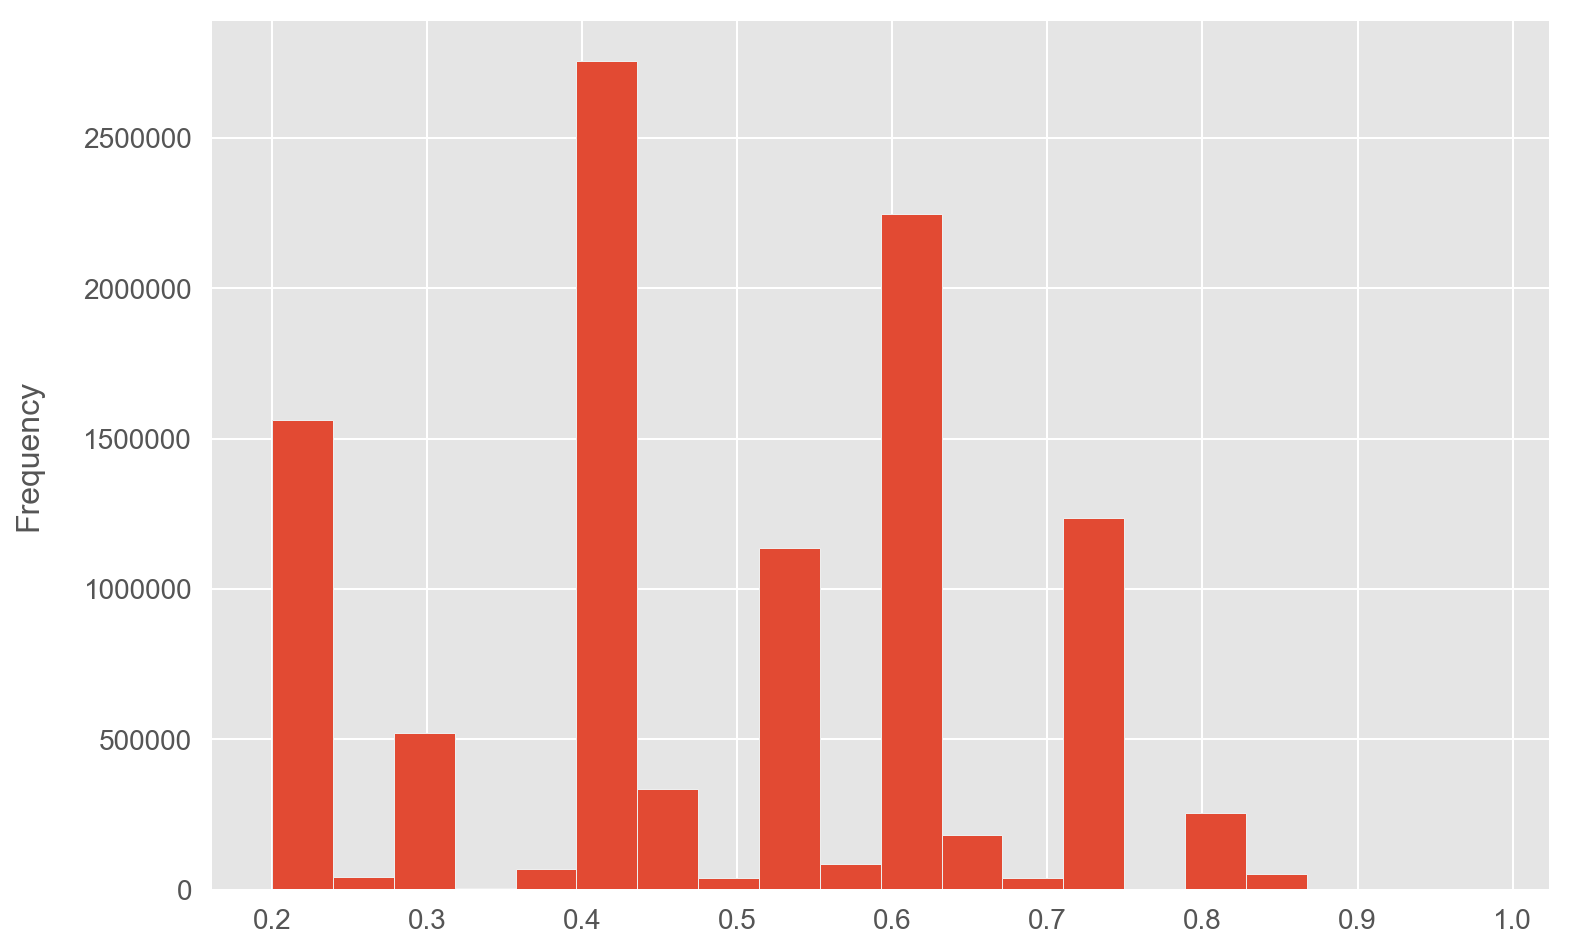

In [138]:
df_search_terms.lda_5_topic_score.plot.hist(bins=20)

Let's throw out anything less than 0.5

In [139]:
m = df_search_terms['lda_5_topic_score'].fillna(0) >= 0.5

df_search_terms['topic'] = float('nan')
df_search_terms.loc[m, 'topic'] = df_search_terms.loc[m, 'lda_5_topic']

In [140]:
df_search_terms.sample(5)

date             search_term  num_searches  \
1079064  2017-12-03             jogginghose             6   
10235045 2018-07-10                    doll            13   
5289370  2018-10-10              square top             1   
1533101  2017-12-28         french knickers             4   
7957844  2019-02-21  spagehtti strap sandal             1   

               search_term_lower                      lemmas  \
1079064              jogginghose               [jogginghose]   
10235045                    doll                      [doll]   
5289370               square top                    [square]   
1533101          french knickers           [french, knicker]   
7957844   spagehtti strap sandal  [spagehtti, strap, sandal]   

                             bigrams                              corpus  \
1079064                [jogginghose]                         [(4845, 1)]   
10235045                      [doll]                         [(3557, 1)]   
5289370                     [square]                           [(60, 1)]   
1533101             [french_knicker]                        [(18238, 1)]   
7957844   [spagehtti, strap, sandal]  [(1598, 1), (1599, 1), (39510, 1)]   

                                                                                 lda_5_topic_scores  \
1079064   [(0, 0.100006916), (1, 0.100006916), (2, 0.100006916), (3, 0.59997237), (4, 0.100006916)]   
10235045    [(0, 0.10003044), (1, 0.100030445), (2, 0.59987825), (3, 0.100030445), (4, 0.10003044)]   
5289370       [(0, 0.10000344), (1, 0.10000344), (2, 0.59998626), (3, 0.10000344), (4, 0.10000344)]   
1533101      [(0, 0.100494266), (1, 0.5980229), (2, 0.10049428), (3, 0.10049433), (4, 0.100494295)]   
7957844       [(0, 0.06648786), (1, 0.06648987), (2, 0.06648821), (3, 0.7340451), (4, 0.066488996)]   

          lda_5_topic  lda_5_topic_score  topic  
1079064           3.0           0.599972    3.0  
10235045          2.0           0.599878    2.0  
5289370           2.0           0.599986    2.0  
1533101           1.0           0.598023    1.0  
7957844           3.0           0.734045    3.0

We have labels (given our confidence cutoff of 0.5) for about half of the rows

In [141]:
df_search_terms.topic.isnull().sum() / df_search_terms.shape[0]

0.5105600309764271

Now we have topic labels, let's generate the charts.

In [142]:
topics = df_search_terms.topic.value_counts().index.sort_values().tolist()
topics

[0.0, 1.0, 2.0, 3.0, 4.0]

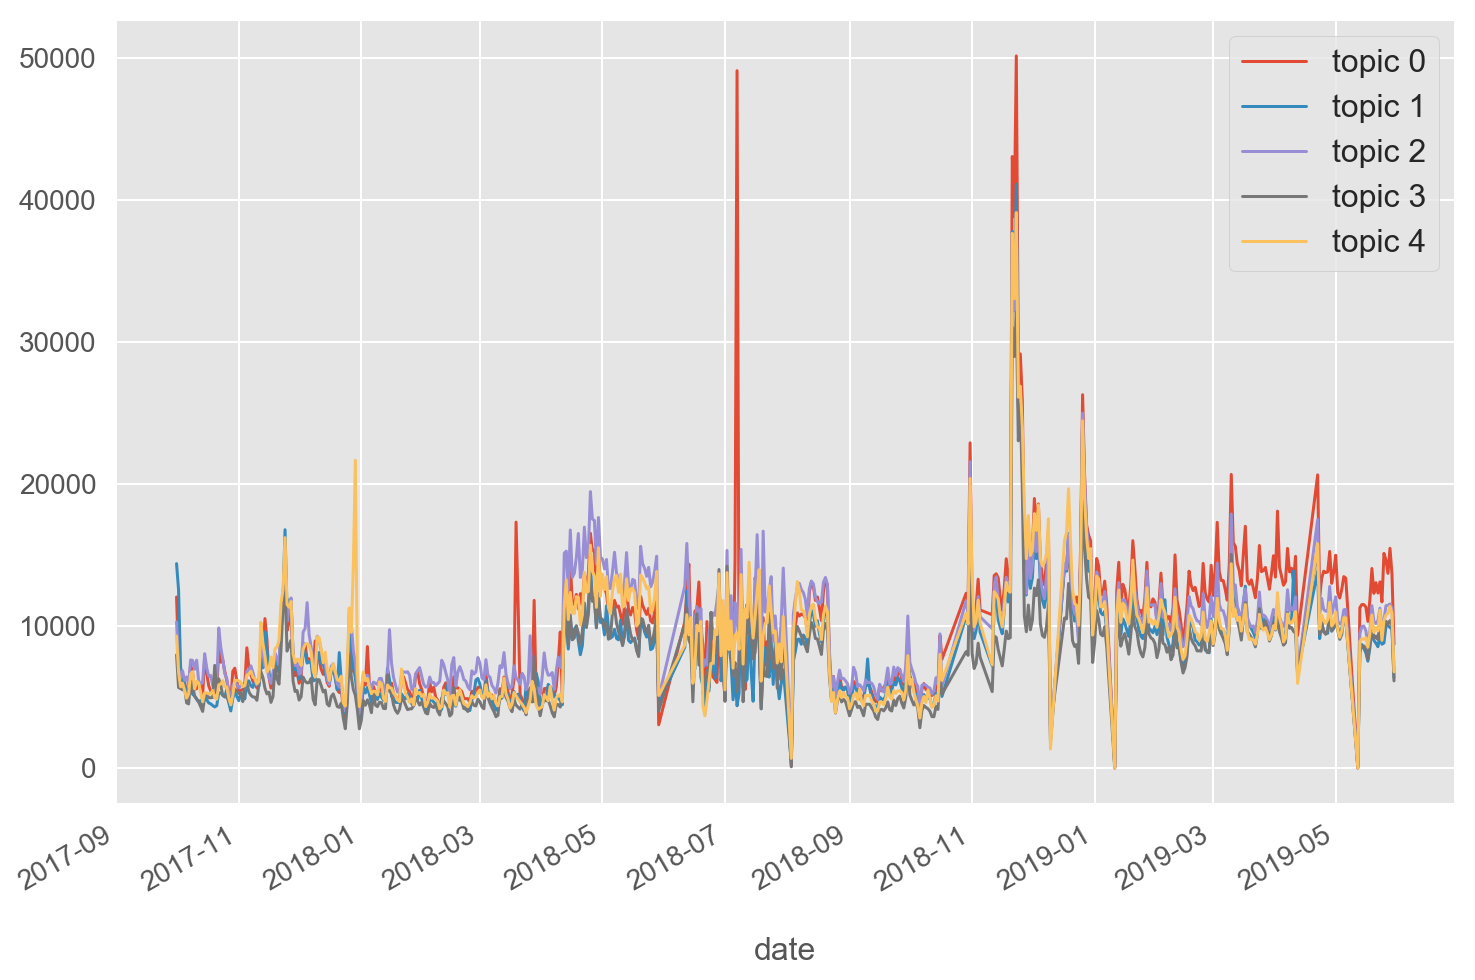

In [143]:
fig, ax = plt.subplots()
for topic in topics:
    m = df_search_terms.topic == topic
    df_search_terms[m].groupby('date').num_searches.sum().plot(ax=ax, label='topic {:.0f}'.format(topic))
    plt.legend()

Plot by week

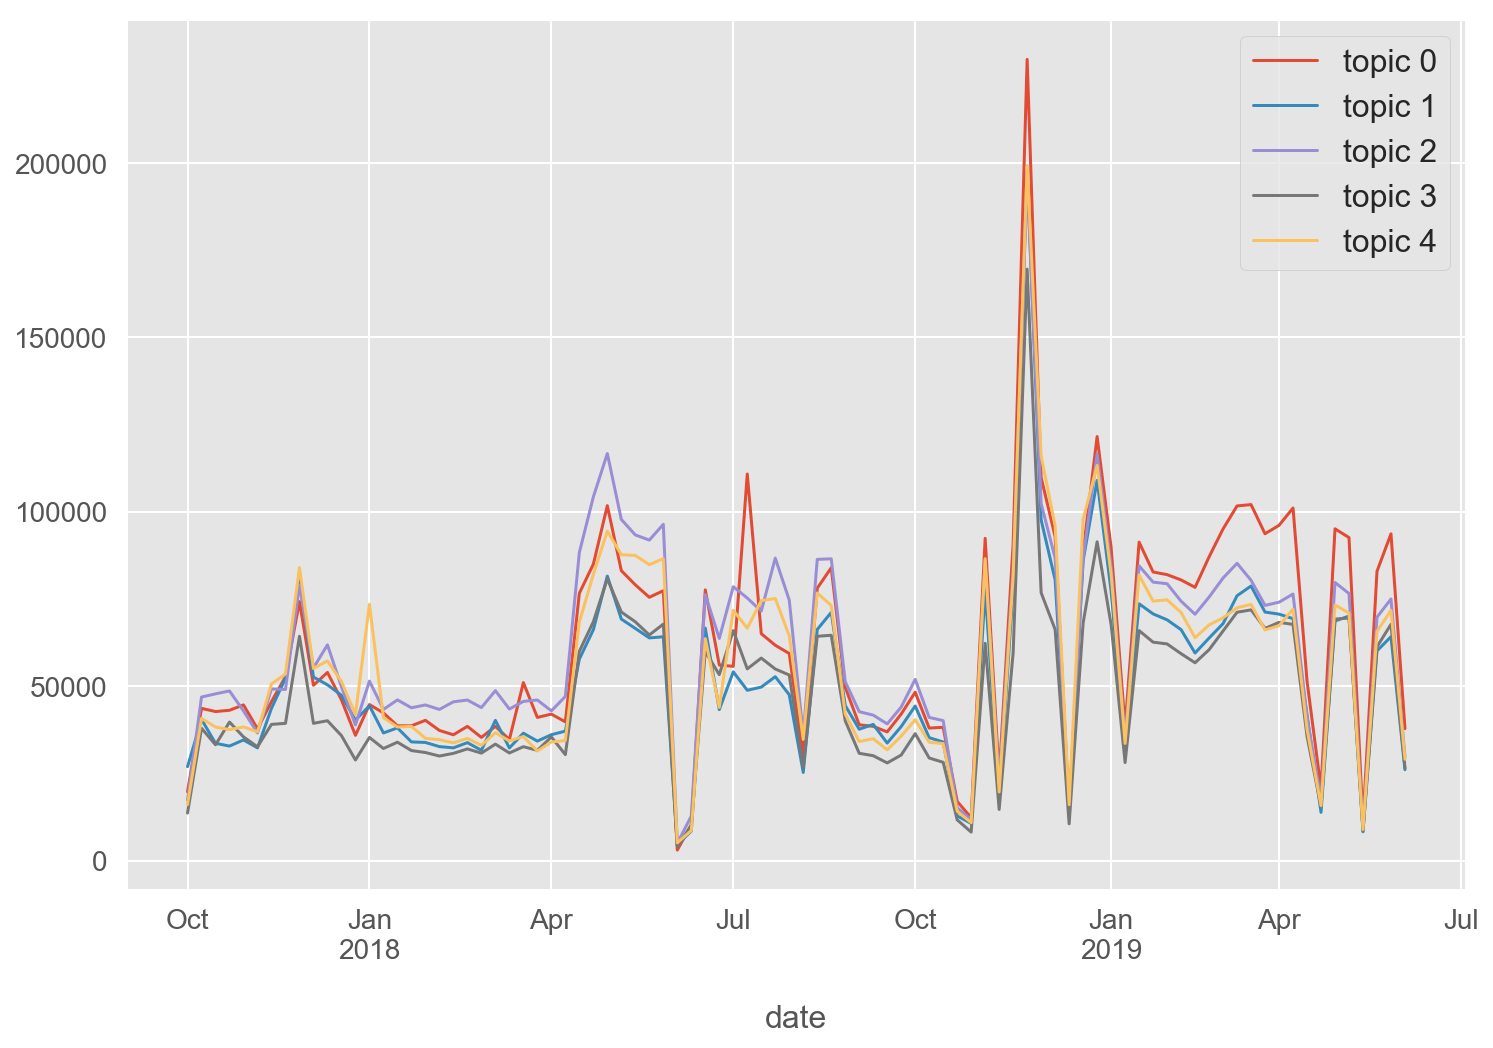

In [144]:
fig, ax = plt.subplots()
for topic in topics:
    m = df_search_terms.topic == topic
    s = df_search_terms[m].groupby(pd.Grouper(key='date', freq='W-MON')).num_searches.sum().dropna()
    s.plot(ax=ax, label='topic {:.0f}'.format(topic))
    plt.legend()

In [145]:
s[s.index > '2018-05-01']

date
2018-05-07     87716
2018-05-14     87516
2018-05-21     84869
2018-05-28     86585
2018-06-04      5119
2018-06-11      8673
2018-06-18     63665
2018-06-25     43956
2018-07-02     71797
2018-07-09     66655
2018-07-16     74547
2018-07-23     75159
2018-07-30     64475
2018-08-06     34783
2018-08-13     76755
2018-08-20     73164
2018-08-27     42050
2018-09-03     34159
2018-09-10     34968
2018-09-17     31794
2018-09-24     35729
2018-10-01     40411
2018-10-08     33964
2018-10-15     33574
2018-10-22     14194
2018-10-29     10897
2018-11-05     86598
2018-11-12     19700
2018-11-19     81549
2018-11-26    199237
2018-12-03    115989
2018-12-10     95992
2018-12-17     16052
2018-12-24     97849
2018-12-31    113315
2019-01-07     82055
2019-01-14     33626
2019-01-21     81911
2019-01-28     74405
2019-02-04     74815
2019-02-11     71148
2019-02-18     63925
2019-02-25     67591
2019-03-04     69646
2019-03-11     72514
2019-03-18     73475
2019-03-25     66137
2019-04-

Now look at the ratios...

Being careful to handle the cases where there might not be a search in a given week, we use `pd.date_range` to generate a canvas and post the data onto it.

In [146]:
def plot_trends(df, output_name='onsite_search_topic_relative_trends'):
    min_day = df.groupby(pd.Grouper(key='date', freq='W-MON')).size().index.sort_values().min()
    max_day = df.groupby(pd.Grouper(key='date', freq='W-MON')).size().index.sort_values().max()
    s_dates = pd.date_range(
        start=min_day,
        end=max_day,
        freq='7D',
    )
    canvas_post = lambda x: pd.DataFrame(s_dates, columns=['date']).set_index('date').join(x, how='outer')['num_searches']
    s_total = df.groupby(pd.Grouper(key='date', freq='W-MON')).num_searches.sum()
    s_total = canvas_post(s_total)

    fig, ax = plt.subplots()
    for topic in topics:
        m = df.topic == topic
        s = df[m].groupby(pd.Grouper(key='date', freq='W-MON')).num_searches.sum()
        # Post the data to the canvas
        s = (canvas_post(s) / s_total)
        s.dropna().plot(ax=ax, label='topic {:.0f}'.format(topic), lw=2)
        plt.legend()

    plt.xlabel('Date')
    plt.ylabel('Onsite Search Topic Frequency')
    savefig(output_name)

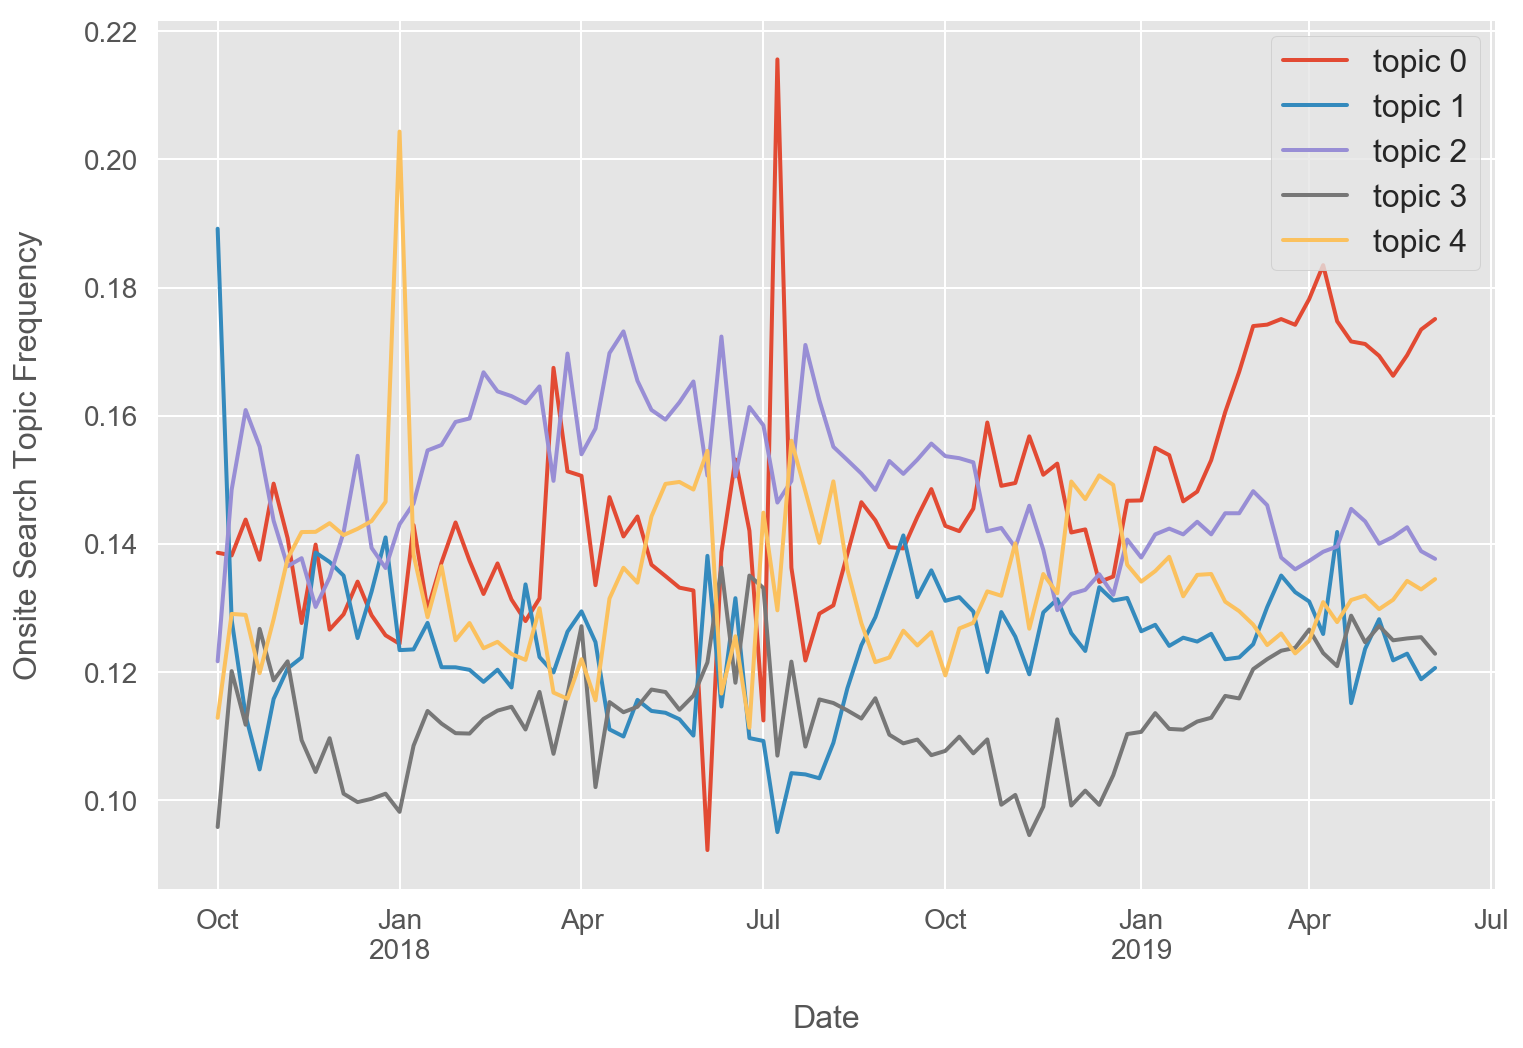

In [148]:
# m = (df_search_terms.date < '2018-05-01') | (df_search_terms.date > '2018-08-01')
plot_trends(df_search_terms)

Misc. notes:

- Topic 1 gradually increasing
- Topic 3 saw huge gain in mid 2018

### Modeling trend frequency

In [50]:
from fbprophet import Prophet
import warnings
# Ignore warnings from prophet lib
warnings.filterwarnings('ignore', 'Conversion of the second argument of issubdtype')

Text(0,0.5,'Onsite Search Topic Frequency')

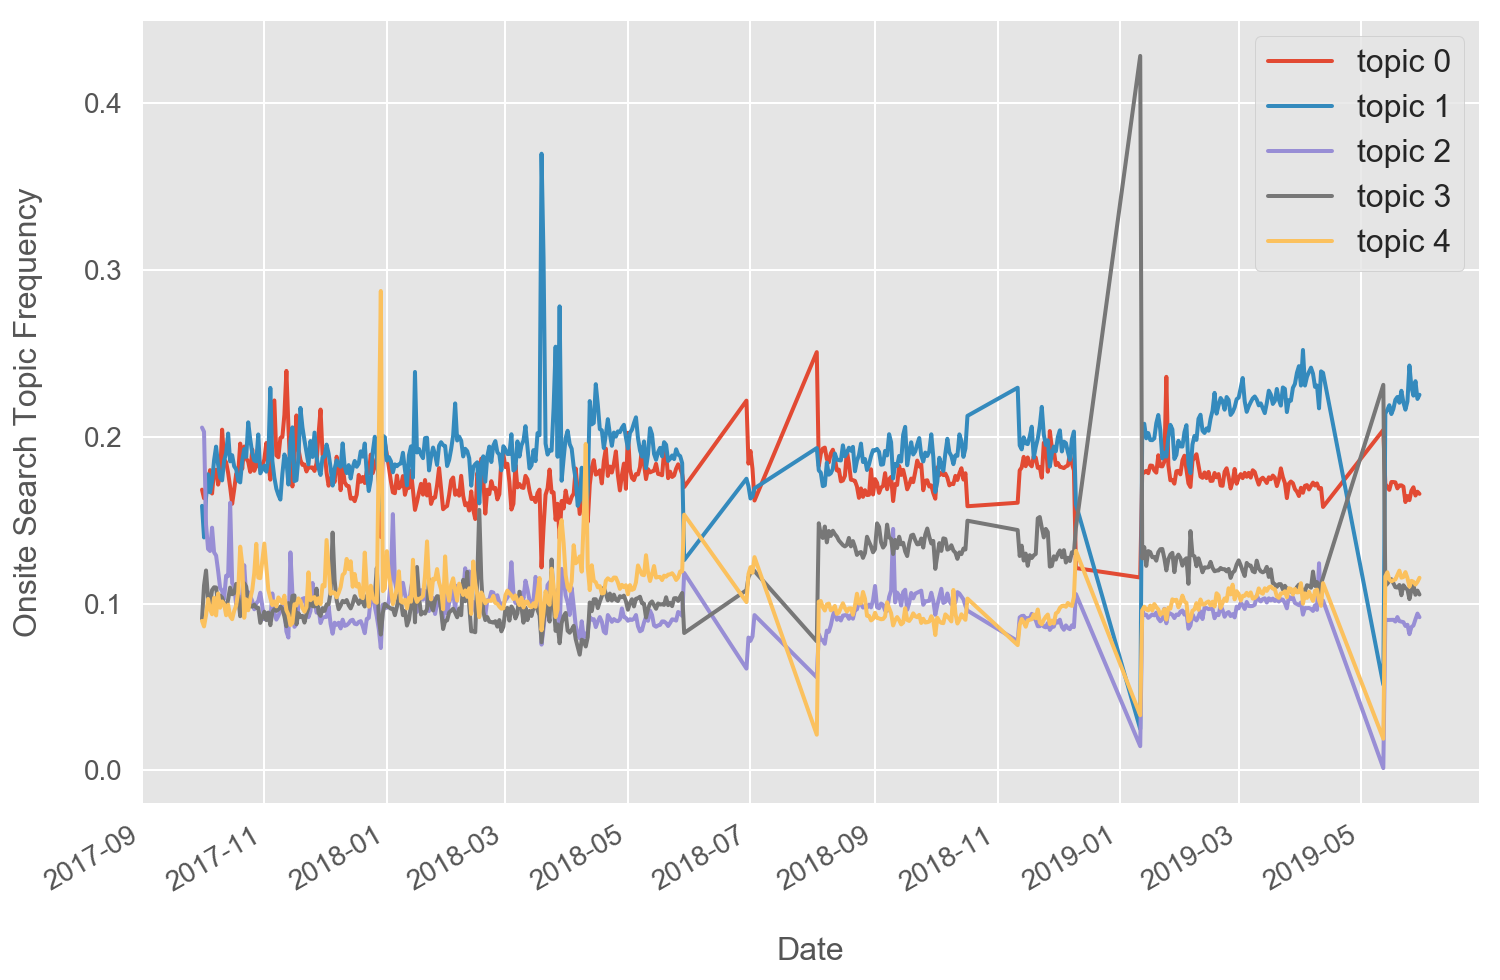

In [58]:
min_day = df_search_terms.groupby('date').size().index.sort_values().min()
max_day = df_search_terms.groupby('date').size().index.sort_values().max()
s_dates = pd.date_range(
    start=min_day,
    end=max_day,
    freq='D',
)
canvas_post = lambda x: pd.DataFrame(s_dates, columns=['date']).set_index('date').join(x, how='outer')['num_searches']
s_total = df_search_terms.groupby('date').num_searches.sum()
s_total = canvas_post(s_total)

# Save results for later
df_topic_freq = pd.DataFrame()

fig, ax = plt.subplots()
for topic in topics:
    m = df_search_terms.topic == topic
    s = df_search_terms[m].groupby('date').num_searches.sum()
    # Post the data to the canvas
    s = (canvas_post(s) / s_total)
    s.name = topic
    df_topic_freq = pd.concat((df_topic_freq, s), axis=1)
    s.dropna().plot(ax=ax, label='topic {:.0f}'.format(topic), lw=2)
    plt.legend()

plt.xlabel('Date')
plt.ylabel('Onsite Search Topic Frequency')
# savefig('onsite_search_topic_relative_trends')

In [59]:
df_topic_freq

0.0       1.0       2.0       3.0       4.0
date                                                        
2017-10-01  0.168262  0.158538  0.205469  0.090729  0.089589
2017-10-02  0.163048  0.139598  0.202965  0.110856  0.086259
2017-10-03  0.168198  0.163463  0.147315  0.119794  0.092982
2017-10-04  0.172086  0.177440  0.132715  0.102681  0.102725
2017-10-05  0.179945  0.166637  0.131485  0.099104  0.096604
2017-10-06  0.165939  0.173268  0.145455  0.108043  0.093532
2017-10-07  0.179817  0.185852  0.130653  0.109724  0.103430
2017-10-08  0.180186  0.194053  0.128763  0.109607  0.092840
2017-10-09  0.171272  0.183240  0.119685  0.099855  0.106015
2017-10-10  0.176738  0.175498  0.109373  0.104734  0.097453
2017-10-11  0.204206  0.173803  0.107472  0.103490  0.101230
2017-10-12  0.186427  0.185650  0.102903  0.099442  0.099630
2017-10-13  0.184683  0.190146  0.116654  0.097070  0.092947
2017-10-14  0.178312  0.201903  0.116350  0.102359  0.099291
2017-10-15  0.169777  0.185192  0.160380  0.109558  0.092378
2017-10-16  0.159779  0.188902  0.112144  0.105536  0.090598
2017-10-17  0.168186  0.182295  0.110375  0.106178  0.095497
2017-10-18  0.177765  0.180458  0.099404  0.111749  0.098832
2017-10-19  0.177873  0.173577  0.104671  0.104426  0.106832
2017-10-20  0.195872  0.172604  0.098201  0.092372  0.134066
2017-10-21  0.180704  0.185482  0.104962  0.098005  0.124022
2017-10-22  0.194107  0.192588  0.122936  0.112179  0.091434
2017-10-23  0.187014  0.187853  0.104418  0.110097  0.102474
2017-10-24  0.184907  0.208606  0.106807  0.101820  0.095947
2017-10-25  0.178894  0.198405  0.104370  0.098267  0.102766
2017-10-26  0.192357  0.190146  0.101499  0.098150  0.108063
2017-10-27  0.179521  0.185735  0.096518  0.099262  0.118214
2017-10-28  0.183380  0.185204  0.100046  0.097497  0.135761
2017-10-29  0.184164  0.201346  0.101550  0.097417  0.115487
2017-10-30  0.179922  0.178025  0.106465  0.088373  0.115181
...              ...       ...       ...       ...       ...
2019-05-01       NaN       NaN       NaN       NaN       NaN
2019-05-02       NaN       NaN       NaN       NaN       NaN
2019-05-03       NaN       NaN       NaN       NaN       NaN
2019-05-04       NaN       NaN       NaN       NaN       NaN
2019-05-05       NaN       NaN       NaN       NaN       NaN
2019-05-06       NaN       NaN       NaN       NaN       NaN
2019-05-07       NaN       NaN       NaN       NaN       NaN
2019-05-08       NaN       NaN       NaN       NaN       NaN
2019-05-09       NaN       NaN       NaN       NaN       NaN
2019-05-10       NaN       NaN       NaN       NaN       NaN
2019-05-11       NaN       NaN       NaN       NaN       NaN
2019-05-12  0.204054  0.051351  0.001351  0.231081  0.018919
2019-05-13  0.171751  0.213824  0.090560  0.110676  0.116243
2019-05-14  0.169662  0.216136  0.090112  0.111830  0.118731
2019-05-15  0.168130  0.218880  0.090166  0.113599  0.114381
2019-05-16  0.172835  0.213565  0.090219  0.114586  0.113311
2019-05-17  0.172829  0.216630  0.090234  0.112191  0.113930
2019-05-18  0.172626  0.222107  0.089177  0.109784  0.114401
2019-05-19  0.169011  0.223804  0.091866  0.109550  0.116984
2019-05-20  0.170773  0.220339  0.089437  0.111097  0.119711
2019-05-21  0.170864  0.227515  0.089124  0.104939  0.115505
2019-05-22  0.170052  0.220541  0.088812  0.110932  0.115887
2019-05-23  0.160814  0.216191  0.086543  0.109191  0.118816
2019-05-24  0.164398  0.221072  0.087262  0.108455  0.115332
2019-05-25  0.161954  0.242677  0.081611  0.102612  0.110065
2019-05-26  0.167656  0.229638  0.085891  0.108035  0.113572
2019-05-27  0.169672  0.224630  0.086812  0.111081  0.113033
2019-05-28  0.164727  0.233275  0.090542  0.105228  0.111324
2019-05-29  0.167031  0.222621  0.093961  0.107731  0.112966
2019-05-30  0.165729  0.225143  0.091774  0.105369  0.115413

[607 rows x 5 columns]

In [ ]:
df_prophet = df[['date', 'transactions']]\
    .rename(columns={'date': 'ds', 'transactions': 'y'})
df_prophet['ds'] = df_prophet['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))



In [ ]:
m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=1,
    yearly_seasonality=20,
    seasonality_prior_scale=0.1,
)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)
plt.ylabel('Transactions')
plt.xlabel('Date')
# savefig('sales_forecast_transactions')

**How can this be applied?**

- Use trend patterns (seasonal and non-seasonal) to inform marketing strategy.
- Label users (realtime) who use onsite search. Curate experience (e.g. banner ads, recommended items) based on topic grouping.

**Similar research ideas**

- Apply topic labels to sessions and train predictive model on many features (e.g. region, browser, source, pages per session, etc...). Use interpretation library like [Lime](https://github.com/marcotcr/lime) to understand these user groups better.
- In a semi-structured approach, manually label a set of onsite searches (e.g. 1k rows), train model and apply predictions to remaining dataset. Pros: topic groups are easier to interpret. Cons: time spent labelling data, must be careful to spotcheck results.

In [46]:

from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')
